Ex-Switch date explore for STC

* Explore switch data schema.

* Simulate wire SLE. 

* Debug/verification


In [1]:
from pyspark.sql.functions import lit, udf, size, avg, min as min_, max as max_, sum as sum_, count, countDistinct, col, mean, stddev, struct, explode, explode_outer, unix_timestamp, sum as sum_


In [2]:
import matplotlib as mpl
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# DHCP stats
const (
	DHCP_UNKNOWN DHCPBound = iota // we cannot locate the entry in `show dhcp-security binding`
	DHCP_BOUNDED                  // BOUND
	DHCP_UNBOUND                  // anything else
)

https://www.cisco.com/c/en/us/support/docs/ip/dynamic-address-allocation-resolution/27470-100.html


In [4]:
env = "staging"
DATE = '2019-12-10/'
file_path = 's3://mist-secorapp-{env}/oc-stats-analytics/oc-stats-analytics-{env}/dt={date}/*'.format(env=env, date=DATE)
df = spark.read.parquet(file_path)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- mac: string (nullable = true)
 |-- org_id: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- when: long (nullable = true)
 |-- remote_addr: string (nullable = true)
 |-- clients: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- vlan_name: string (nullable = true)
 |    |    |-- mac: string (nullable = true)
 |    |    |-- flags: string (nullable = true)
 |    |    |-- age: integer (nullable = true)
 |    |    |-- iface_name: string (nullable = true)
 |    |    |-- vlan_id: integer (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- hostname: string (nullable = true)
 |    |    |-- dhcpbound: integer (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |    |-- group: string (nullable = true)
 |    |    |-- auth_state: string (nullable = true)
 |    |    |-- auth_method: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- mo

In [5]:
df_client = df.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("clients")).alias("clients")).select('id','when', 'org_id', 'site_id', 'clients.*')


In [6]:
df_client_pd = df_client.toPandas()

In [7]:
df_client_pd.head()

id              when                                org_id  \
0  0c8126c71290  1576008718803778  b4e16c72-d50e-4c03-a952-a3217e231e2c   
1  0c8126c71290  1576008718803778  b4e16c72-d50e-4c03-a952-a3217e231e2c   
2  0c8126c71290  1576008718803778  b4e16c72-d50e-4c03-a952-a3217e231e2c   
3  0c8126c71290  1576008718803778  b4e16c72-d50e-4c03-a952-a3217e231e2c   
4  0c8126c71290  1576008718803778  b4e16c72-d50e-4c03-a952-a3217e231e2c   

                                site_id vlan_name           mac flags  age  \
0  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39   default  5c5b350ee012          0   
1  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39   default  54bf64030e76          0   
2  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39   default  5c5b35500168          0   
3  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39   default  b827ebca4e4d          0   
4  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39   Mist102  b827ebca4e4d          0   

  iface_name  vlan_id            ip      hostname  dhcpbound username group  \
0   ge-0/0/0        1  192.168.2.79          QAAP          0                  
1   ge-0/0/2        1       0.0.0.0                        0                  
2   ge-0/0/3        1  192.168.2.29  5c5b35500168          0                  
3   ge-0/0/7        1       0.0.0.0                        0                  
4   ge-0/0/7      102       0.0.0.0                        0                  

  auth_state auth_method  
0                         
1                         
2                         
3                         
4

In [8]:
df_client_pd.columns

Index(['id', 'when', 'org_id', 'site_id', 'vlan_name', 'mac', 'flags', 'age',
       'iface_name', 'vlan_id', 'ip', 'hostname', 'dhcpbound', 'username',
       'group', 'auth_state', 'auth_method'],
      dtype='object')

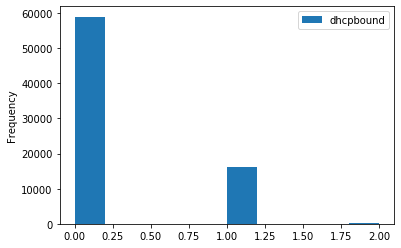

In [9]:
df_client_pd.plot(kind="hist", y="dhcpbound")

In [19]:
df_client_pd[df_client_pd['dhcpbound']>1]["when"].min()

1575947494470703

In [20]:
df1 = df_client_pd[(df_client_pd['mac']=="2047470c2f39")&(df_client_pd['when']>1575947494470703-6000)]

In [22]:
df1[["when", "dhcpbound", "ip"]].sort_values("when")

when  dhcpbound          ip
54354  1575947525849281          1  10.88.88.7
54416  1575947585849414          1  10.88.88.7
54478  1575947645849523          1  10.88.88.7
54540  1575947705849630          1  10.88.88.7
7247   1575947765849772          1  10.88.88.7
...                 ...        ...         ...
29695  1576014913354947          2  10.88.88.7
29755  1576014973355165          2  10.88.88.7
29821  1576015033355398          2  10.88.88.7
29884  1576015093355647          2  10.88.88.7
29948  1576015153355847          2  10.88.88.7

[1127 rows x 3 columns]

In [ ]:
df1_i = df1.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("interfaces")).alias("interface")).select('id','when', 'org_id', 'site_id', 'interface.*')


In [8]:
# to pandas 
import pandas as pd
df1_i = df1.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("interfaces")).alias("interface")).select('id','when', 'org_id', 'site_id', 'interface.*')
# df1_i.take(1)

df_pd = df1_i.filter(col("link")==True).toPandas()


In [9]:
df_pd.to_csv("t.csv")

In [11]:
df_pd.head()

id              when                                org_id  \
0  28a24b810c97  1575646089733240  df59193d-ecdc-4a07-b570-b2de6c62c464   
1  28a24b810c97  1575646089733240  df59193d-ecdc-4a07-b570-b2de6c62c464   
2  28a24b810c97  1575646089733240  df59193d-ecdc-4a07-b570-b2de6c62c464   
3  28a24b810c97  1575646089733240  df59193d-ecdc-4a07-b570-b2de6c62c464   
4  28a24b810c97  1575646089733240  df59193d-ecdc-4a07-b570-b2de6c62c464   

                                site_id       name  link  full_duplex  mbps  \
0  5fda4ac7-62b0-4588-95b3-f8234e890b13   ge-0/0/0  True         True  1000   
1  5fda4ac7-62b0-4588-95b3-f8234e890b13  ge-0/0/15  True         True  1000   
2  5fda4ac7-62b0-4588-95b3-f8234e890b13  ge-0/0/23  True         True  1000   
3  5fda4ac7-62b0-4588-95b3-f8234e890b13       bme0  True        False     0   
4  5fda4ac7-62b0-4588-95b3-f8234e890b13       cbp0  True        False     0   

    mtu address  ...  remote_mgmt_addr                    remote_system_desc  \
0  1514          ...           0.0.0.0  USW-8P-60, 4.0.69.10871, Linux 3.6.5   
1  1514          ...    192.168.50.118   Mist Systems 802.11ac Access Point.   
2  1514          ...     192.168.50.69                 UAP-SHD, 4.0.69.10871   
3  9512          ...                                                           
4  9192          ...                                                           

     remote_mac  remote_vlan_id  remote_hardware  remote_serial  \
0  f09fc210a160               0                                   
1  5c5b350ece2e               0          AP41-US  10019170200CE   
2  788a200ae0a0               0                                   
3                             0                                   
4                             0                                   

   remote_manufacture         remote_system_capability mac_count link_flapped  
0                                               Bridge        11        False  
1       Mist Systems.         Bridge WLAN Access Point         1        False  
2                      Bridge WLAN Access Point Router         5        False  
3                                                              0        False  
4                                                              0        False  

[5 rows x 62 columns]

# time series


In [11]:
df_pd['datetime'] = [ pd.Timestamp(x*1000) for x in df_pd['when']]

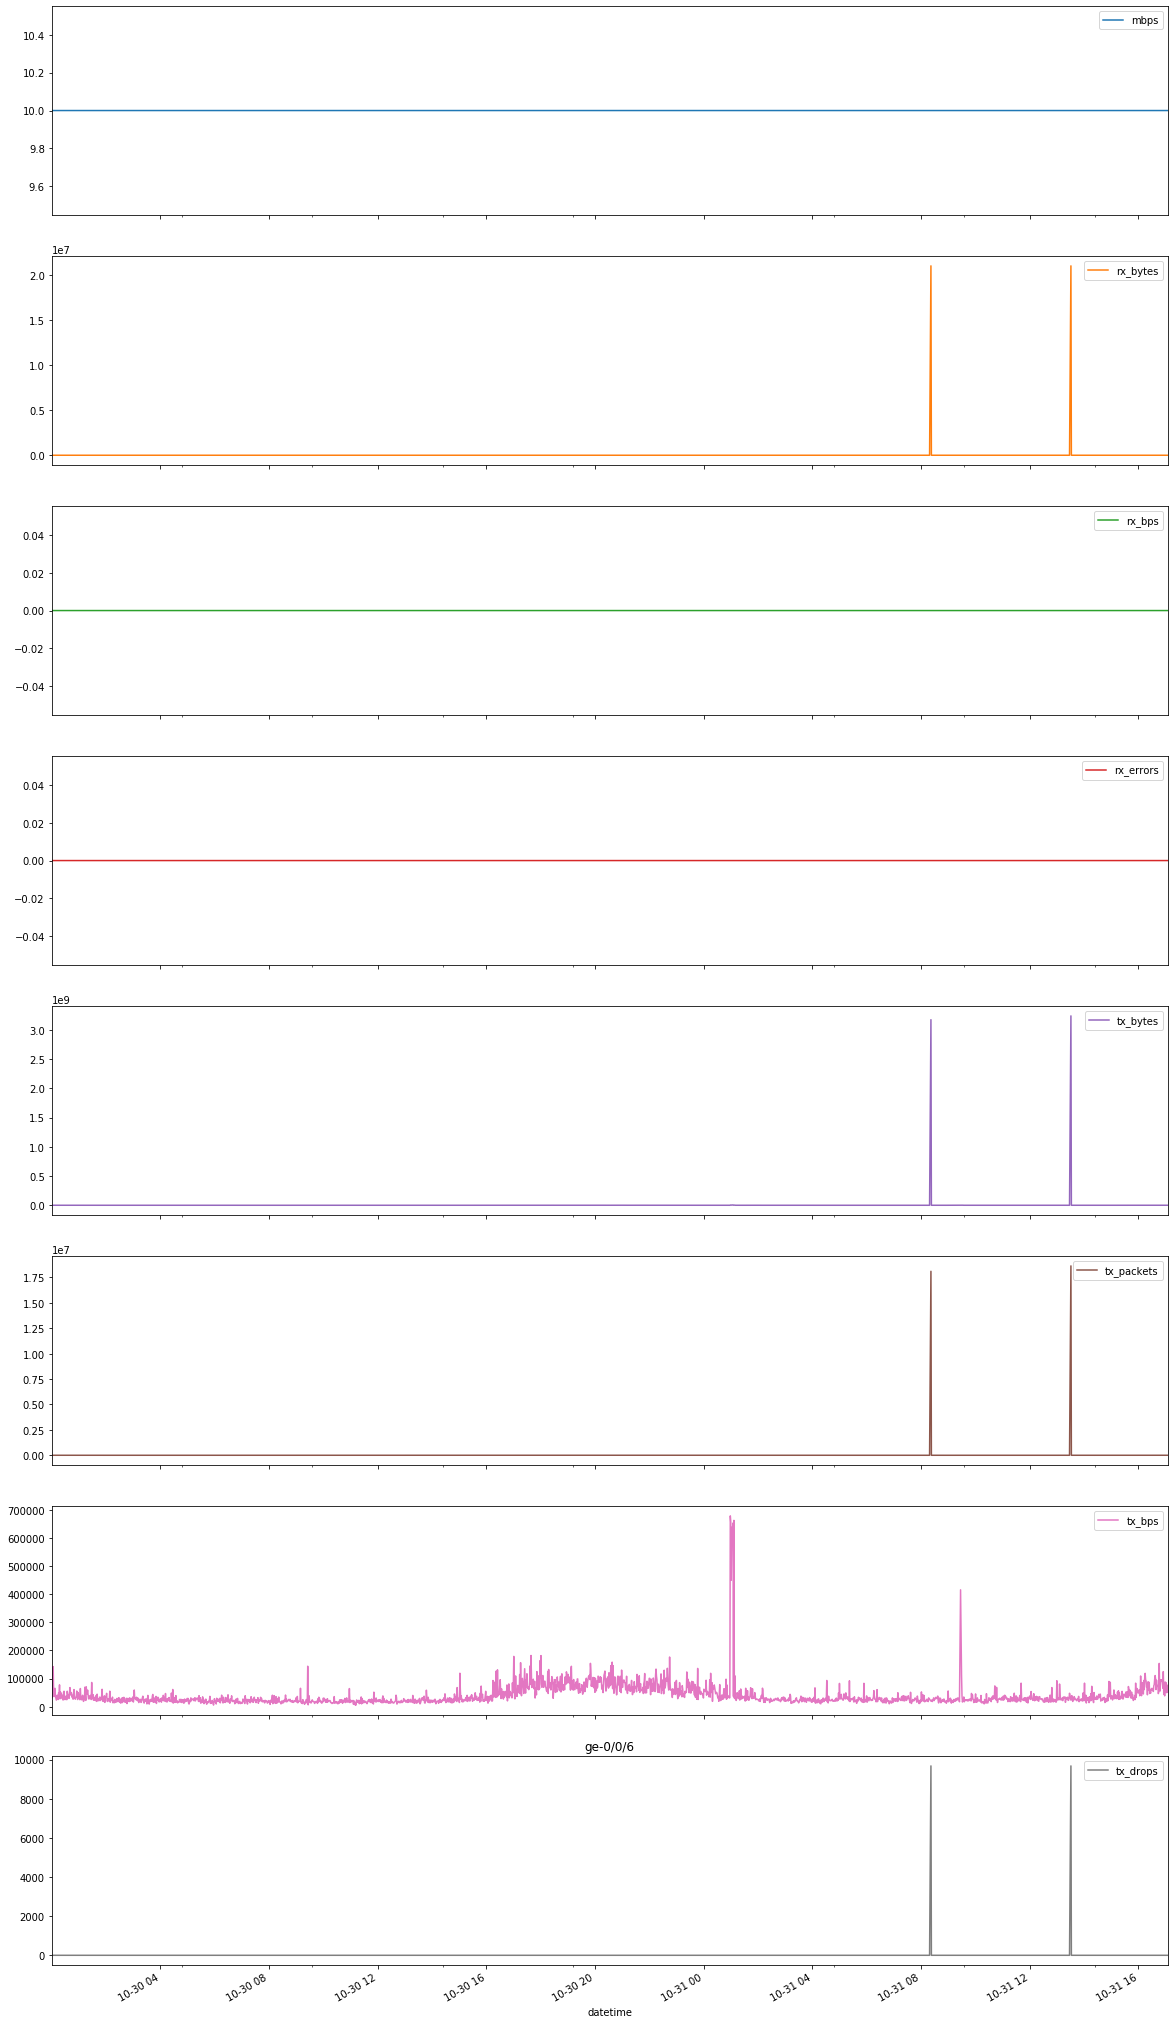

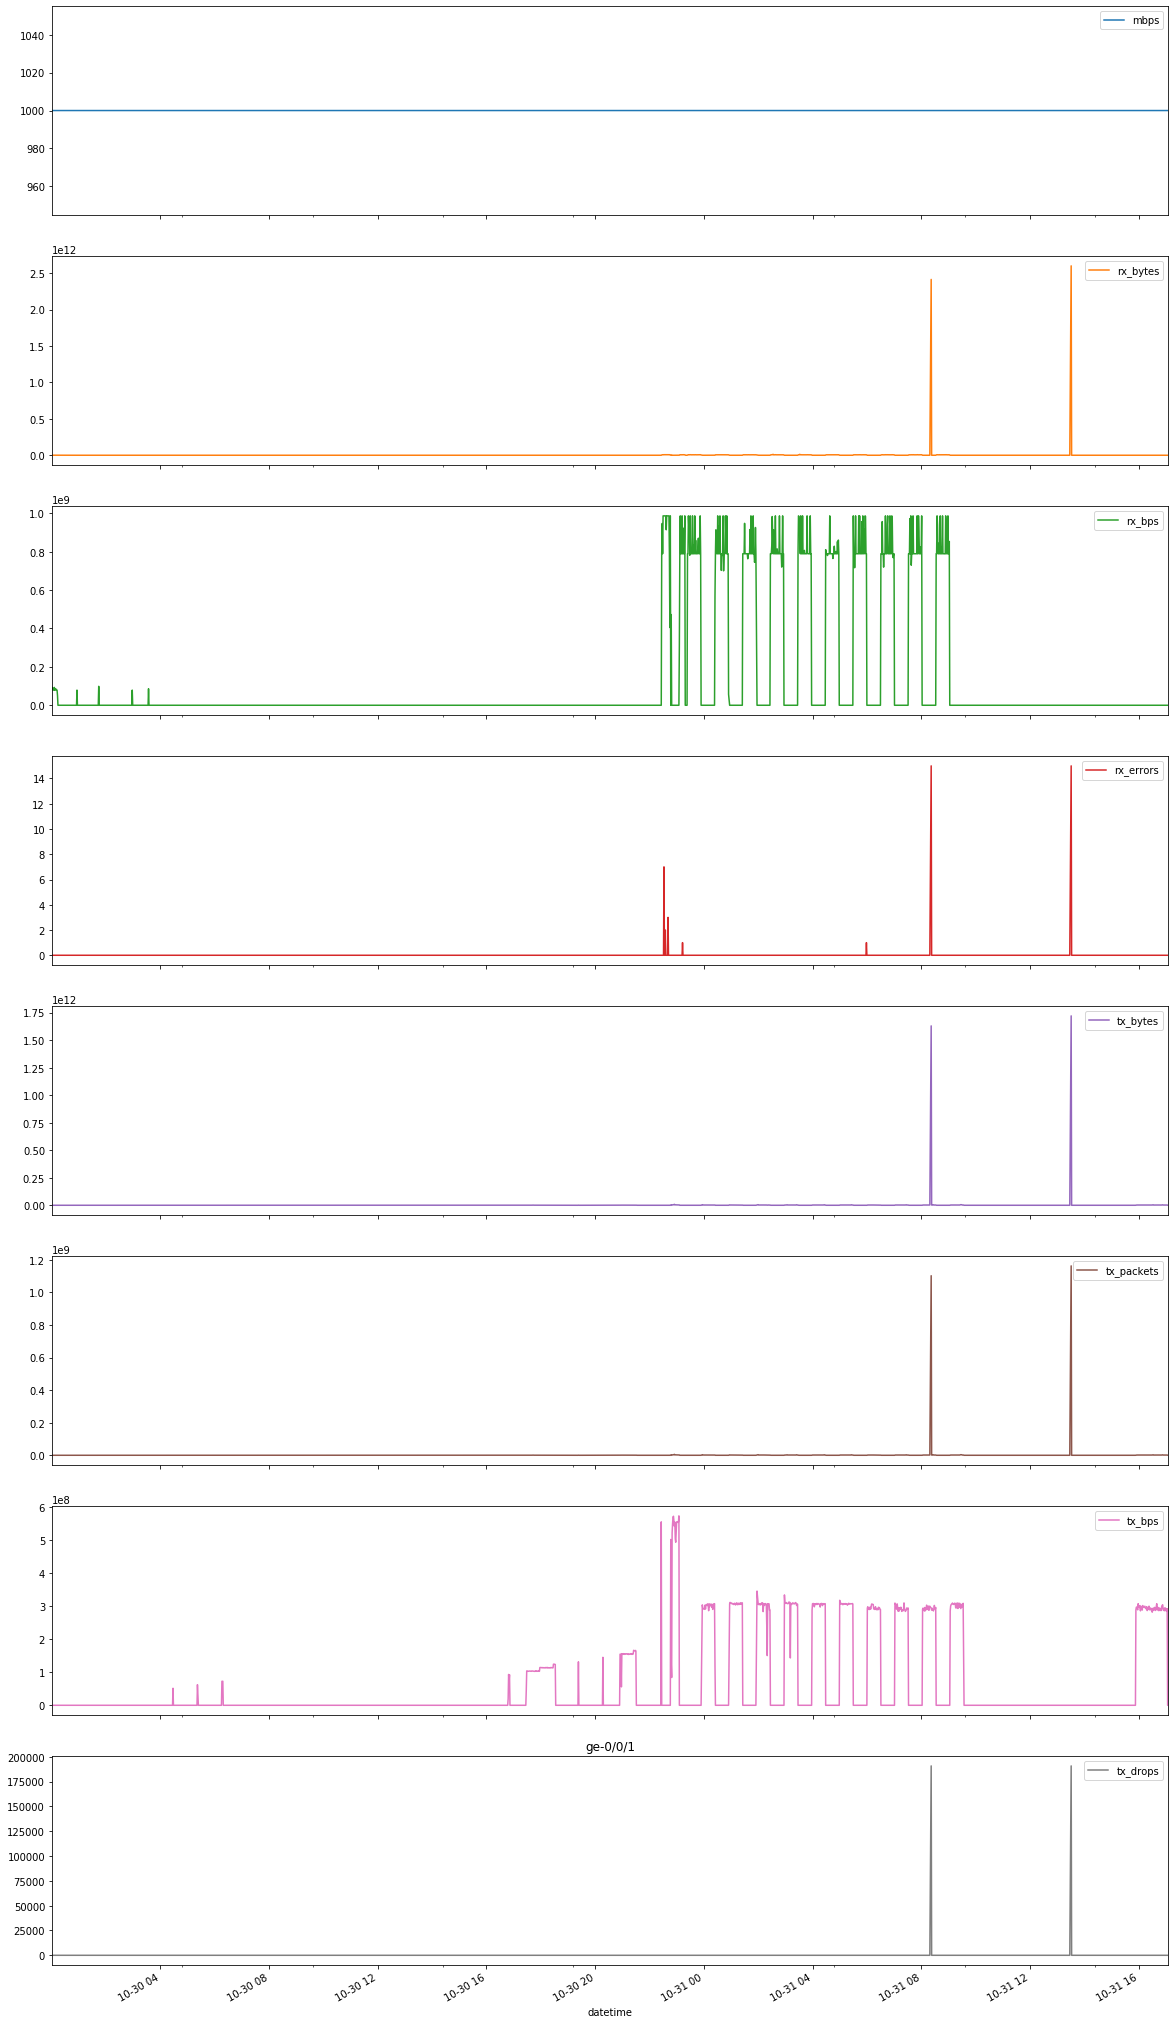

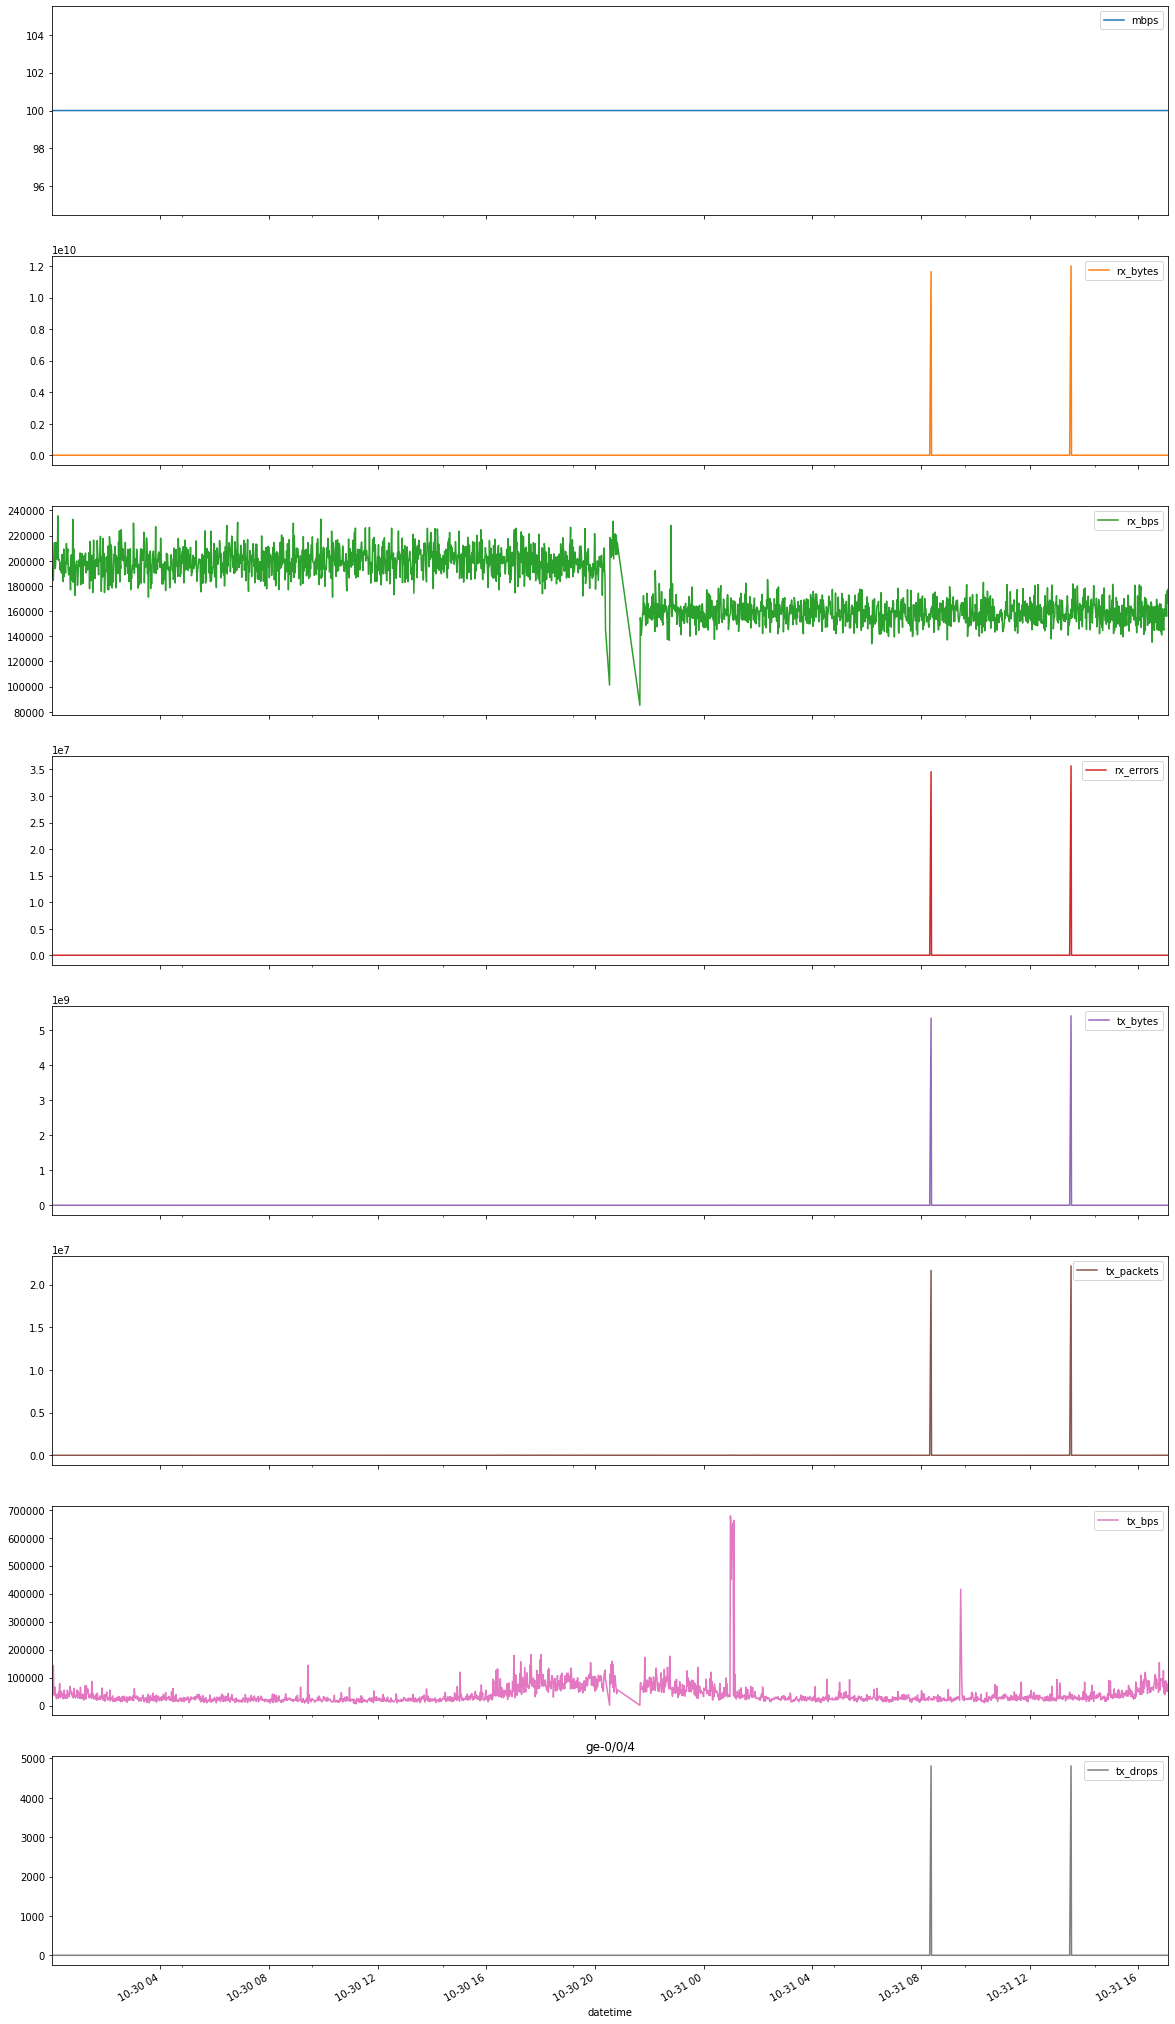

In [12]:
ylabs = ['mbps','rx_bytes', 'rx_bps', 'rx_errors',"tx_bytes", "tx_packets", "tx_bps", "tx_drops" ]

df_abi = df_pd[df_pd['id']==abi_switch]

names = set(df_abi['name'])
for name in names:
    df_link = df_abi[df_abi['name']==name]
    if df_link['tx_drops'].max()> 0:
        df_abi[df_abi['name']==name].plot(x="datetime", y = ylabs, subplots=True, figsize=(20, 40))
        plt.title(name)
    

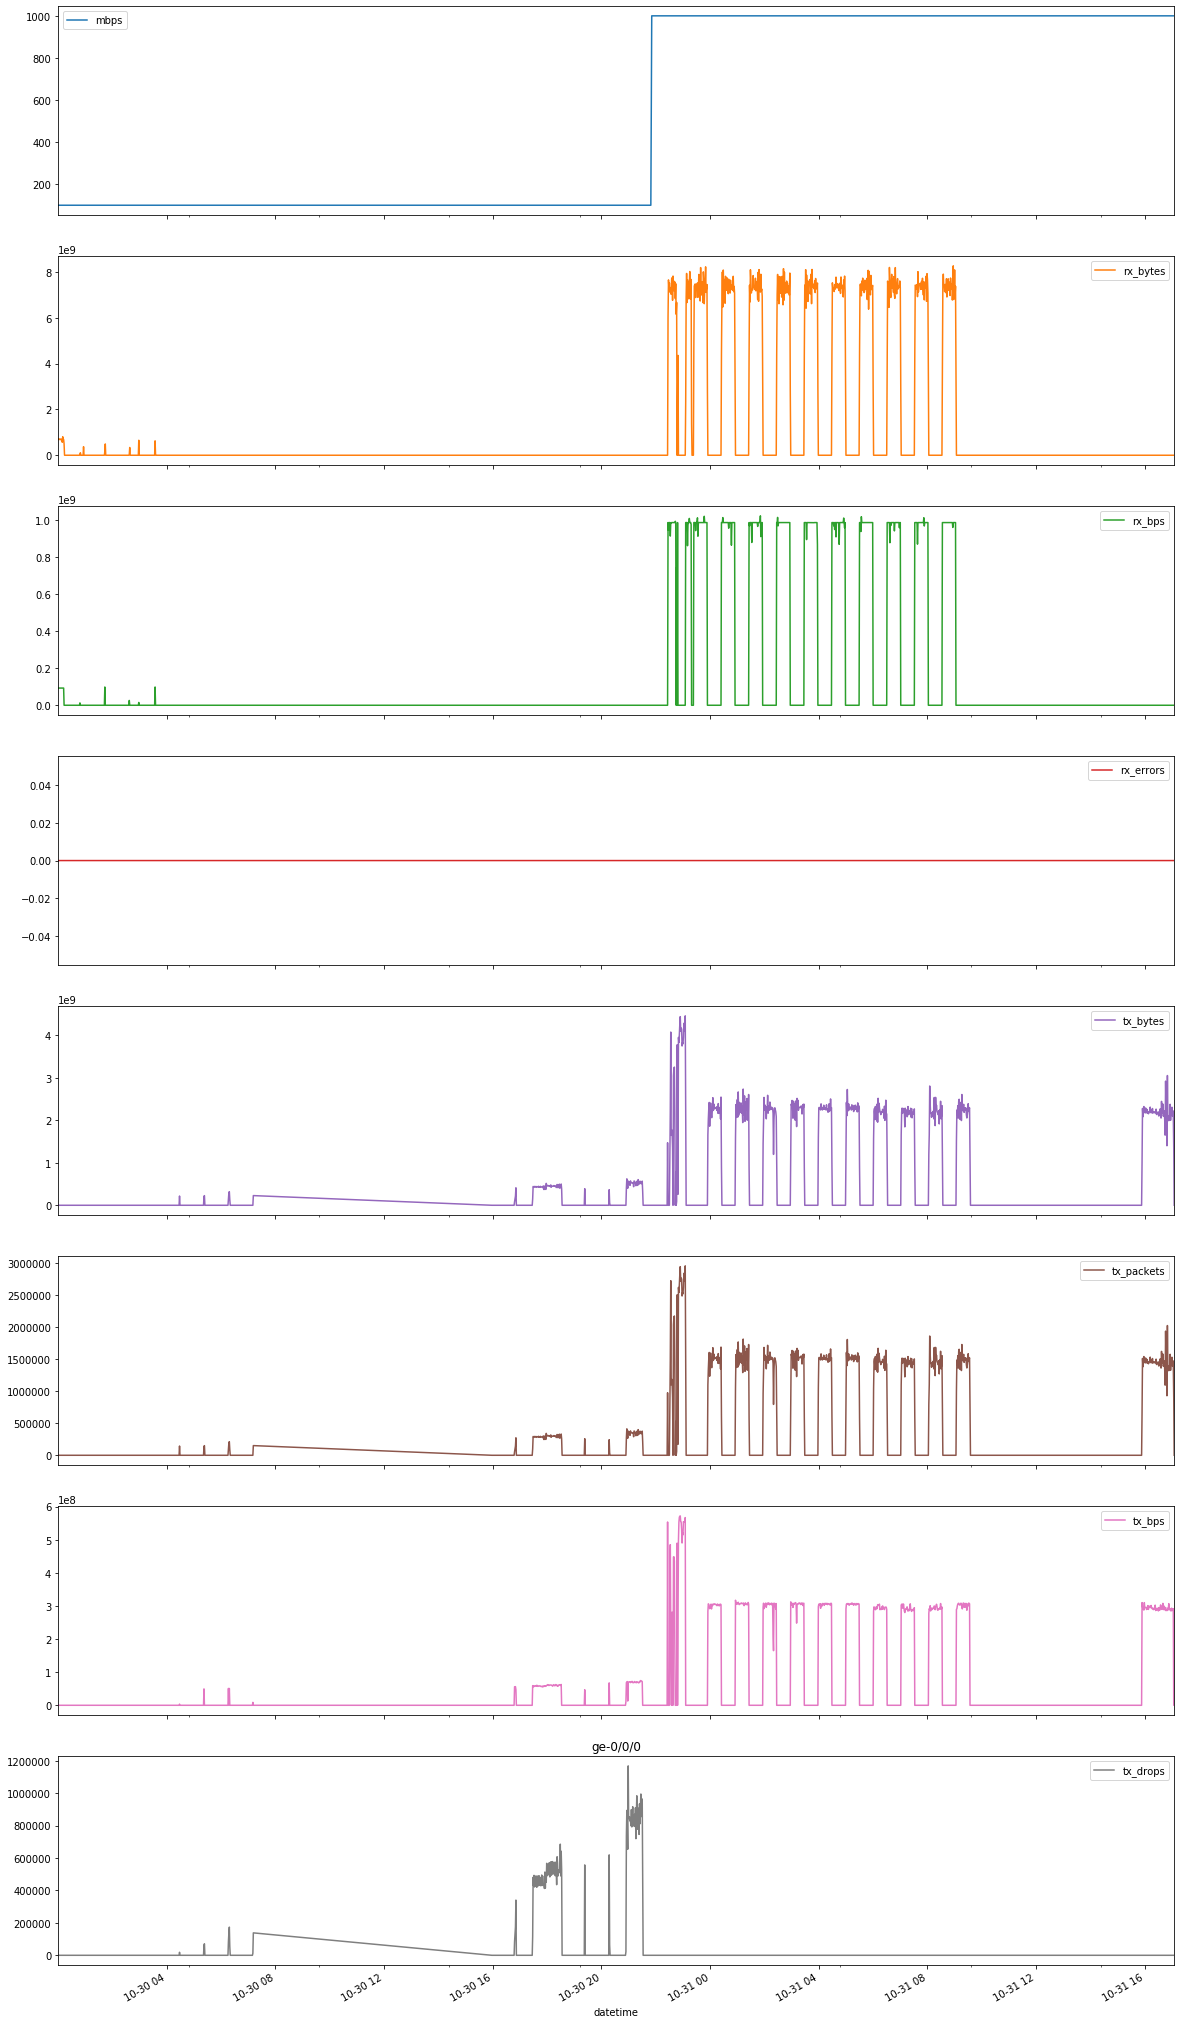

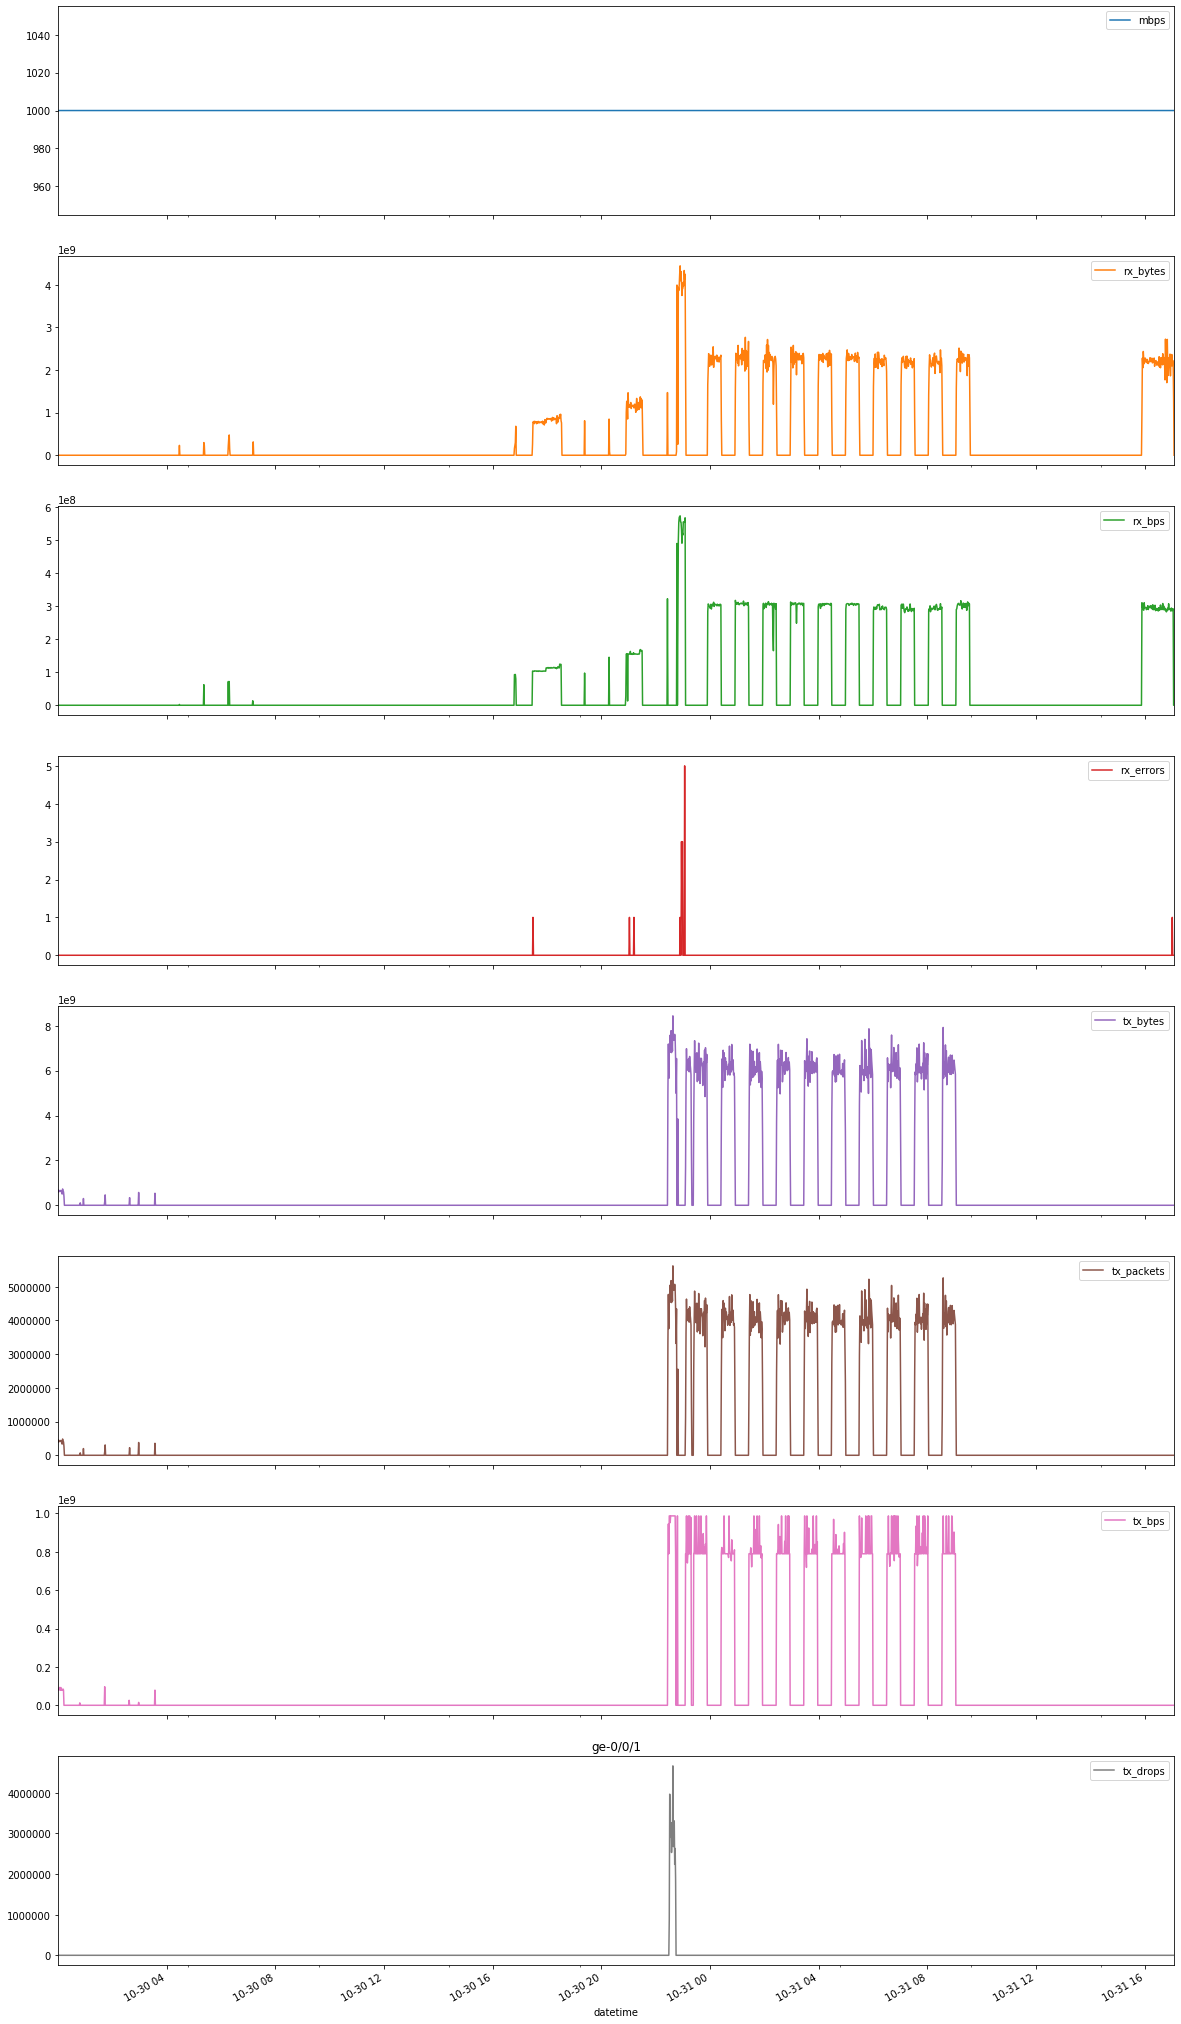

In [13]:
df_wf = df_pd[df_pd['id']==wf_switch]

names = set(df_wf['name'])
for name in names:
    df_link = df_wf[df_wf['name']==name]
    if df_link['tx_drops'].max()> 0:
        df_wf[df_wf['name']==name].plot(x="datetime", y = ylabs, subplots=True, figsize=(20, 40))
        plt.title(name)

In [112]:
# df_pd[df_pd['tx_drops']/df_pd["tx_packets"]>1][['tx_drops', 'tx_packets']]

tx_drops  tx_packets
47382      50436       42856
56159    8410902          97
56168    8669258          89
56177    8199064          94
56186    9789470          86
...          ...         ...
320945   9751190          78
320954   8557820          83
320963   9955060          88
322907   8630654          83
322916   8635462          89

[411 rows x 2 columns]

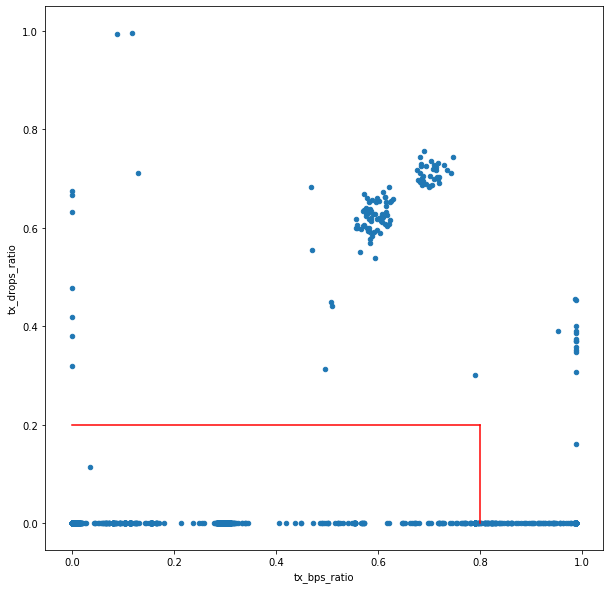

In [14]:

# df_t = pd.read_csv("wire.csv")
# df_t.head()
df_pd["tx_bps_ratio"]= df_pd['tx_bps']/df_pd['mbps']/1.e6
df_pd['tx_drops_ratio'] = df_pd['tx_drops']/(df_pd["tx_packets"] + df_pd['tx_drops'])
df_t = df_pd[df_pd['mbps']>0]

# h2 = plt.hist2d(df_t["tmp"], df_t["tx_drops_ratio"], norm=mpl.colors.LogNorm())

# plt.hist(df_pd['tx_drops_ratio'])
# plt.hist(df_t["tx_drops_ratio"])

df_t.plot(kind="scatter", x="tx_bps_ratio", y = "tx_drops_ratio", figsize=(10, 10))
plt.plot((0.0, 0.8), (0.2, 0.2), color="red")
plt.plot((0.8, 0.8), (0.0, 0.2), color="red")
# plt.hist2d(df_t['tx_bps_ratio'], df_t['tx_drops_ratio'])

In [15]:
# df_pd['sle'] = [ x for ]
def switch_sle(row):
    if row['tx_bps_ratio'] > 0.8:
        return 0
    elif row['tx_drops_ratio'] > 0.2:
        return 0
    return 1.0
df_pd['switch_tput_sle'] = df_pd.apply(lambda row: switch_sle(row), axis=1)

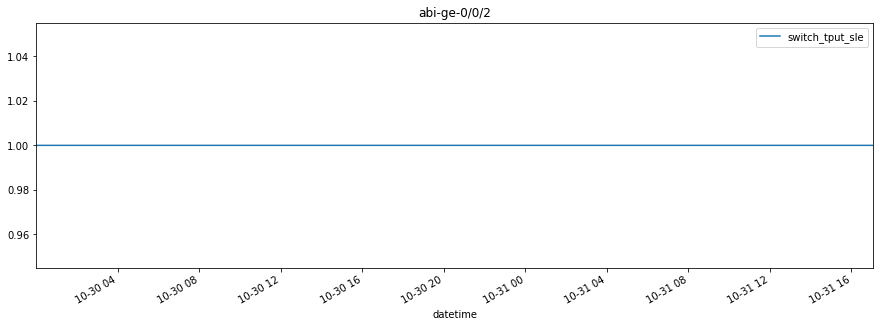

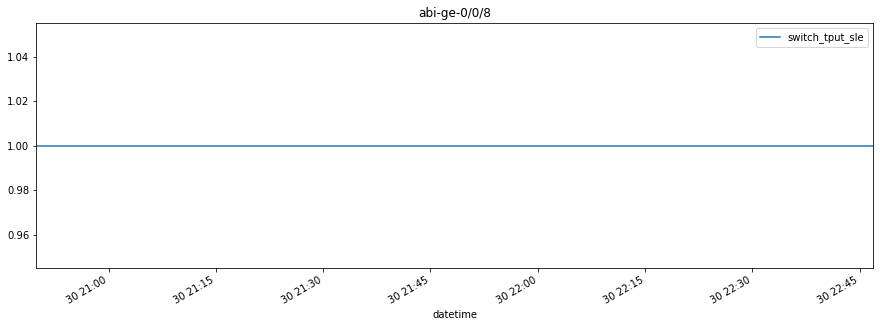

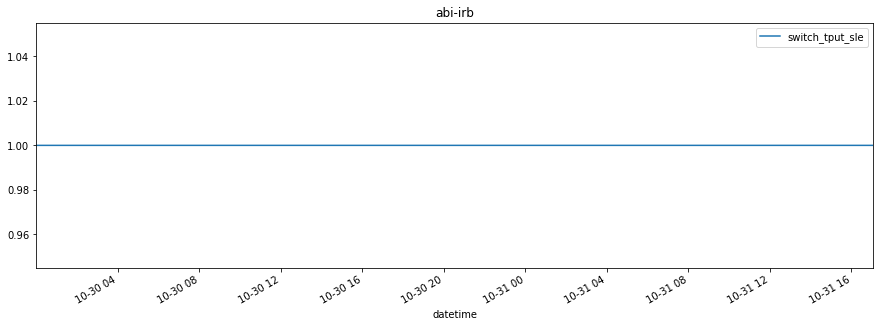

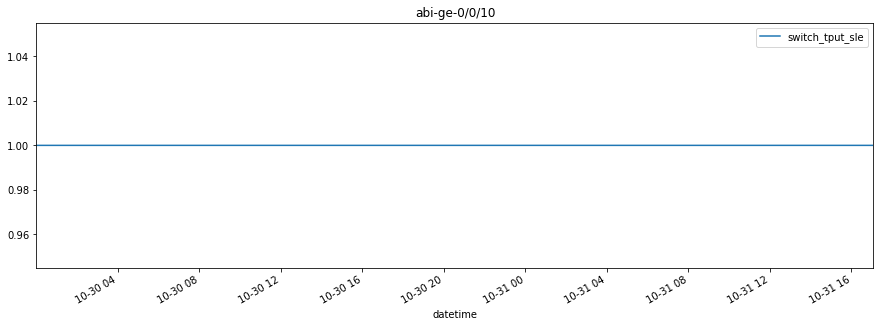

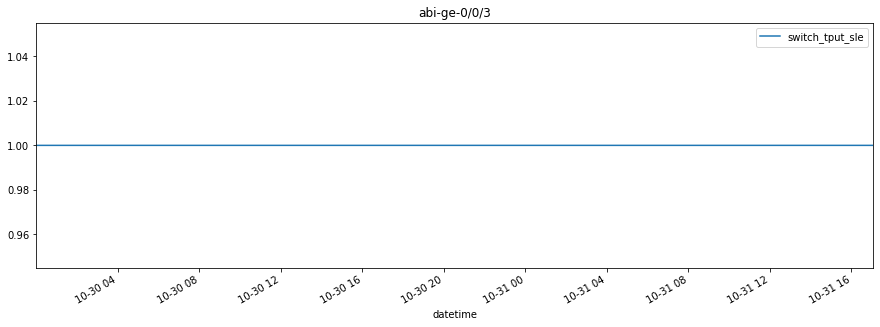

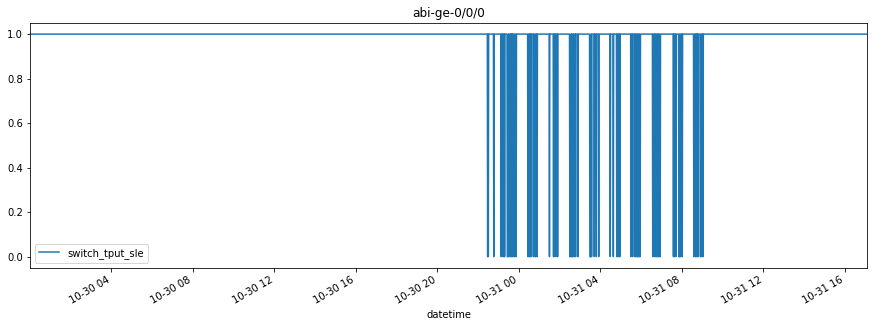

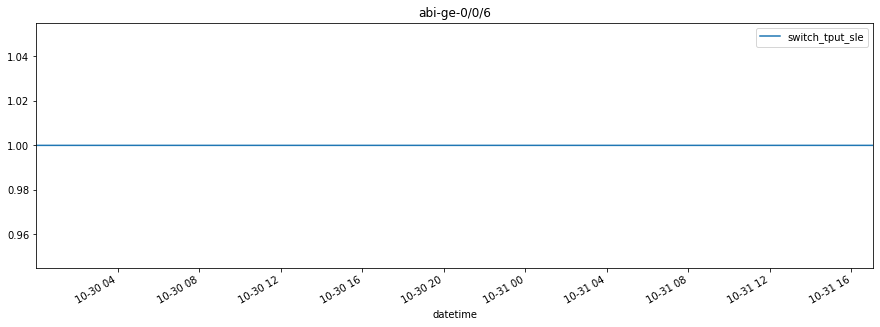

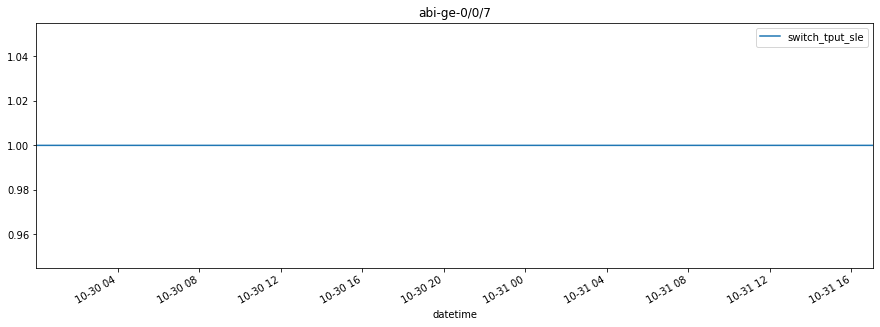

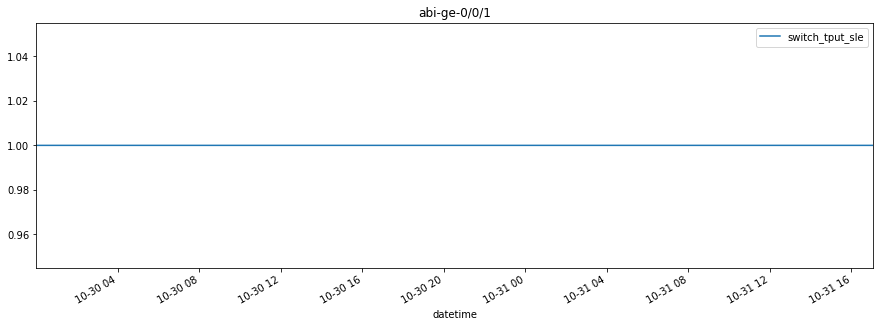

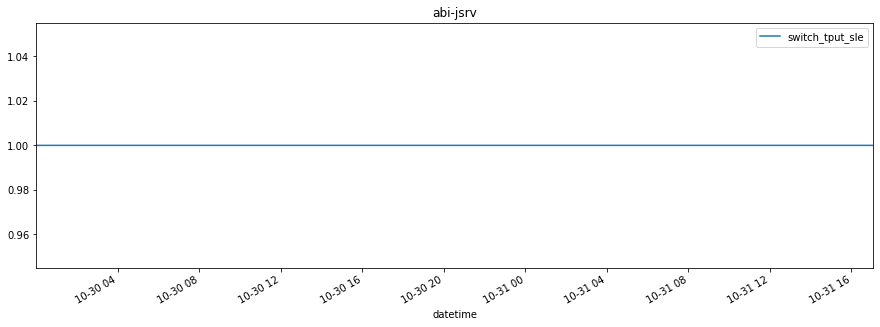

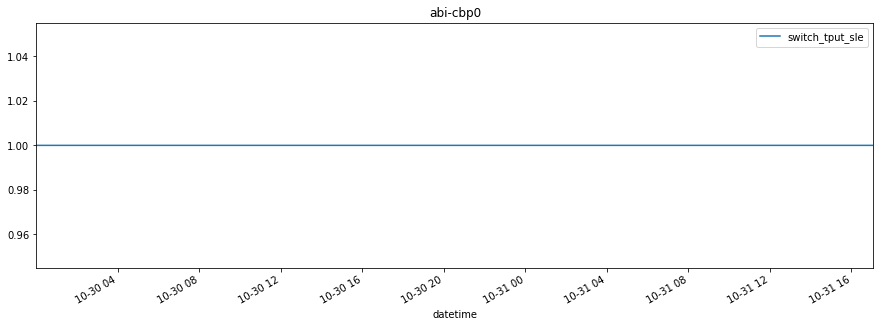

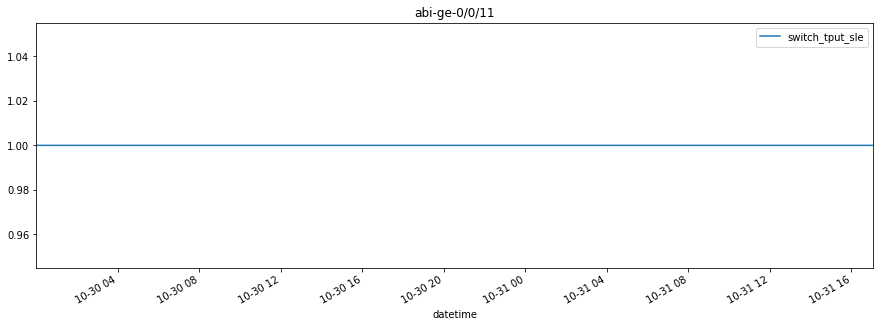

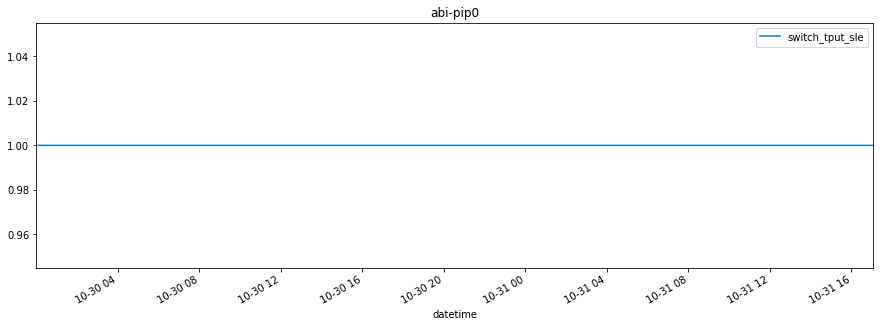

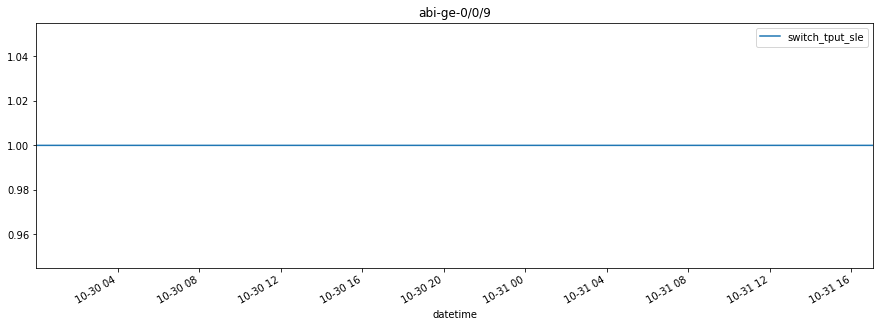

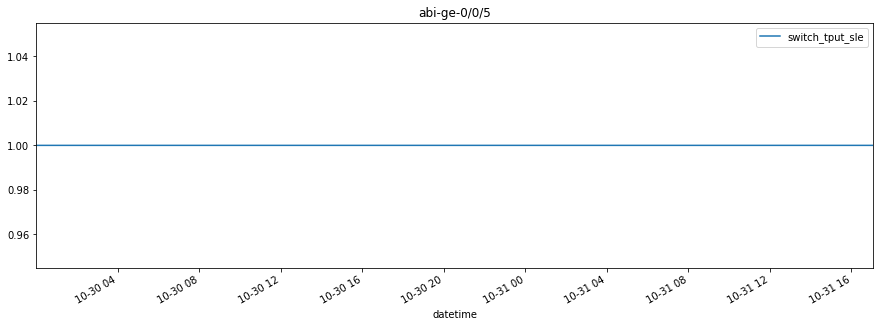

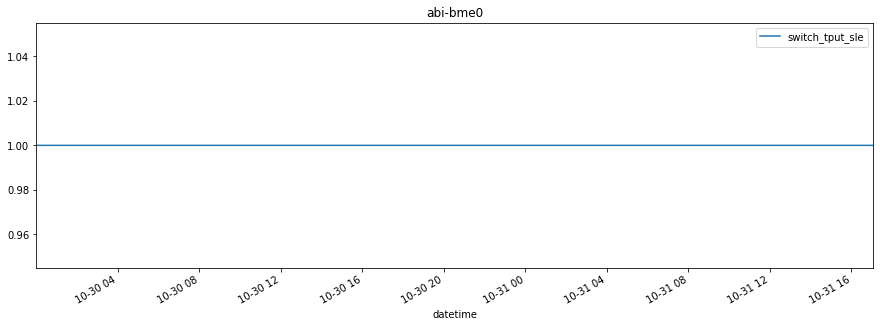

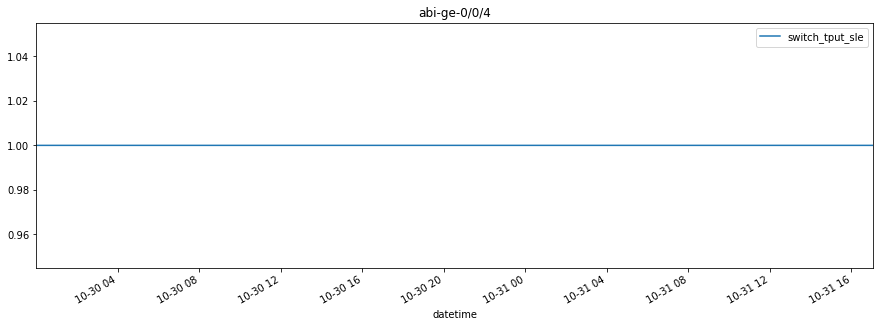

In [16]:
df_abi = df_pd[df_pd['id']==abi_switch]

names = set(df_abi['name'])
for name in names:
    df_link = df_abi[df_abi['name']==name]
    df_link.plot(x="datetime", y = ['switch_tput_sle'], subplots=True, figsize=(15, 5))
    plt.title("abi-"+name)



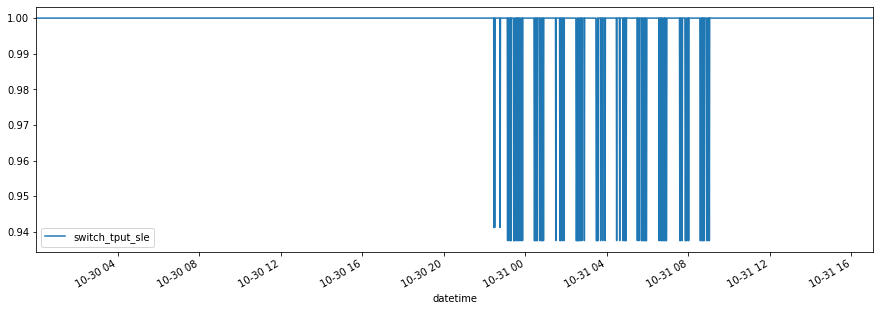

In [18]:
df_abi_g = df_abi[[ 'datetime', 'switch_tput_sle']].groupby('datetime').mean()
# df_abi.columns
df_abi_g.plot(figsize=(15, 5))

In [19]:
# df_abi.head()

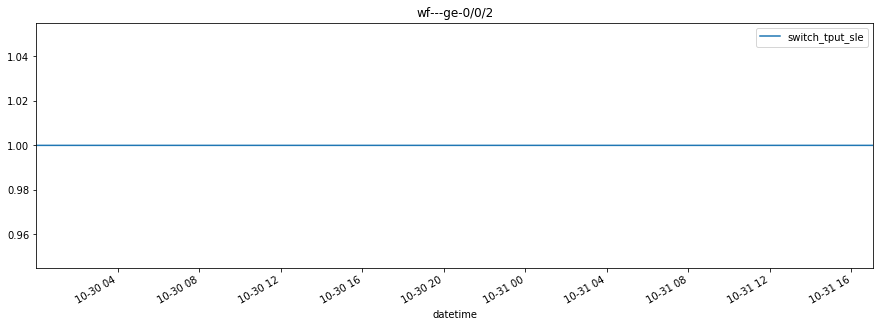

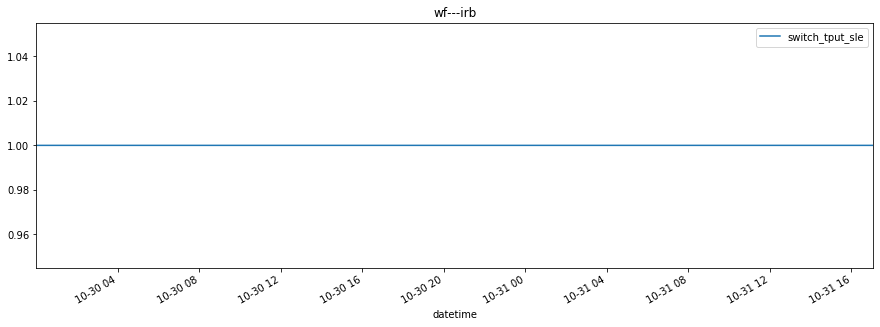

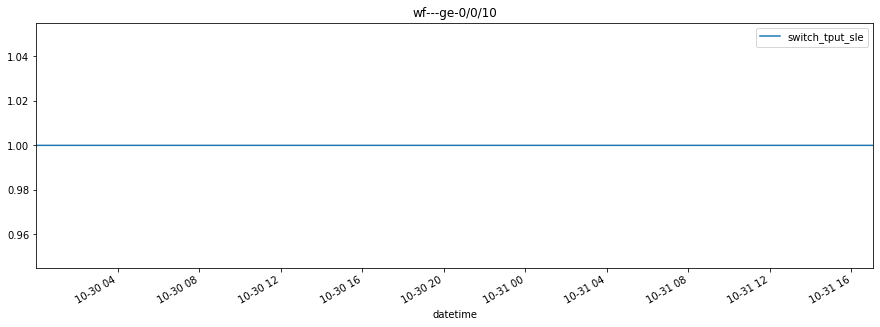

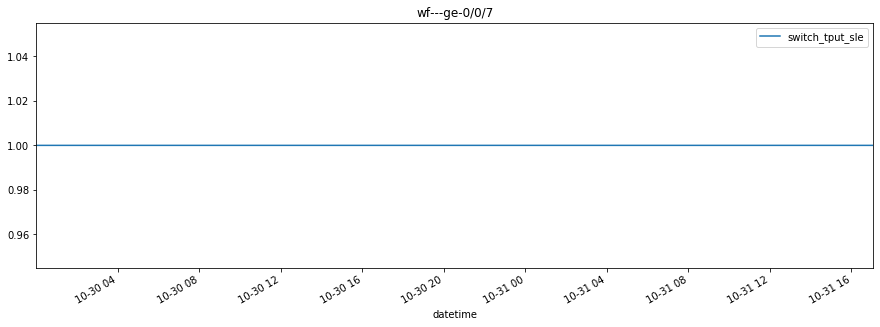

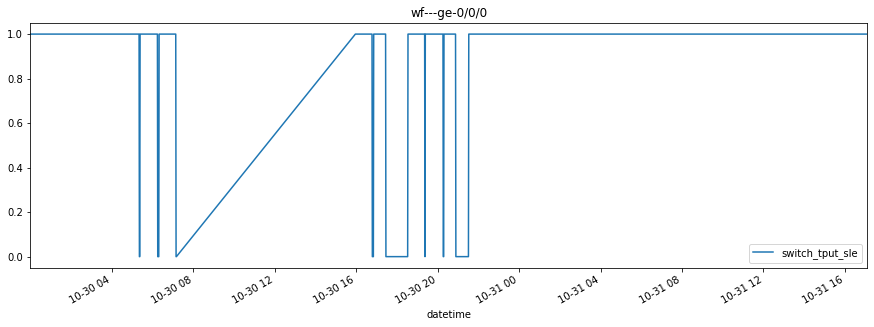

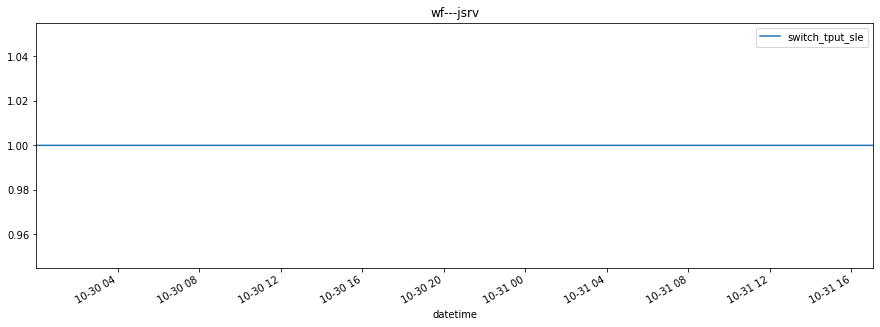

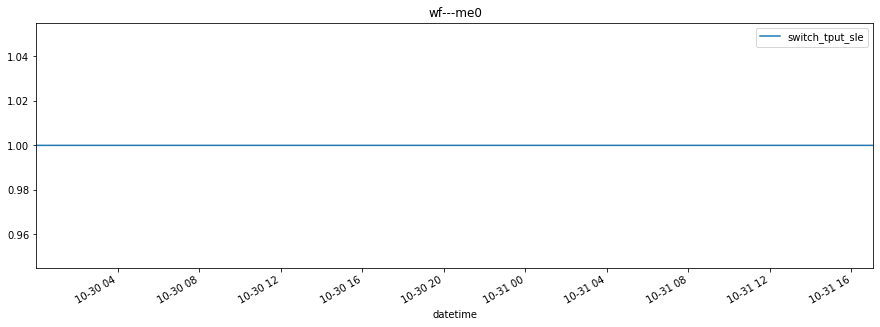

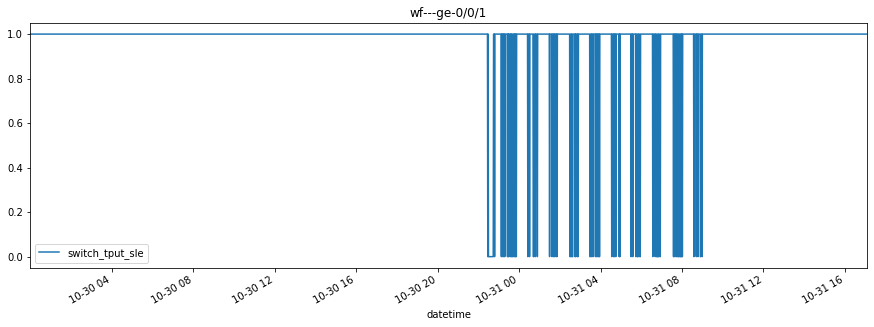

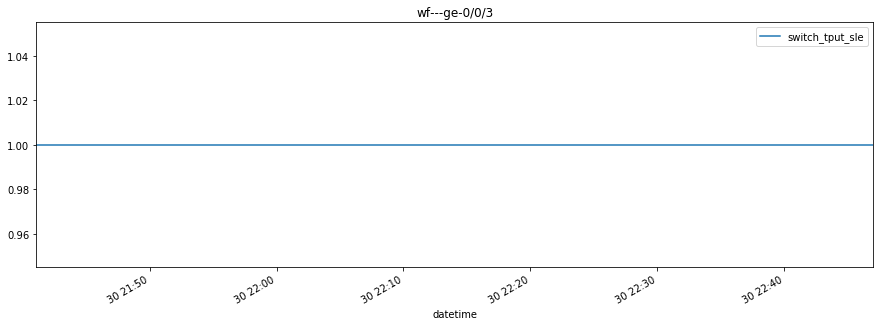

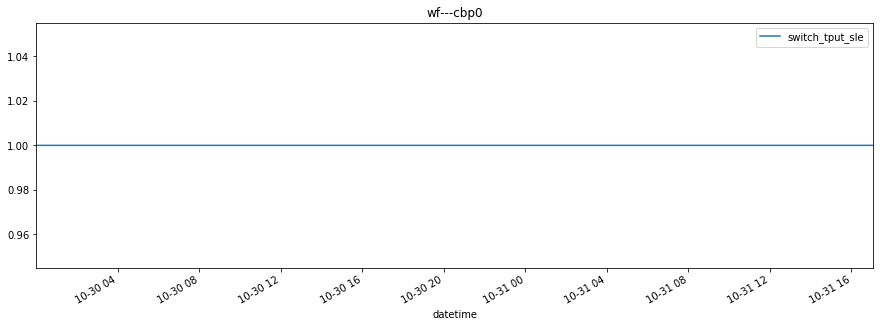

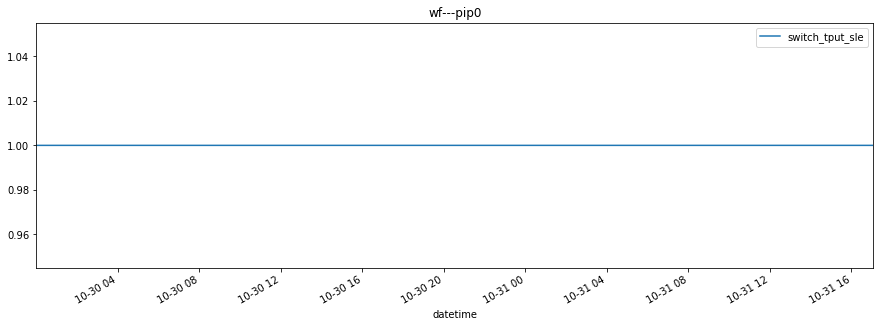

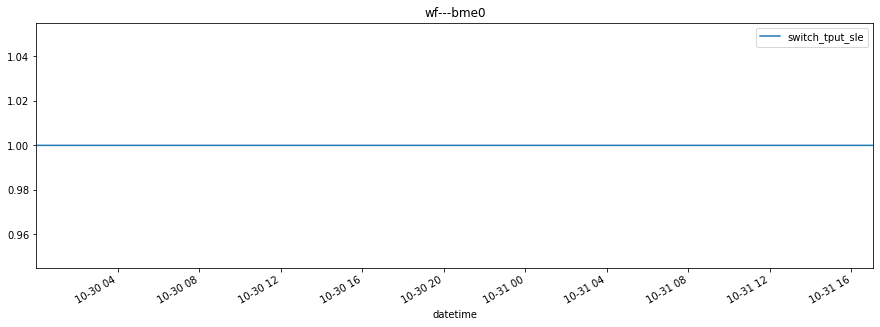

In [20]:
df_wf = df_pd[df_pd['id']==wf_switch]

names = set(df_wf['name'])
for name in names:
    df_link = df_wf[df_wf['name']==name]
    df_link.plot(x="datetime", y = ['switch_tput_sle'], subplots=True, figsize=(15, 5))
    plt.title("wf---"+name)



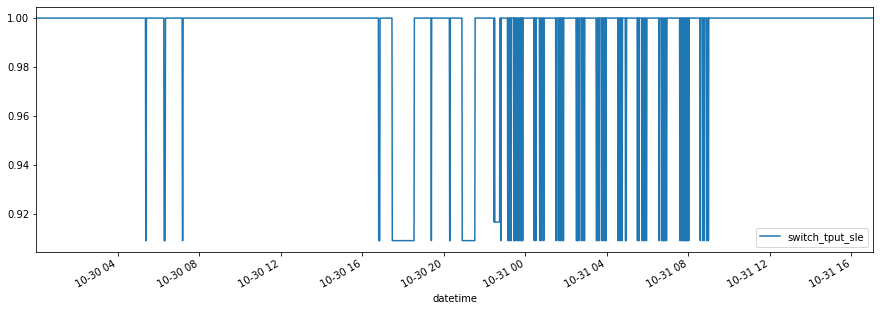

In [21]:
df_wf_g = df_wf[[ 'datetime', 'switch_tput_sle']].groupby('datetime').mean()
# df_abi.columns
df_wf_g.plot(figsize=(15, 5))

In [22]:
# (kind="scatter", x="tx_bps_ratio", y = "tx_drops_ratio", figsize=(10, 10))

In [23]:
df_pd.columns

Index(['id', 'when', 'org_id', 'site_id', 'name', 'link', 'full_duplex',
       'mbps', 'mtu', 'address', 'admin_status', 'last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta', 'rx_l3_incompletes', 'rx_l2_channel_error',
       'rx_l2_mismatch_timeouts', 'rx_fifo_errors', 'rx_resource_errors',
       'auto_negotiation_status', 'media_type', 'datetime', 'tx_bps_ratio',
       'tx_drops_ratio', 'switch_tput_sle'],
      dtype='object')

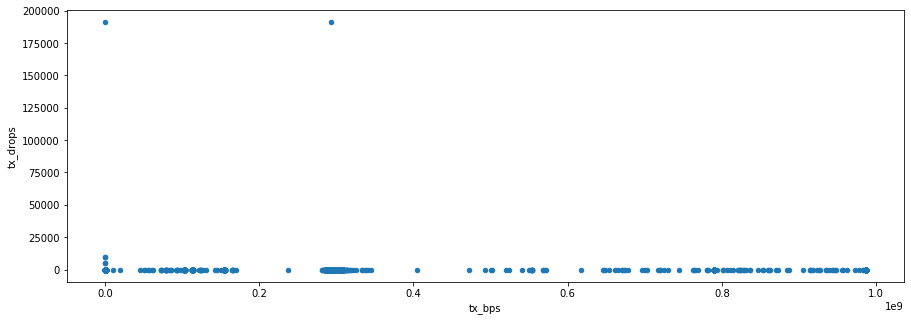

In [24]:
df_abi.plot(kind="scatter", x="tx_bps", y='tx_drops', figsize=(15, 5))


Text(0.5, 1.0, 'wf-switch')

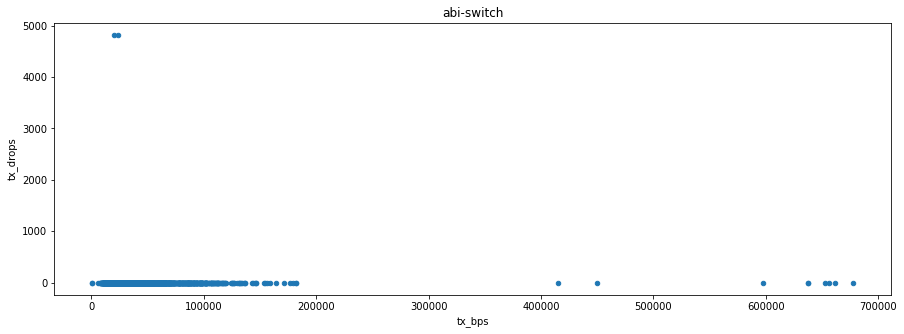

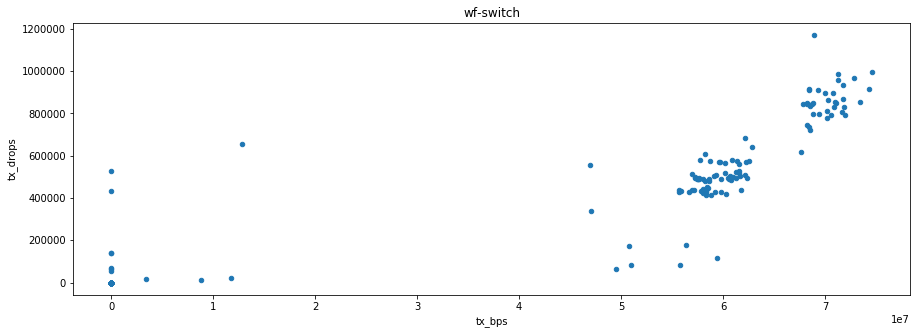

In [25]:
df_abi[df_abi['mbps']==100].plot(kind="scatter", x="tx_bps", y='tx_drops', figsize=(15, 5))
plt.title("abi-switch")

df_wf[df_wf['mbps']==100].plot(kind="scatter", x="tx_bps", y='tx_drops', figsize=(15, 5))
plt.title("wf-switch")

Text(0.5, 1.0, 'wf-switch')

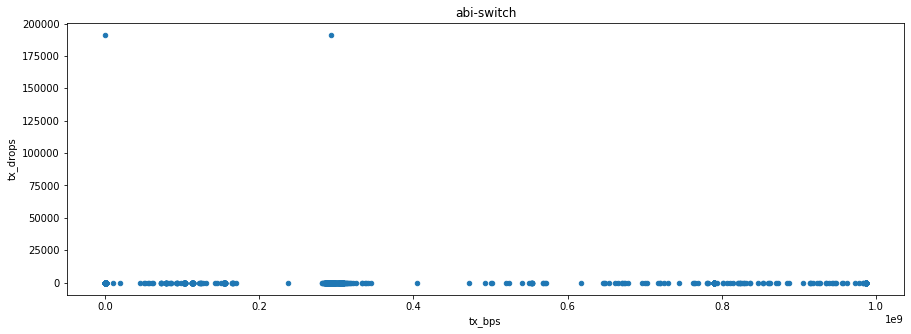

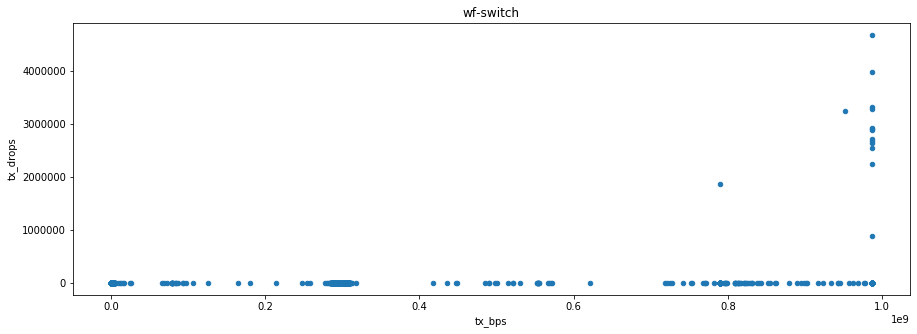

In [26]:
df_abi[df_abi['mbps']==1000].plot(kind="scatter", x="tx_bps", y='tx_drops', figsize=(15, 5))
plt.title("abi-switch")

df_wf[df_wf['mbps']==1000].plot(kind="scatter", x="tx_bps", y='tx_drops', figsize=(15, 5))
plt.title("wf-switch")

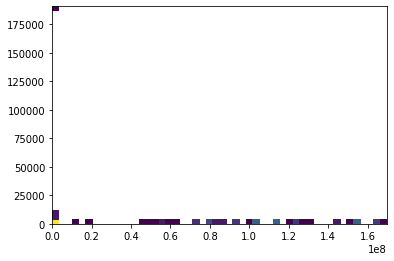

In [27]:
df_t = df_abi[df_abi['tx_bps']<2.0e8]

h2 = plt.hist2d(df_t['tx_bps'], df_t['tx_drops'], norm=mpl.colors.LogNorm(), bins=(50, 50))


In [28]:
df_link.columns

Index(['id', 'when', 'org_id', 'site_id', 'name', 'link', 'full_duplex',
       'mbps', 'mtu', 'address', 'admin_status', 'last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta', 'rx_l3_incompletes', 'rx_l2_channel_error',
       'rx_l2_mismatch_timeouts', 'rx_fifo_errors', 'rx_resource_errors',
       'auto_negotiation_status', 'media_type', 'datetime', 'tx_bps_ratio',
       'tx_drops_ratio', 'switch_tput_sle'],
      dtype='object')

In [29]:
ylabs =['name', 'link', 'full_duplex',
       'mbps', 'mtu',  'admin_status', 'rx_packets','tx_packets','poe_enabled', 'poe_status', 'poe_mode', 'last_flapped', 'errors','interface_counter_delta']
# df_wf[df_wf['name']=="ge-0/0/0"][['rx_packets','tx_packets','poe_enabled', 'poe_status', 'poe_mode','admin_statu
df_pd[ylabs]['mbps'].unique()

array([1000,  100,   10,    0])

In [30]:
df_pd[df_pd['mbps']==800]['name'].unique()

array([], dtype=object)

In [31]:
df_wf['mbps'].unique()
df_wf[df_wf['mbps']==800]['name'].unique()

array([], dtype=object)

In [32]:
set(df_wf.name)

{'bme0',
 'cbp0',
 'ge-0/0/0',
 'ge-0/0/1',
 'ge-0/0/10',
 'ge-0/0/2',
 'ge-0/0/3',
 'ge-0/0/7',
 'irb',
 'jsrv',
 'me0',
 'pip0'}

In [103]:
names = set(df_wf['name'])
for name in names:
    if name.find("ge-")<0:
        df_link = df_wf[df_wf['name']==name]
        print("port-name: ", name)
        print(df_link[ylabs].head())

port-name:  jsrv
     name  link  full_duplex  mbps   mtu  admin_status  rx_packets  \
7    jsrv  True        False     0  1514          True           0   
33   jsrv  True        False     0  1514          True           0   
59   jsrv  True        False     0  1514          True           0   
85   jsrv  True        False     0  1514          True           0   
111  jsrv  True        False     0  1514          True           0   

     tx_packets  poe_enabled  poe_status poe_mode       last_flapped errors  \
7             0        False       False          -62135596800000000     []   
33            0        False       False          -62135596800000000     []   
59            0        False       False          -62135596800000000     []   
85            0        False       False          -62135596800000000     []   
111           0        False       False          -62135596800000000     []   

     interface_counter_delta  
7                       True  
33                      T

port-name:  gre
    name  link  full_duplex  mbps   mtu  admin_status  rx_packets  tx_packets  \
348  gre  True        False     0  1500          True           0           0   
393  gre  True        False     0  1500          True           0           0   
438  gre  True        False     0  1500          True           0           0   
483  gre  True        False     0  1500          True           0           0   
528  gre  True        False     0  1500          True           0           0   

     poe_enabled  poe_status poe_mode       last_flapped errors  \
348        False       False          -62135596800000000     []   
393        False       False          -62135596800000000     []   
438        False       False          -62135596800000000     []   
483        False       False          -62135596800000000     []   
528        False       False          -62135596800000000     []   

     interface_counter_delta  
348                     True  
393                     True  
4

port-name:  dsc
    name  link  full_duplex  mbps   mtu  admin_status  rx_packets  tx_packets  \
346  dsc  True        False     0  1500          True           0           0   
391  dsc  True        False     0  1500          True           0           0   
436  dsc  True        False     0  1500          True           0           0   
481  dsc  True        False     0  1500          True           0           0   
526  dsc  True        False     0  1500          True           0           0   

     poe_enabled  poe_status poe_mode       last_flapped errors  \
346        False       False          -62135596800000000     []   
391        False       False          -62135596800000000     []   
436        False       False          -62135596800000000     []   
481        False       False          -62135596800000000     []   
526        False       False          -62135596800000000     []   

     interface_counter_delta  
346                     True  
391                     True  
4

In [89]:
set(df_wf[df_wf['mbps']==0].name)

{'.local.',
 'bme0',
 'cbp0',
 'dsc',
 'esi',
 'ge-0/0/0',
 'ge-0/0/1',
 'ge-0/0/10',
 'ge-0/0/2',
 'ge-0/0/5',
 'ge-0/0/6',
 'ge-0/0/7',
 'gre',
 'ipip',
 'irb',
 'jsrv',
 'lo0',
 'lsi',
 'mtun',
 'pimd',
 'pime',
 'pip0',
 'tap',
 'vme',
 'vtep'}

In [100]:
print(df_wf[df_wf['name']=="ge-0/0/0"].columns)
df_wf[df_wf['name']=="ge-0/0/0"][['rx_packets','tx_packets','poe_enabled', 'poe_status', 'poe_mode','admin_status']]

Index(['id', 'when', 'org_id', 'site_id', 'name', 'link', 'full_duplex',
       'mbps', 'mtu', 'address', 'admin_status', 'last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta', 'datetime', 'tx_bps_ratio', 'tx_drops_ratio',
       'sle'],
      dtype='object')


rx_packets  tx_packets  poe_enabled  poe_status poe_mode  admin_status
338             44          44         True        True                   True
383             49          49         True        True                   True
428             45          45         True        True                   True
473             44          44         True        True                   True
518             43          43         True        True                   True
...            ...         ...          ...         ...      ...           ...
323195          50          50         True        True                   True
323311          48          48         True        True                   True
323427           0          34         True       False                   True
323449          40          40         True        True                   True
323473          43          43         True        True                   True

[4354 rows x 6 columns]

In [53]:
# df1.select('id', 'org_id', 'site_id', 'when' ).show()

# df11 = df1.filter(col('id')==abi_switch).take(1) #.toPandas()
# df11 = df11[0].asDict()
# df11

In [8]:
# df11?

In [54]:
# df.columns

In [55]:
# df1.select(col("hostname"), col("remote_addr")).take(10)
# df11

In [11]:

df1_i = df1.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("interfaces")).alias("interface")).select('id','when', 'org_id', 'site_id', 'interface.*')
df1_i.take(1)


[Row(id='80acacf2f530', when=1571924697753622, org_id='19163200-4a90-11e5-8b45-1258369c38a9', site_id='1916d52a-4a90-11e5-8b45-1258369c38a9', name='ge-0/0/0', link=True, full_duplex=True, mbps=0, mtu=1514, address='', admin_status=True, last_flapped=1571092023000000, errors=[], poe_enabled=True, poe_status=True, poe_power_limit=15.399999618530273, poe_power=5.800000190734863, poe_priority=False, poe_class='0', poe_mode='', rx_bytes=1610978, rx_bps=287288, rx_packets=5409, tx_bytes=841153, tx_bps=120120, tx_packets=5409, rx_errors=0, rx_undersize_errors=0, rx_oversize_errors=0, rx_fcserrors=0, rx_overrun_errors=0, rx_discards=0, tx_errors=0, tx_drops=0, tx_mtuerrors=0, txcarrier_transition=0, tx_mcast_packets=406707, tx_bcast_packets=119178, rx_mcast_packets=14558421, rx_bcast_packets=119178, interface_counter_delta=True, rx_l3_incompletes=0, rx_l2_channel_error=0, rx_l2_mismatch_timeouts=0, rx_fifo_errors=0, rx_resource_errors=0, auto_negotiation_status='\ncomplete\n', media_type='copp

In [12]:
import pandas as pd
df1_i = df1.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("interfaces")).alias("interface")).select('id','when', 'org_id', 'site_id', 'interface.*')
df1_i.take(1)

df_pd = df1_i.filter(col("link")==True).toPandas()

df_pd['datetime'] = [ pd.Timestamp(x*1000) for x in df_pd['when']]
df_pd.head()

id              when                                org_id  \
0  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   
1  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   
2  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   
3  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   
4  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   

                                site_id      name  link  full_duplex  mbps  \
0  1916d52a-4a90-11e5-8b45-1258369c38a9  ge-0/0/0  True         True     0   
1  1916d52a-4a90-11e5-8b45-1258369c38a9  ge-0/0/1  True         True     0   
2  1916d52a-4a90-11e5-8b45-1258369c38a9  ge-0/0/8  True         True     0   
3  1916d52a-4a90-11e5-8b45-1258369c38a9  ge-0/0/9  True         True     0   
4  1916d52a-4a90-11e5-8b45-1258369c38a9      bme0  True        False     0   

    mtu address  ...  rx_bcast_packets  interface_counter_delta  \
0  1514          ...            119178                     True   
1  1514          ...          11727720                     True   
2  1514          ...           4198497                     True   
3  1514          ...          11654540                     True   
4  9512          ...                 0                     True   

  rx_l3_incompletes  rx_l2_channel_error  rx_l2_mismatch_timeouts  \
0                 0                    0                        0   
1                 0                    0                        0   
2                 0                    0                        0   
3                 0                    0                        0   
4                 0                    0                        0   

   rx_fifo_errors  rx_resource_errors  auto_negotiation_status media_type  \
0               0                   0             \ncomplete\n     copper   
1               0                   0             \ncomplete\n     copper   
2               0                   0             \ncomplete\n     copper   
3               0                   0             \ncomplete\n     copper   
4               0                   0           not applicable              

                    datetime  
0 2019-10-24 13:44:57.753622  
1 2019-10-24 13:44:57.753622  
2 2019-10-24 13:44:57.753622  
3 2019-10-24 13:44:57.753622  
4 2019-10-24 13:44:57.753622  

[5 rows x 49 columns]

In [13]:
df_pd.to_csv("wire.csv")

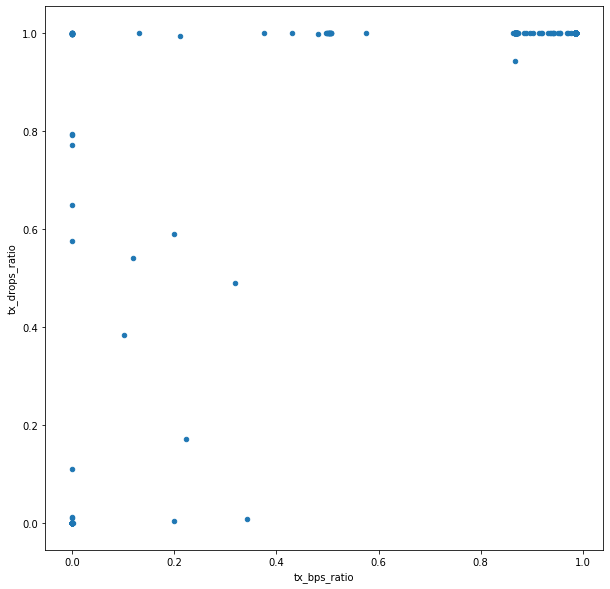

In [14]:

# df_t = pd.read_csv("wire.csv")
# df_t.head()
df_pd["tx_bps_ratio"]= df_pd['tx_bps']/df_pd['mbps']/1.e6
df_pd['tx_drops_ratio'] = df_pd['tx_drops']/(df_pd["tx_packets"] + df_pd['tx_drops'])
df_t = df_pd[df_pd['mbps']>0]

# h2 = plt.hist2d(df_t["tmp"], df_t["tx_drops_ratio"], norm=mpl.colors.LogNorm())

# plt.hist(df_pd['tx_drops_ratio'])
# plt.hist(df_t["tx_drops_ratio"])

df_t.plot(kind="scatter", x="tx_bps_ratio", y = "tx_drops_ratio", figsize=(10, 10))
# plt.hist2d(df_t['tx_bps_ratio'], df_t['tx_drops_ratio'])

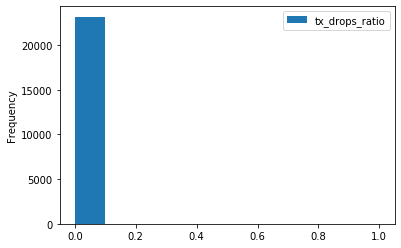

In [15]:
df_t[df_t['tx_bps_ratio']<0.5].plot(kind='hist', y='tx_drops_ratio')

In [16]:
# plt.hist2d(df_t['tx_bps_ratio'], df_t['tx_drops_ratio'])

In [17]:
# SLE per interface

# Aggregation 

# df1.printSchema()
df_pd.head()

id              when                                org_id  \
0  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   
1  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   
2  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   
3  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   
4  80acacf2f530  1571924697753622  19163200-4a90-11e5-8b45-1258369c38a9   

                                site_id      name  link  full_duplex  mbps  \
0  1916d52a-4a90-11e5-8b45-1258369c38a9  ge-0/0/0  True         True     0   
1  1916d52a-4a90-11e5-8b45-1258369c38a9  ge-0/0/1  True         True     0   
2  1916d52a-4a90-11e5-8b45-1258369c38a9  ge-0/0/8  True         True     0   
3  1916d52a-4a90-11e5-8b45-1258369c38a9  ge-0/0/9  True         True     0   
4  1916d52a-4a90-11e5-8b45-1258369c38a9      bme0  True        False     0   

    mtu address  ...  rx_l3_incompletes  rx_l2_channel_error  \
0  1514          ...                  0                    0   
1  1514          ...                  0                    0   
2  1514          ...                  0                    0   
3  1514          ...                  0                    0   
4  9512          ...                  0                    0   

  rx_l2_mismatch_timeouts  rx_fifo_errors  rx_resource_errors  \
0                       0               0                   0   
1                       0               0                   0   
2                       0               0                   0   
3                       0               0                   0   
4                       0               0                   0   

   auto_negotiation_status  media_type                   datetime  \
0             \ncomplete\n      copper 2019-10-24 13:44:57.753622   
1             \ncomplete\n      copper 2019-10-24 13:44:57.753622   
2             \ncomplete\n      copper 2019-10-24 13:44:57.753622   
3             \ncomplete\n      copper 2019-10-24 13:44:57.753622   
4           not applicable             2019-10-24 13:44:57.753622   

  tx_bps_ratio tx_drops_ratio  
0          inf            0.0  
1          inf            0.0  
2          inf            0.0  
3          inf            0.0  
4          NaN            NaN  

[5 rows x 51 columns]

In [18]:
# df_pd.plot(x='when', y = "tx_bps", )
df_pd.columns

Index(['id', 'when', 'org_id', 'site_id', 'name', 'link', 'full_duplex',
       'mbps', 'mtu', 'address', 'admin_status', 'last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta', 'rx_l3_incompletes', 'rx_l2_channel_error',
       'rx_l2_mismatch_timeouts', 'rx_fifo_errors', 'rx_resource_errors',
       'auto_negotiation_status', 'media_type', 'datetime', 'tx_bps_ratio',
       'tx_drops_ratio'],
      dtype='object')

In [19]:
# df_pd['name']

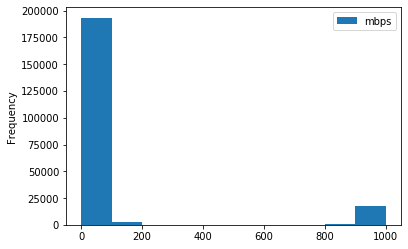

In [20]:
df_pd.plot(kind="hist", y="mbps")

In [21]:
ylabs = ['last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       #'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta']
df_pd[(df_pd['mbps']==0)&(df_pd['tx_bps']>0)][ylabs].describe()

last_flapped  poe_power_limit     poe_power      rx_bytes  \
count  6.416900e+04     64169.000000  64169.000000  6.416900e+04   
mean   1.229506e+15        17.827972      4.121741  6.426088e+07   
std    6.482556e+14         4.258549      4.937343  1.509223e+09   
min    3.170000e+08        15.400000      0.000000  0.000000e+00   
25%    1.569260e+15        15.400000      0.000000  9.255000e+03   
50%    1.571337e+15        15.400000      0.000000  3.781800e+04   
75%    1.571788e+15        19.500000      9.800000  3.445470e+05   
max    1.571962e+15        30.000000     35.200001  2.437998e+11   

             rx_bps    rx_packets      tx_bytes        tx_bps    tx_packets  \
count  6.416900e+04  6.416900e+04  6.416900e+04  6.416900e+04  6.416900e+04   
mean   6.913053e+06  5.298151e+04  2.255752e+07  1.408913e+06  5.178643e+04   
std    7.698015e+07  1.405631e+06  1.100660e+09  2.733192e+07  1.062690e+06   
min    0.000000e+00  0.000000e+00  6.300000e+02  4.800000e+01  0.000000e+00   
25%    8.080000e+02  4.100000e+01  7.480400e+04  2.496000e+03  4.100000e+01   
50%    5.184000e+03  1.420000e+02  2.864470e+05  1.584800e+04  1.420000e+02   
75%    4.074400e+04  2.521000e+03  8.581420e+05  7.573600e+04  2.521000e+03   
max    9.685461e+08  1.624640e+08  1.737009e+11  9.666578e+08  1.198241e+08   

          rx_errors  rx_undersize_errors  rx_oversize_errors  rx_fcserrors  \
count  64169.000000              64169.0             64169.0  64169.000000   
mean       0.001605                  0.0                 0.0      0.001590   
std        0.181027                  0.0                 0.0      0.180034   
min        0.000000                  0.0                 0.0      0.000000   
25%        0.000000                  0.0                 0.0      0.000000   
50%        0.000000                  0.0                 0.0      0.000000   
75%        0.000000                  0.0                 0.0      0.000000   
max       37.000000                  0.0                 0.0     37.000000   

       tx_mtuerrors  txcarrier_transition  tx_mcast_packets  tx_bcast_packets  \
count       64169.0          64169.000000      6.416900e+04      6.416900e+04   
mean            0.0              0.008836      4.700328e+06      4.451307e+06   
std             0.0              0.713731      8.131096e+06      8.461451e+06   
min             0.0              0.000000      6.000000e+00      1.000000e+00   
25%             0.0              0.000000      1.826000e+05      1.415700e+05   
50%             0.0              0.000000      5.872180e+05      3.068940e+05   
75%             0.0              0.000000      7.131347e+06      6.714755e+06   
max             0.0            123.000000      4.189333e+07      4.104928e+07   

       rx_mcast_packets  rx_bcast_packets  
count      6.416900e+04      6.416900e+04  
mean       5.580877e+06      4.451307e+06  
std        1.277704e+07      8.461451e+06  
min        0.000000e+00      1.000000e+00  
25%        3.315000e+03      1.415700e+05  
50%        2.217000e+04      3.068940e+05  
75%        3.443140e+05      6.714755e+06  
max        4.920022e+07      4.104928e+07

In [22]:
# links ={}
# for x in df_pd.

In [23]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(15,7))

# df_pd.groupby('name').plot(x='datetime', y = "tx_bps", ax=ax)
# ['rx_errors']

In [24]:
df_pd.columns

Index(['id', 'when', 'org_id', 'site_id', 'name', 'link', 'full_duplex',
       'mbps', 'mtu', 'address', 'admin_status', 'last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta', 'rx_l3_incompletes', 'rx_l2_channel_error',
       'rx_l2_mismatch_timeouts', 'rx_fifo_errors', 'rx_resource_errors',
       'auto_negotiation_status', 'media_type', 'datetime', 'tx_bps_ratio',
       'tx_drops_ratio'],
      dtype='object')

In [25]:
names = ['ge-0/0/0', 'ge-0/0/5', 'ge-0/0/6', 'ge-0/0/10']
ylabels = [ 
    #'rx_errors', 'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets']


In [26]:
for ylab in ylabels:
    print(ylab, df_pd[ylab].min(), df_pd[ylab].max(), df_pd[ylab].mean())

rx_overrun_errors 0 0 0.0
rx_discards 0 0 0.0
tx_errors 0 0 0.0
tx_drops 0 18740954 16181.001787586103
tx_mtuerrors 0 0 0.0
txcarrier_transition 0 123 0.0028358041329739443
tx_mcast_packets 0 41893330 1421070.7821531522
tx_bcast_packets 0 41049275 1352711.0508058176
rx_mcast_packets 0 49200224 1817419.863436845
rx_bcast_packets 0 41049275 1352711.0508058176


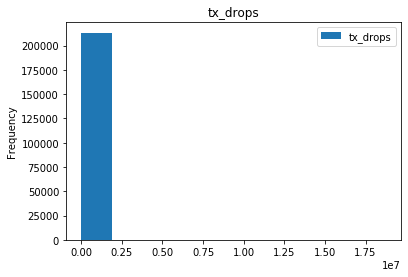

In [27]:
names = ['ge-0/0/0', 'ge-0/0/5', 'ge-0/0/6', 'ge-0/0/10']
ylabels = [ #'rx_erros',
           'tx_drops']


import matplotlib.pyplot as plt 
for ylab in ylabels:
    df_pd.plot(kind='hist', y=ylab)
    plt.title(ylab)

In [28]:
df_pd[df_pd['tx_drops']>0][['id', 'org_id', 'site_id', 'name', 'tx_drops']].groupby(['id','org_id', 'site_id', 'name']).count()

tx_drops
id           org_id                               site_id                              name               
0c8126c7054d b4e16c72-d50e-4c03-a952-a3217e231e2c 57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39 ge-0/0/1        416
                                                                                       ge-0/0/4         21
                                                                                       ge-0/0/6          3
0c8126c71290 4fa47e89-384f-4680-8699-a6df19715fd6                                      ge-0/0/11         1
                                                                                       ge-0/0/7          1
             b4e16c72-d50e-4c03-a952-a3217e231e2c 57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39 ge-0/0/11         8
                                                                                       ge-0/0/7          1
                                                  f688779c-e335-4f88-8d7c-9c5e9964528b ge-0/0/11         1
                                                                                       ge-0/0/7          1

In [29]:
df

DataFrame[id: string, mac: string, org_id: string, site_id: string, when: bigint, remote_addr: string, clients: array<struct<vlan_name:string,mac:string,flags:string,age:int,iface_name:string,vlan_id:int>>, hostname: string, model: string, firmware_version: string, interfaces: array<struct<name:string,link:boolean,full_duplex:boolean,mbps:int,mtu:int,address:string,admin_status:boolean,last_flapped:bigint,errors:array<struct<type:int,description:string,timestamp:bigint>>,poe_enabled:boolean,poe_status:boolean,poe_power_limit:float,poe_power:float,poe_priority:boolean,poe_class:string,poe_mode:string,rx_bytes:bigint,rx_bps:bigint,rx_packets:bigint,tx_bytes:bigint,tx_bps:bigint,tx_packets:bigint,rx_errors:int,rx_undersize_errors:int,rx_oversize_errors:int,rx_fcserrors:int,rx_overrun_errors:int,rx_discards:int,tx_errors:int,tx_drops:int,tx_mtuerrors:int,txcarrier_transition:int,tx_mcast_packets:bigint,tx_bcast_packets:bigint,rx_mcast_packets:bigint,rx_bcast_packets:bigint,interface_counte

In [30]:
df_pd.columns

Index(['id', 'when', 'org_id', 'site_id', 'name', 'link', 'full_duplex',
       'mbps', 'mtu', 'address', 'admin_status', 'last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta', 'rx_l3_incompletes', 'rx_l2_channel_error',
       'rx_l2_mismatch_timeouts', 'rx_fifo_errors', 'rx_resource_errors',
       'auto_negotiation_status', 'media_type', 'datetime', 'tx_bps_ratio',
       'tx_drops_ratio'],
      dtype='object')

In [31]:
#df_t[ylabels]
# ylabels
# df_t

In [32]:
ylabels


['tx_drops']

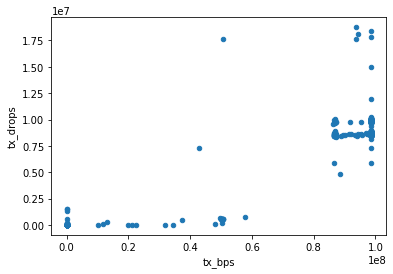

In [33]:
df_t.plot(kind="scatter", x="tx_bps", y='tx_drops')


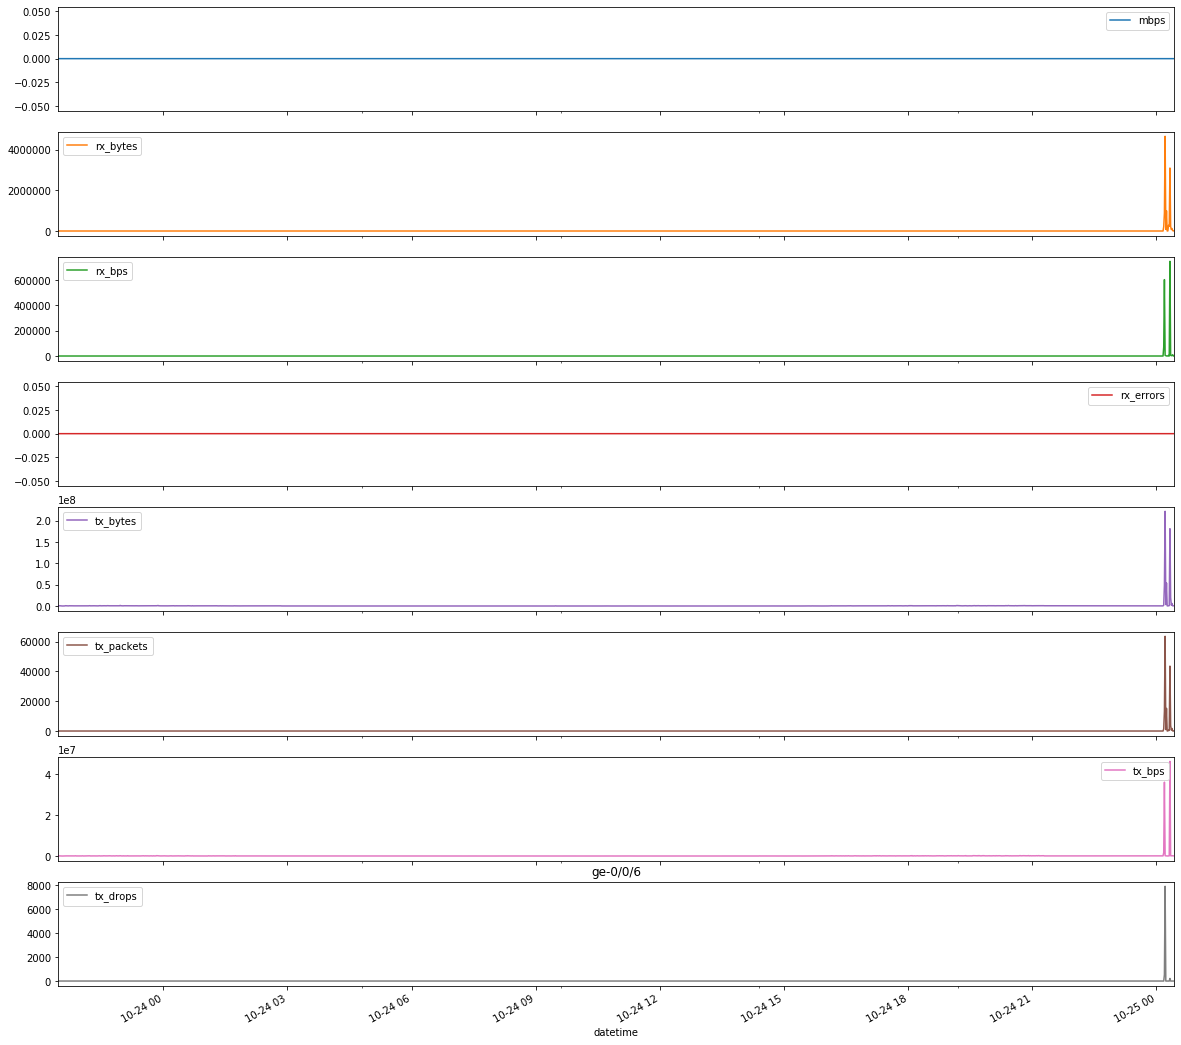

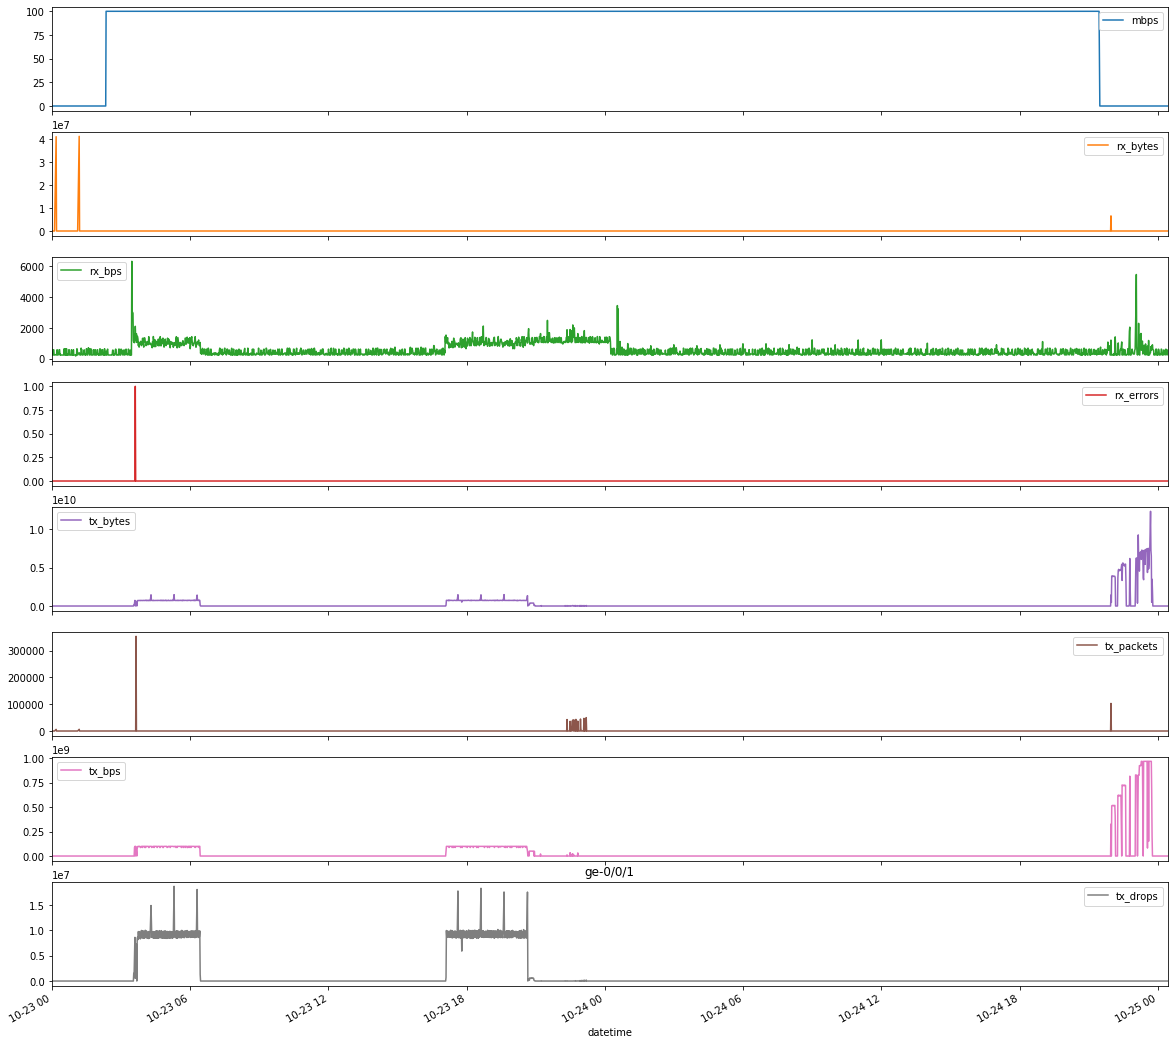

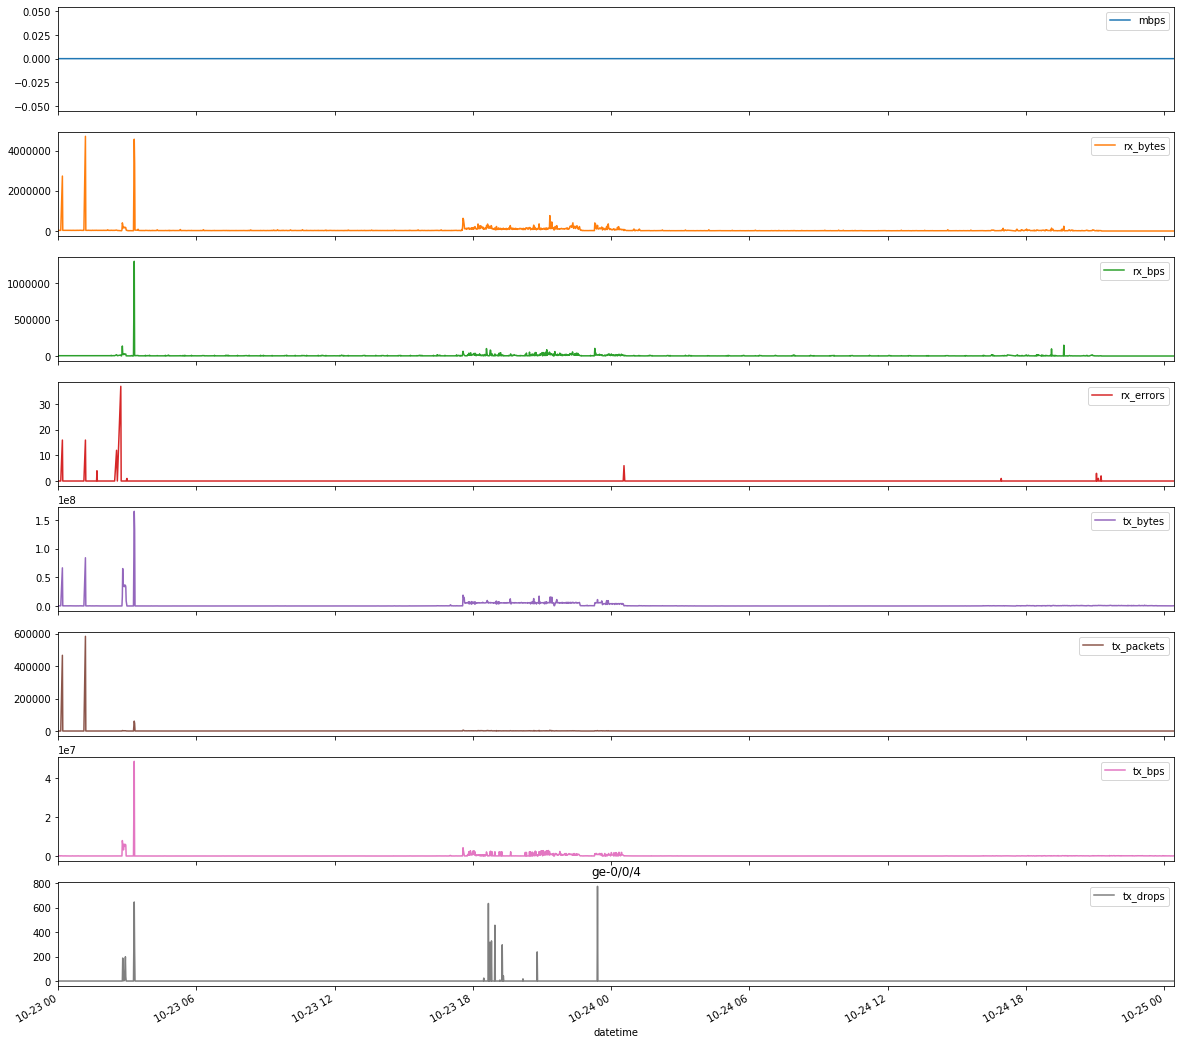

In [46]:
ylabs = ['mbps','rx_bytes', 'rx_bps', 'rx_errors',"tx_bytes", "tx_packets", "tx_bps", "tx_drops" ]
df_1 = df_pd[df_pd['id']=="0c8126c7054d"]
df_1 = df_1[df_1['link']==True]
names = set(df_1['name'])

for name in names:
    df_link = df_1[df_1['name']==name]
    if df_link['tx_drops'].max()> 0:
        df_1[df_1['name']==name].plot(x="datetime", y = ylabs, subplots=True, figsize=(20, 20))
        plt.title(name)
    

Text(0.5, 1.0, 'ge-0/0/1')

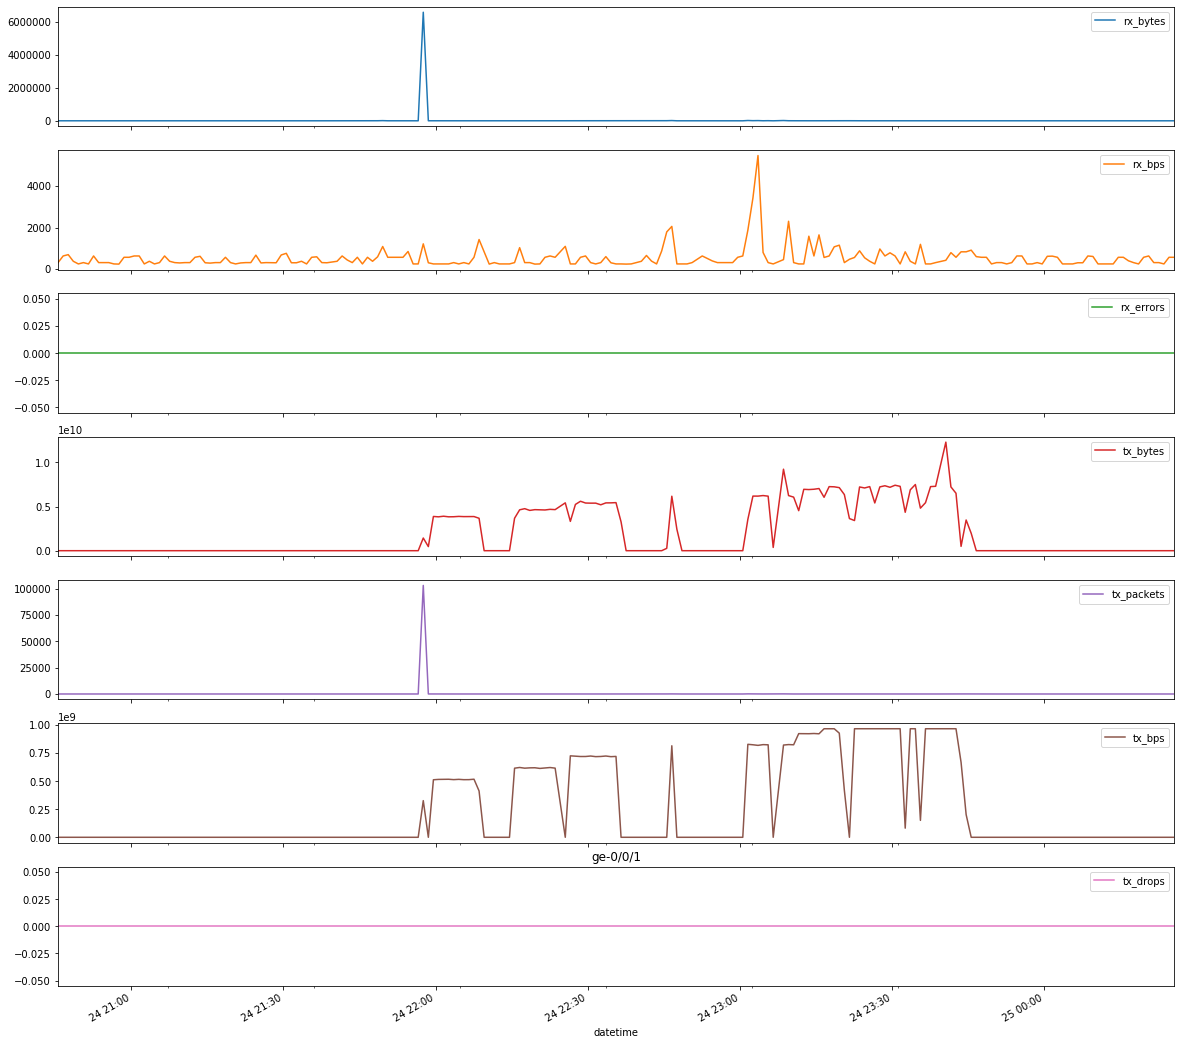

In [44]:
port_name = "ge-0/0/1"
df_abi_001 =df_1[(df_1['name']==port_name)&(df_1['datetime']>'2019-10-24 20:45:00')]


df_abi_001.plot(x="datetime", y = ylabs, subplots=True, figsize=(20, 20))
plt.title(port_name)
    

In [47]:
df_1['datetime'][:1]

51   2019-10-24 13:45:29.692804
Name: datetime, dtype: datetime64[ns]

In [52]:
df_abi_001.head(100)


id              when                                org_id  \
79194  0c8126c7054d  1571961996700417  b4e16c72-d50e-4c03-a952-a3217e231e2c   
79265  0c8126c7054d  1571962056700612  b4e16c72-d50e-4c03-a952-a3217e231e2c   
79336  0c8126c7054d  1571962116700876  b4e16c72-d50e-4c03-a952-a3217e231e2c   
79407  0c8126c7054d  1571962176701101  b4e16c72-d50e-4c03-a952-a3217e231e2c   
79479  0c8126c7054d  1571962236701300  b4e16c72-d50e-4c03-a952-a3217e231e2c   
...             ...               ...                                   ...   
97160  0c8126c7054d  1571953234302003  b4e16c72-d50e-4c03-a952-a3217e231e2c   
97225  0c8126c7054d  1571953294314148  b4e16c72-d50e-4c03-a952-a3217e231e2c   
97290  0c8126c7054d  1571953354314373  b4e16c72-d50e-4c03-a952-a3217e231e2c   
97355  0c8126c7054d  1571953414314605  b4e16c72-d50e-4c03-a952-a3217e231e2c   
97420  0c8126c7054d  1571953474314794  b4e16c72-d50e-4c03-a952-a3217e231e2c   

                                    site_id      name  link  full_duplex  \
79194  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   
79265  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   
79336  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   
79407  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   
79479  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   
...                                     ...       ...   ...          ...   
97160  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   
97225  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   
97290  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   
97355  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   
97420  57b2f891-09c1-4dcc-8ff1-2f9fb3ff7d39  ge-0/0/1  True         True   

       mbps   mtu address  ...  rx_l3_incompletes  rx_l2_channel_error  \
79194     0  1514          ...                  0                    0   
79265     0  1514          ...                  0                    0   
79336     0  1514          ...                  0                    0   
79407     0  1514          ...                  0                    0   
79479     0  1514          ...                  0                    0   
...     ...   ...     ...  ...                ...                  ...   
97160     0  1514          ...                  0                    0   
97225     0  1514          ...                  0                    0   
97290     0  1514          ...                  0                    0   
97355     0  1514          ...                  0                    0   
97420     0  1514          ...                  0                    0   

      rx_l2_mismatch_timeouts  rx_fifo_errors  rx_resource_errors  \
79194                       0               0                   0   
79265                       0               0                   0   
79336                       0               0                   0   
79407                       0               0                   0   
79479                       0               0                   0   
...                       ...             ...                 ...   
97160                       0               0                   0   
97225                       0               0                   0   
97290                       0               0                   0   
97355                       0               0                   0   
97420                       0               0                   0   

       auto_negotiation_status  media_type                   datetime  \
79194             \ncomplete\n      copper 2019-10-25 00:06:36.700417   
79265             \ncomplete\n      copper 2019-10-25 00:07:36.700612   
79336             \ncomplete\n      copper 2019-10-25 00:08:36.700876   
79407             \ncomplete\n      copper 2019-10-25 00:09:36.701101   
79479             \ncomplete\n      copper 2019-10-25 00:10:36.701300   

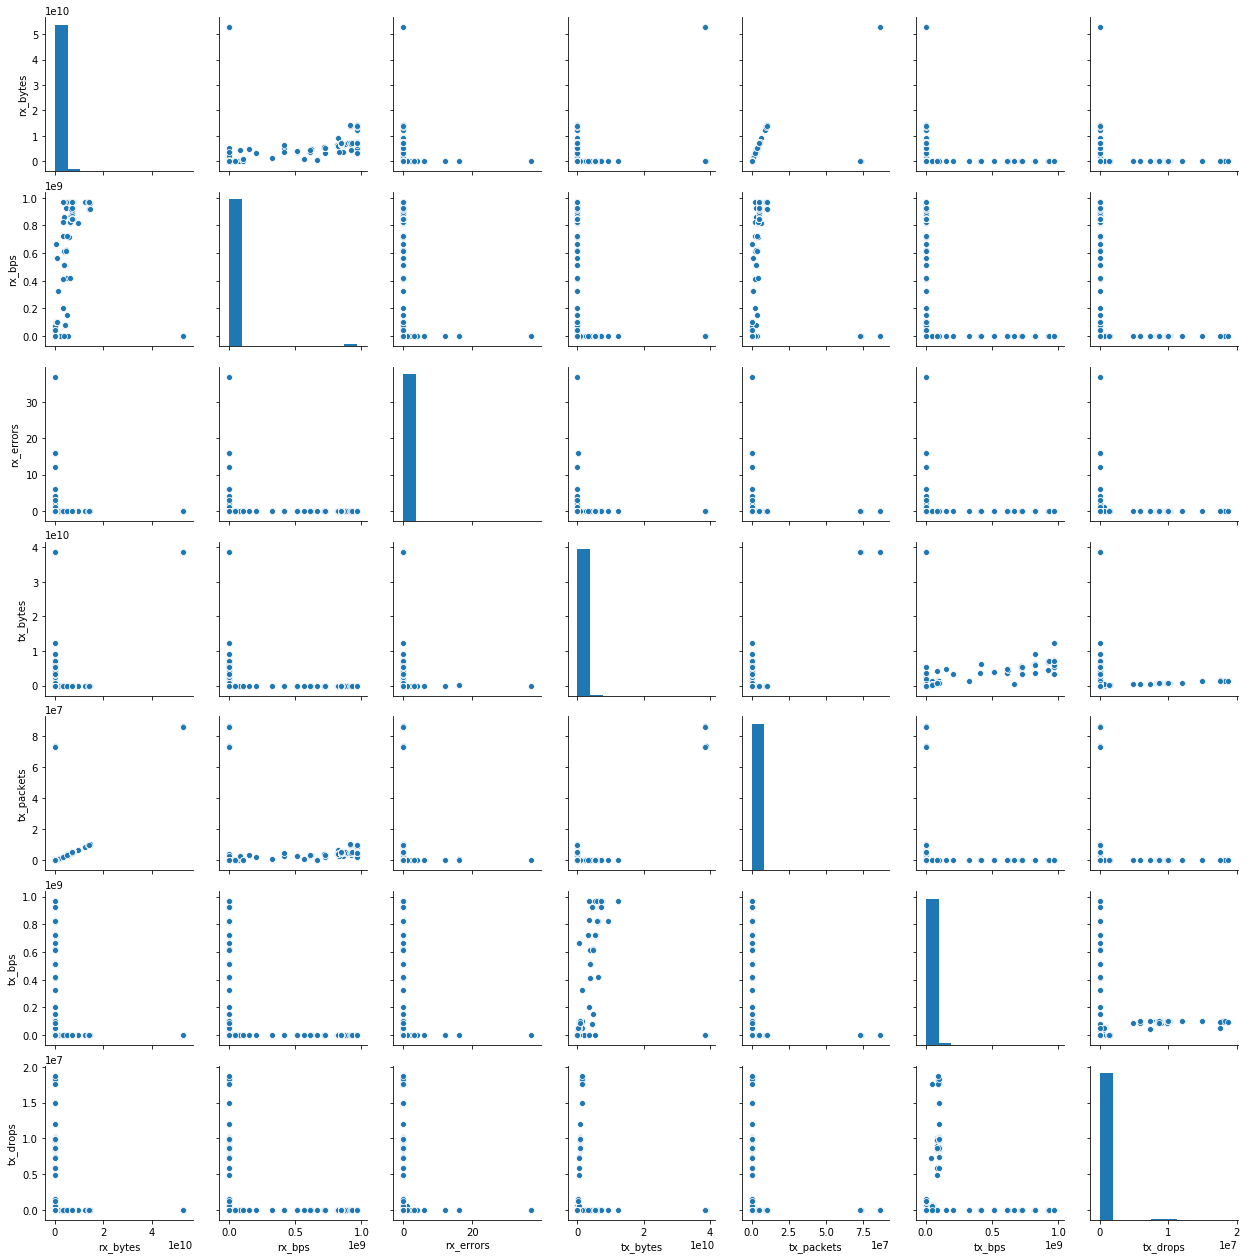

In [39]:
import seaborn as sns
# Create the default pairplot
sns.pairplot(df_1[ylabs])
# 

# !pip install seaborn

In [37]:
ylabels

['tx_drops']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e928290>],
      dtype=object)

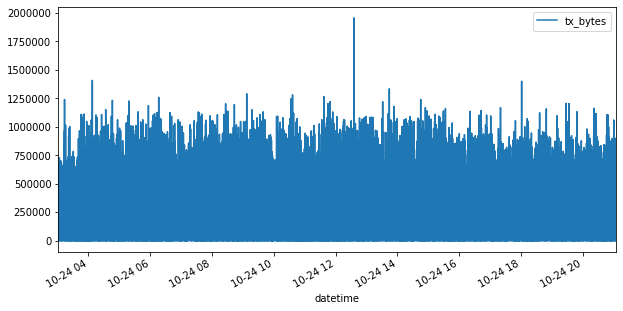

In [42]:
df_2 = df_1[(df_1['datetime']>'2019-10-24 03:00:55')&(df_1['datetime']<'2019-10-25 08:00:55')]
df_2.plot(x="datetime", y = ["tx_bytes" ], subplots=True, figsize=(10, 5))

In [43]:
df_1[df_1['rx_bytes']>0]['datetime'].min(), df_1[df_1['rx_bytes']>0]['datetime'].max()

(Timestamp('2019-10-22 23:59:55.120866'),
 Timestamp('2019-10-24 21:05:33.826455'))

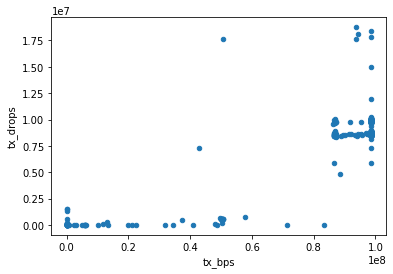

In [37]:
df_t.plot(kind="scatter", x="tx_bps", y='tx_drops')


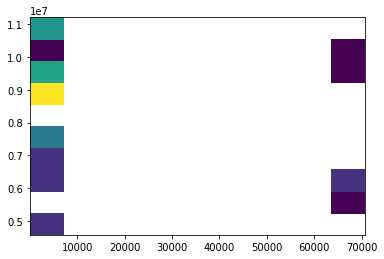

In [180]:

df_t2 = df_t[df_t['name']=="ge-0/0/1"][["tx_drops", "tx_bps", "tx_packets"]].rolling(window=5).mean()

# tx_drops =df_t[df_t['name']=="ge-0/0/1"][["tx_bps","rx_drops"]].rolling(window=5).mean()

# df_t.set_index('datetime')

df_t2 = df_t2.dropna()
h2 = plt.hist2d(df_t2['tx_packets'],  df_t2['tx_drops'], norm = mpl.colors.LogNorm())

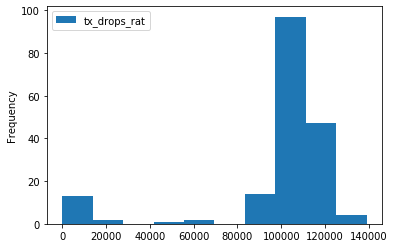

In [110]:
df_t['tx_drops_rat'] = df_t['tx_drops']/df_t['tx_packets']
# rat = [ x if x < 10.0 else 10.0 for x in rat ]

# # plt.set_loglevel()
# ax = plt.hist(rat, bins=100)
# plt.yscale('log')

df_t[df_t['tx_drops_rat']>0.0].plot(kind="hist", y="tx_drops_rat") #, logx=True, logy=True)

In [115]:
df_t.columns
df_t[['rx_bytes', 'rx_bps',
       'rx_packets', 'rx_errors', 'tx_bytes', 'tx_bps', 'tx_packets',
       'tx_drops', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets']].corr()

rx_bytes    rx_bps  rx_packets  rx_errors  tx_bytes  \
rx_bytes              1.000000  0.806314    0.999270  -0.008763 -0.327896   
rx_bps                0.806314  1.000000    0.794115  -0.005659 -0.224486   
rx_packets            0.999270  0.794115    1.000000  -0.008505 -0.309818   
rx_errors            -0.008763 -0.005659   -0.008505   1.000000 -0.247848   
tx_bytes             -0.327896 -0.224486   -0.309818  -0.247848  1.000000   
tx_bps               -0.320208 -0.160571   -0.302238  -0.267505  0.855773   
tx_packets            0.203249  0.162864    0.203913  -0.007280 -0.130682   
tx_drops             -0.386722 -0.271367   -0.368576  -0.219506  0.968270   
txcarrier_transition -0.008763 -0.005659   -0.008505   1.000000 -0.247848   
tx_mcast_packets      0.519120  0.363228    0.495242  -0.015380 -0.733512   
tx_bcast_packets      0.519318  0.363348    0.495446  -0.015646 -0.733294   
rx_mcast_packets     -0.029338 -0.020332   -0.027953   0.402089 -0.305519   
rx_bcast_packets      0.519318  0.363348    0.495446  -0.015646 -0.733294   

                        tx_bps  tx_packets  tx_drops  txcarrier_transition  \
rx_bytes             -0.320208    0.203249 -0.386722             -0.008763   
rx_bps               -0.160571    0.162864 -0.271367             -0.005659   
rx_packets           -0.302238    0.203913 -0.368576             -0.008505   
rx_errors            -0.267505   -0.007280 -0.219506              1.000000   
tx_bytes              0.855773   -0.130682  0.968270             -0.247848   
tx_bps                1.000000   -0.070588  0.852859             -0.267505   
tx_packets           -0.070588    1.000000 -0.147592             -0.007280   
tx_drops              0.852859   -0.147592  1.000000             -0.219506   
txcarrier_transition -0.267505   -0.007280 -0.219506              1.000000   
tx_mcast_packets     -0.778826    0.087351 -0.762206             -0.015380   
tx_bcast_packets     -0.778598    0.087503 -0.762007             -0.015646   
rx_mcast_packets     -0.295996   -0.025853 -0.289203              0.402089   
rx_bcast_packets     -0.778598    0.087503 -0.762007             -0.015646   

                      tx_mcast_packets  tx_bcast_packets  rx_mcast_packets  \
rx_bytes                      0.519120          0.519318         -0.029338   
rx_bps                        0.363228          0.363348         -0.020332   
rx_packets                    0.495242          0.495446         -0.027953   
rx_errors                    -0.015380         -0.015646          0.402089   
tx_bytes                     -0.733512         -0.733294         -0.305519   
tx_bps                       -0.778826         -0.778598         -0.295996   
tx_packets                    0.087351          0.087503         -0.025853   
tx_drops                     -0.762206         -0.762007         -0.289203   
txcarrier_transition         -0.015380         -0.015646          0.402089   
tx_mcast_packets              1.000000          1.000000         -0.053048   
tx_bcast_packets              1.000000          1.000000         -0.053711   
rx_mcast_packets             -0.053048         -0.053711          1.000000   
rx_bcast_packets              1.000000          1.000000         -0.053711   

                      rx_bcast_packets  
rx_bytes                      0.519318  
rx_bps                        0.363348  
rx_packets                    0.495446  
rx_errors                    -0.015646  
tx_bytes                     -0.733294  
tx_bps                       -0.778598  
tx_packets                    0.087503  
tx_drops                     -0.762007  
txcarrier_transition         -0.015646  
tx_mcast_packets              1.000000  
tx_bcast_packets              1.000000  
rx_mcast_packets             -0.053711  
rx_bcast_packets              1.000000

In [117]:
df_t[['rx_bytes', 'rx_bps',
       'rx_packets', 'rx_errors', 'tx_bytes', 'tx_bps', 'tx_packets',
       'tx_drops', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets']]

rx_bytes  rx_bps  rx_packets  rx_errors   tx_bytes    tx_bps  \
61         9354    1472          97          0  649659628  88914304   
134        7788    1440          89          0  715700374  86812512   
207        8396    1280          94          0  685174026  98601280   
280        8184     856          86          0  718885156  98600112   
353        7954    1064          89          0  716629612  98595808   
...         ...     ...         ...        ...        ...       ...   
62962   3362476    6208       46993          0  133357566     12704   
70534      7852    1024          85          0  729311204  98609040   
70607      8134    1320          86          0  718567435  87031456   
70680      8158    1280          88          0  749241024  98600400   
70753      7750    1376          84          0  739154536  98600000   

       tx_packets  tx_drops  txcarrier_transition  tx_mcast_packets  \
61             97   8410902                     0                10   
134            89   8669258                     0                14   
207            94   8199064                     0                16   
280            86   9789470                     0                18   
353            89   8446206                     0                20   
...           ...       ...                   ...               ...   
62962       46993       254                     0            396171   
70534          85   8673448                     0               418   
70607          86   9749868                     0               421   
70680          88   8782922                     0               423   
70753          84   8777272                     0               425   

       tx_bcast_packets  rx_mcast_packets  rx_bcast_packets  
61                    5               125                 5  
134                   6               159                 6  
207                   7               192                 7  
280                   9               226                 9  
353                  11               260                11  
...                 ...               ...               ...  
62962            314628               984            314628  
70534               211              4653               211  
70607               213              4688               213  
70680               213              4722               213  
70753               213              4756               213  

[180 rows x 13 columns]

In [143]:

desc

rx_bytes        rx_bps    rx_packets   rx_errors      tx_bytes  \
count  1.800000e+02  1.800000e+02    180.000000  180.000000  1.800000e+02   
mean   6.003459e+04  9.457556e+03    759.427778    0.005556  6.798535e+08   
std    4.214172e+05  9.729158e+04   5723.182061    0.074536  2.055938e+08   
min    5.542000e+03  6.560000e+02     59.000000    0.000000  4.323000e+03   
25%    7.680000e+03  9.600000e+02     83.000000    0.000000  7.095478e+08   
50%    7.954000e+03  1.048000e+03     86.000000    0.000000  7.188432e+08   
75%    8.263500e+03  1.240000e+03     88.000000    0.000000  7.304947e+08   
max    4.562059e+06  1.305576e+06  61092.000000    1.000000  1.476686e+09   

             tx_bps     tx_packets      tx_drops  tx_mtuerrors  \
count  1.800000e+02     180.000000  1.800000e+02         180.0   
mean   8.884373e+07    2721.138889  8.475593e+06           0.0   
std    2.489276e+07   26882.843482  2.712162e+06           0.0   
min    0.000000e+00      75.000000  8.000000e+00           0.0   
25%    8.882027e+07      83.000000  8.530234e+06           0.0   
50%    9.860037e+07      86.000000  8.669292e+06           0.0   
75%    9.860415e+07      88.000000  9.783024e+06           0.0   
max    9.861452e+07  353167.000000  1.874095e+07           0.0   

       txcarrier_transition  tx_mcast_packets  tx_bcast_packets  \
count            180.000000        180.000000        180.000000   
mean               0.011111      21917.905556      17297.916667   
std                0.149071      88933.234450      70612.847187   
min                0.000000          2.000000          2.000000   
25%                0.000000        216.250000         81.500000   
50%                0.000000        314.000000        156.000000   
75%                0.000000        418.750000        211.500000   
max                2.000000     396171.000000     314628.000000   

       rx_mcast_packets  rx_bcast_packets   tx_drops_rat  
count        180.000000        180.000000     180.000000  
mean        8548.788889      17297.916667   97486.896578  
std        31431.708391      70612.847187   30333.308606  
min           24.000000          2.000000       0.005171  
25%         1234.500000         81.500000   98578.693063  
50%         2776.500000        156.000000  103989.868867  
75%         4323.750000        211.500000  112470.923211  
max       177204.000000     314628.000000  138987.255814

In [156]:
desc = df_t.describe()
ylabs = []
for col in desc.columns:
    if desc[col].get('std')> 0:
        
        ylabs.append(col)
        print(col, desc[col].get('std'))
# desc[col].std()
# ylabs


rx_bytes 421417.18776081176
rx_bps 97291.5764726772
rx_packets 5723.182061176224
rx_errors 0.07453559924999298
tx_bytes 205593848.19211447
tx_bps 24892760.976965
tx_packets 26882.843481503092
tx_drops 2712162.124819076
txcarrier_transition 0.14907119849998596
tx_mcast_packets 88933.23444975416
tx_bcast_packets 70612.84718691195
rx_mcast_packets 31431.708390512988
rx_bcast_packets 70612.84718691195
tx_drops_rat 30333.308605911127


In [157]:
desc['tx_mtuerrors'].get('std')

0.0

In [158]:
df_t[ylabs].corr()

rx_bytes    rx_bps  rx_packets  rx_errors  tx_bytes  \
rx_bytes              1.000000  0.806314    0.999270  -0.008763 -0.327896   
rx_bps                0.806314  1.000000    0.794115  -0.005659 -0.224486   
rx_packets            0.999270  0.794115    1.000000  -0.008505 -0.309818   
rx_errors            -0.008763 -0.005659   -0.008505   1.000000 -0.247848   
tx_bytes             -0.327896 -0.224486   -0.309818  -0.247848  1.000000   
tx_bps               -0.320208 -0.160571   -0.302238  -0.267505  0.855773   
tx_packets            0.203249  0.162864    0.203913  -0.007280 -0.130682   
tx_drops             -0.386722 -0.271367   -0.368576  -0.219506  0.968270   
txcarrier_transition -0.008763 -0.005659   -0.008505   1.000000 -0.247848   
tx_mcast_packets      0.519120  0.363228    0.495242  -0.015380 -0.733512   
tx_bcast_packets      0.519318  0.363348    0.495446  -0.015646 -0.733294   
rx_mcast_packets     -0.029338 -0.020332   -0.027953   0.402089 -0.305519   
rx_bcast_packets      0.519318  0.363348    0.495446  -0.015646 -0.733294   
tx_drops_rat         -0.398823 -0.279254   -0.379936  -0.228919  0.830111   

                        tx_bps  tx_packets  tx_drops  txcarrier_transition  \
rx_bytes             -0.320208    0.203249 -0.386722             -0.008763   
rx_bps               -0.160571    0.162864 -0.271367             -0.005659   
rx_packets           -0.302238    0.203913 -0.368576             -0.008505   
rx_errors            -0.267505   -0.007280 -0.219506              1.000000   
tx_bytes              0.855773   -0.130682  0.968270             -0.247848   
tx_bps                1.000000   -0.070588  0.852859             -0.267505   
tx_packets           -0.070588    1.000000 -0.147592             -0.007280   
tx_drops              0.852859   -0.147592  1.000000             -0.219506   
txcarrier_transition -0.267505   -0.007280 -0.219506              1.000000   
tx_mcast_packets     -0.778826    0.087351 -0.762206             -0.015380   
tx_bcast_packets     -0.778598    0.087503 -0.762007             -0.015646   
rx_mcast_packets     -0.295996   -0.025853 -0.289203              0.402089   
rx_bcast_packets     -0.778598    0.087503 -0.762007             -0.015646   
tx_drops_rat          0.896983   -0.316679  0.887507             -0.228919   

                      tx_mcast_packets  tx_bcast_packets  rx_mcast_packets  \
rx_bytes                      0.519120          0.519318         -0.029338   
rx_bps                        0.363228          0.363348         -0.020332   
rx_packets                    0.495242          0.495446         -0.027953   
rx_errors                    -0.015380         -0.015646          0.402089   
tx_bytes                     -0.733512         -0.733294         -0.305519   
tx_bps                       -0.778826         -0.778598         -0.295996   
tx_packets                    0.087351          0.087503         -0.025853   
tx_drops                     -0.762206         -0.762007         -0.289203   
txcarrier_transition         -0.015380         -0.015646          0.402089   
tx_mcast_packets              1.000000          1.000000         -0.053048   
tx_bcast_packets              1.000000          1.000000         -0.053711   
rx_mcast_packets             -0.053048         -0.053711          1.000000   
rx_bcast_packets              1.000000          1.000000         -0.053711   
tx_drops_rat                 -0.784086         -0.783881         -0.333350   

                      rx_bcast_packets  tx_drops_rat  
rx_bytes                      0.519318     -0.398823  
rx_bps                        0.363348     -0.279254  
rx_packets                    0.495446     -0.379936  
rx_errors                    -0.015646     -0.228919  
tx_bytes                     -0.733294      0.830111  
tx_bps                       -0.778598      0.896983  
tx_packets                    0.087503     -0.316679  
tx_drops                     -0.762007      0.887507  
txcarrier_transition         

In [160]:
ylabs

['rx_bytes',
 'rx_bps',
 'rx_packets',
 'rx_errors',
 'tx_bytes',
 'tx_bps',
 'tx_packets',
 'tx_drops',
 'txcarrier_transition',
 'tx_mcast_packets',
 'tx_bcast_packets',
 'rx_mcast_packets',
 'rx_bcast_packets',
 'tx_drops_rat']

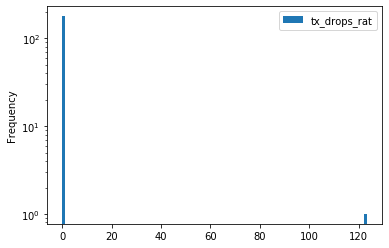

In [169]:
df_t['tx_drops_rat'] = df_t['tx_drops']/df_t['tx_bytes']  # 'tx_bytes',  'tx_bps',

df_t[df_t['tx_drops_rat']>0.0].plot(kind="hist", y="tx_drops_rat", bins=100, logx=False, logy=True)

In [31]:
import pandas as pd

In [40]:
df_iperf = pd.read_excel('/Users/wenfengw/Downloads/Throughput test - Iperf Results.xlsx', sheet_name='Sheet1')

df_iperf

Bandwidth  Bytes Input  Packets Input  Bytes Output  Packets Output  \
0        30M         4959             56      38281639           27269   
1        40M         5190             59      50813173           36189   
2        50M         4591             52      57769123           41114   
3        60M         4592             52      58419633           41552   
4        70M         3967             47      58754444           41794   
5        75M         5295             58      59181776           42856   
6        80M         6099             69      61002589           43360   
7        85M         3891             44      60485811           42991   
8        90M         4491             40      55705305           39596   
9        95M         4363             49      62891873           44693   
10      100M         5167             60      62902471           44683   
11      120M         4632             52      63982470           45462   
12      140M         4594             52      66464019           47229   
13      160M         4492             51      70500338           50081   

    Drops Output  Packets/Drop Ratio  IPERF  - Data Transfer (MB)  \
0              0            0.000000                         35.5   
1            326            0.009008                         47.3   
2           8512            0.207034                         59.1   
3          19028            0.457932                         71.0   
4          43512            1.041106                         82.7   
5          50436            1.176871                         88.6   
6          58622            1.351983                         94.6   
7          67618            1.572841                        100.0   
8          76404            1.929589                        106.0   
9          83052            1.858278                        112.0   
10         92428            2.068527                        118.0   
11        125708            2.765123                        142.0   
12        159972            3.387156                        166.0   
13        171286            3.420179                        189.0   

    IPERF - Bandwdith (Mbps)  IPERF - Jitter (ms)  IPERF - Lost Datagram  \
0                       29.7                 0.66                      3   
1                       39.6                 0.62                     31   
2                       49.5                 2.79                    846   
3                       59.5                 0.55                   2491   
4                       69.4                 0.63                   4062   
5                       74.3                 2.93                   4994   
6                       79.3                 0.66                   5533   
7                       84.3                 2.72                   6436   
8                       89.2                 0.67                   7076   
9                       94.2                 2.64                   7808   
10                      99.2                 0.60                   8647   
11                     119.0                 0.68                  11703   
12                     139.0                 0.70                  14687   
13                     159.0                 2.74                  17777   

    IPERF - Total Datagrams  IPERF - Lost Datagram %  
0                      4541                     0.06  
1                      6055                     0.51  
2                      7558                    11.00  
3                      9065                    27.00  
4                     10545                    39.00  
5                     11339                    44.00  
6                     12061                    46.00  
7                     12855                    50.00  
8                     13550                    52.00  
9                     14366                    54.00  
10                    15056                    57.00  
11                    18037                    65.00  


In [41]:
df_iperf.columns

Index(['Bandwidth', 'Bytes Input', 'Packets Input', 'Bytes Output',
       'Packets Output', 'Drops Output', 'Packets/Drop Ratio',
       'IPERF  - Data Transfer (MB)', 'IPERF - Bandwdith (Mbps)',
       'IPERF - Jitter (ms)', 'IPERF - Lost Datagram',
       'IPERF - Total Datagrams', 'IPERF - Lost Datagram %'],
      dtype='object')

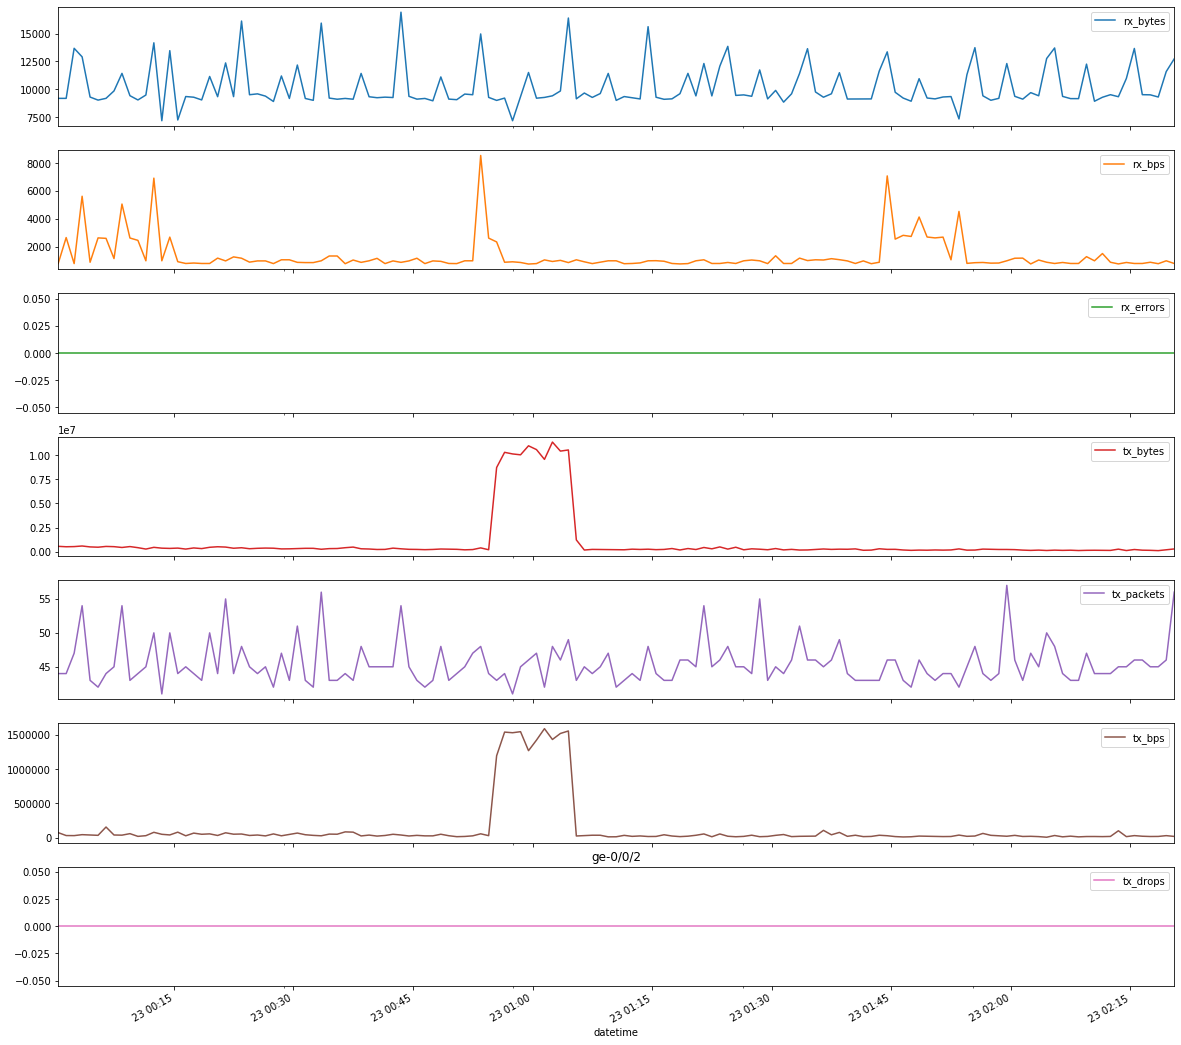

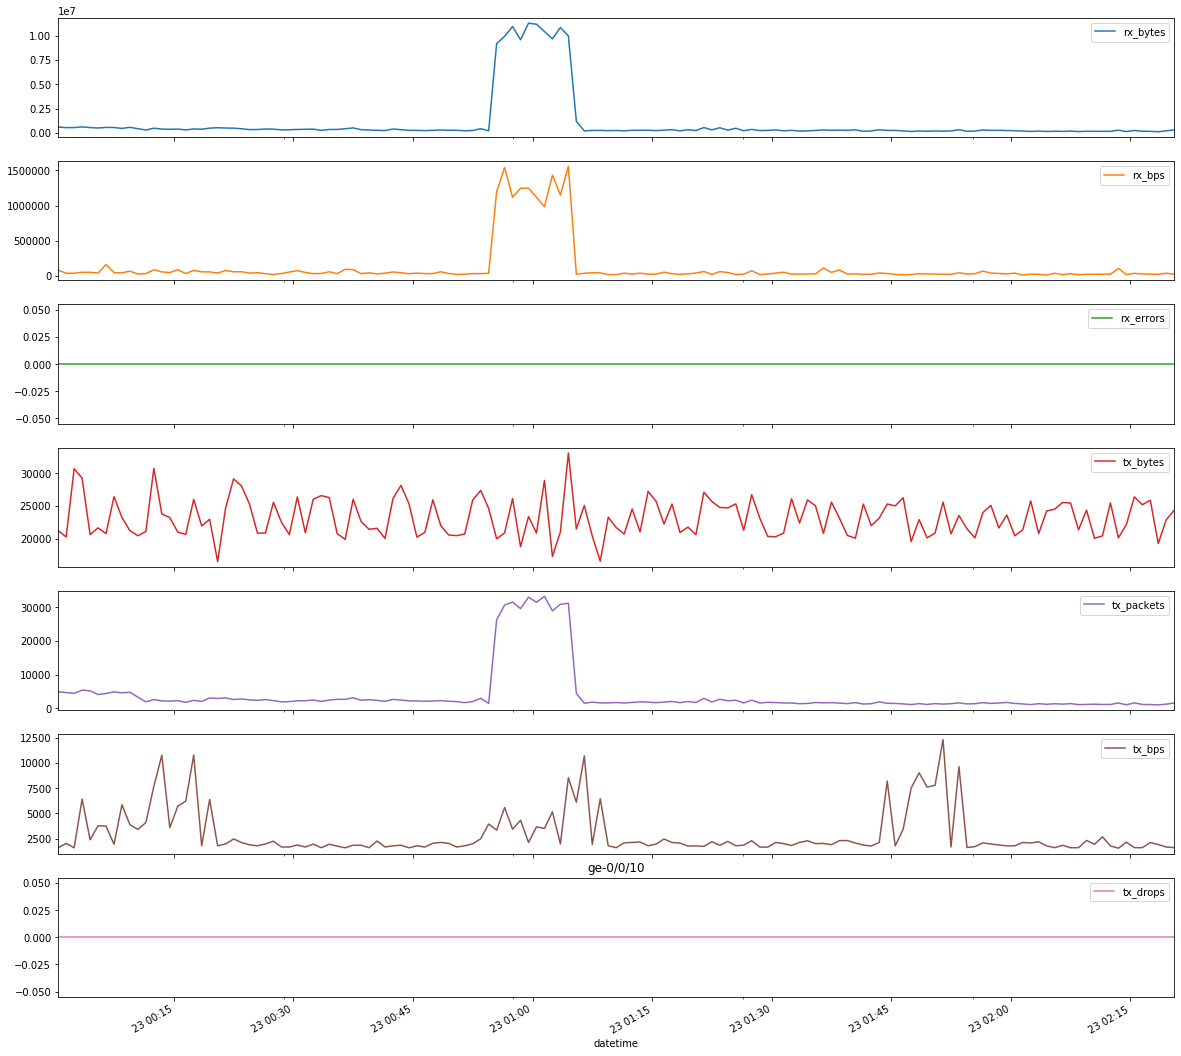

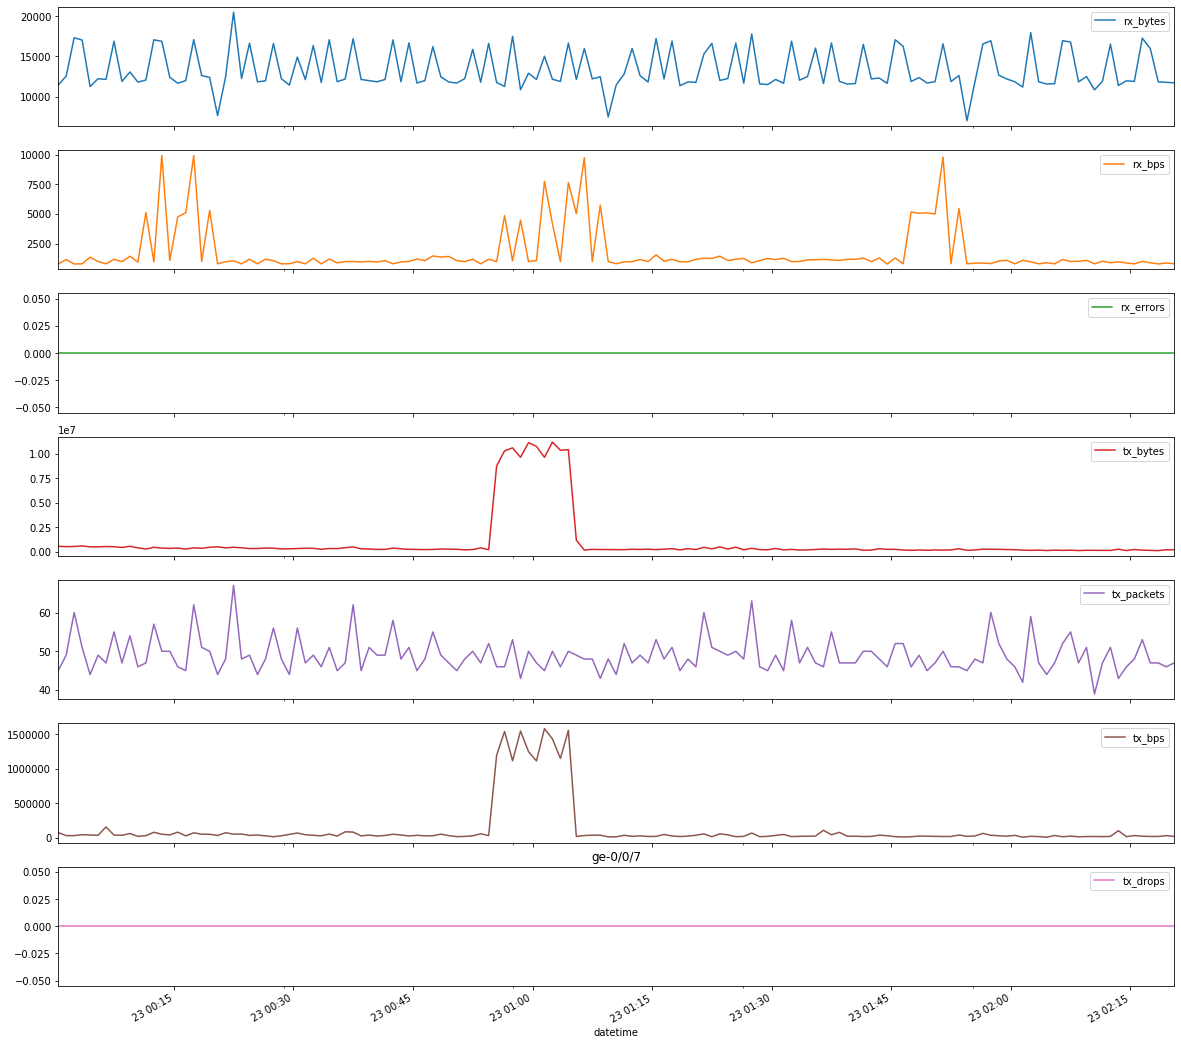

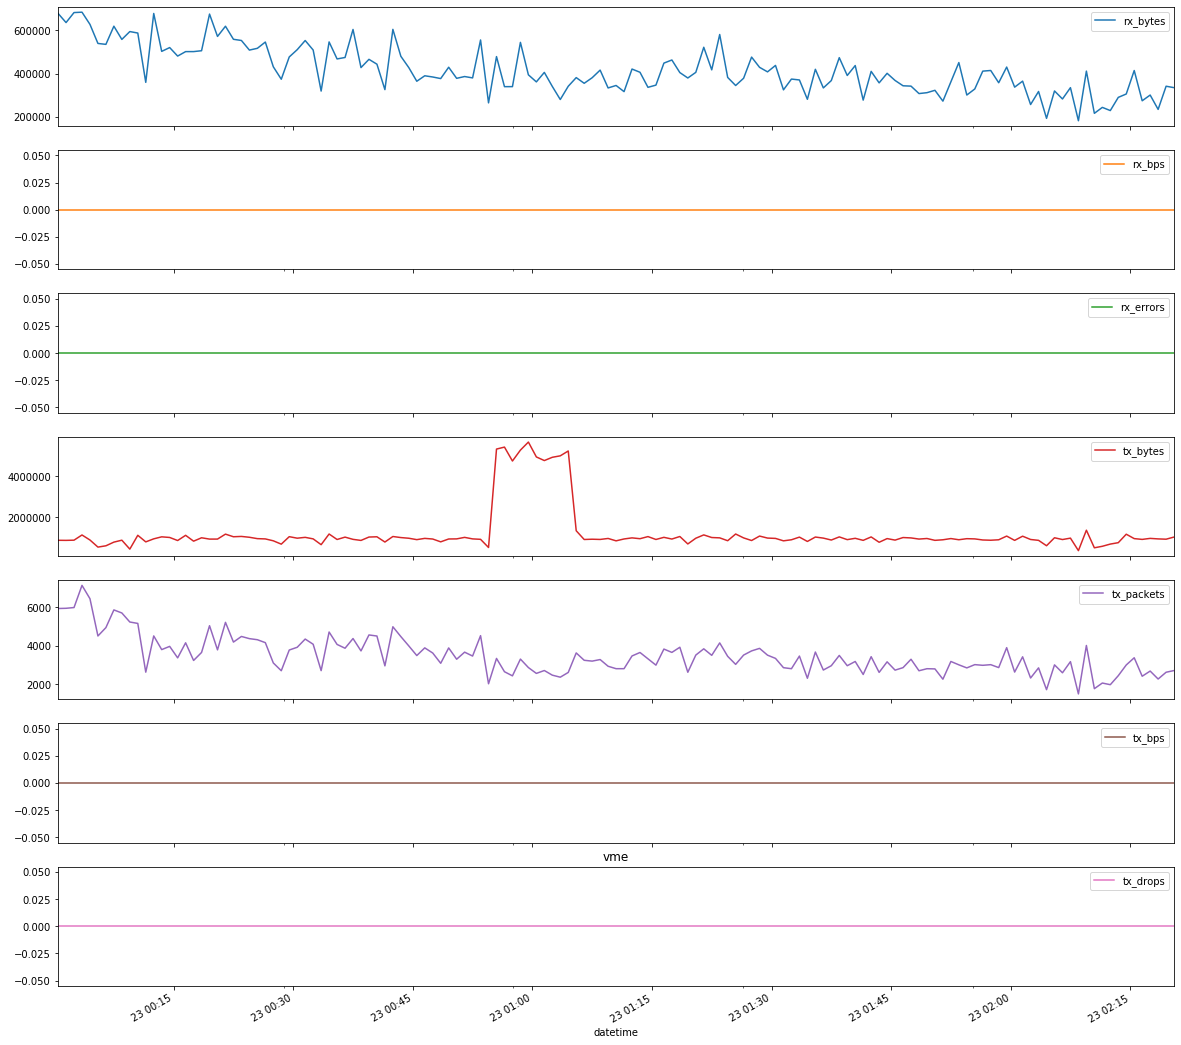

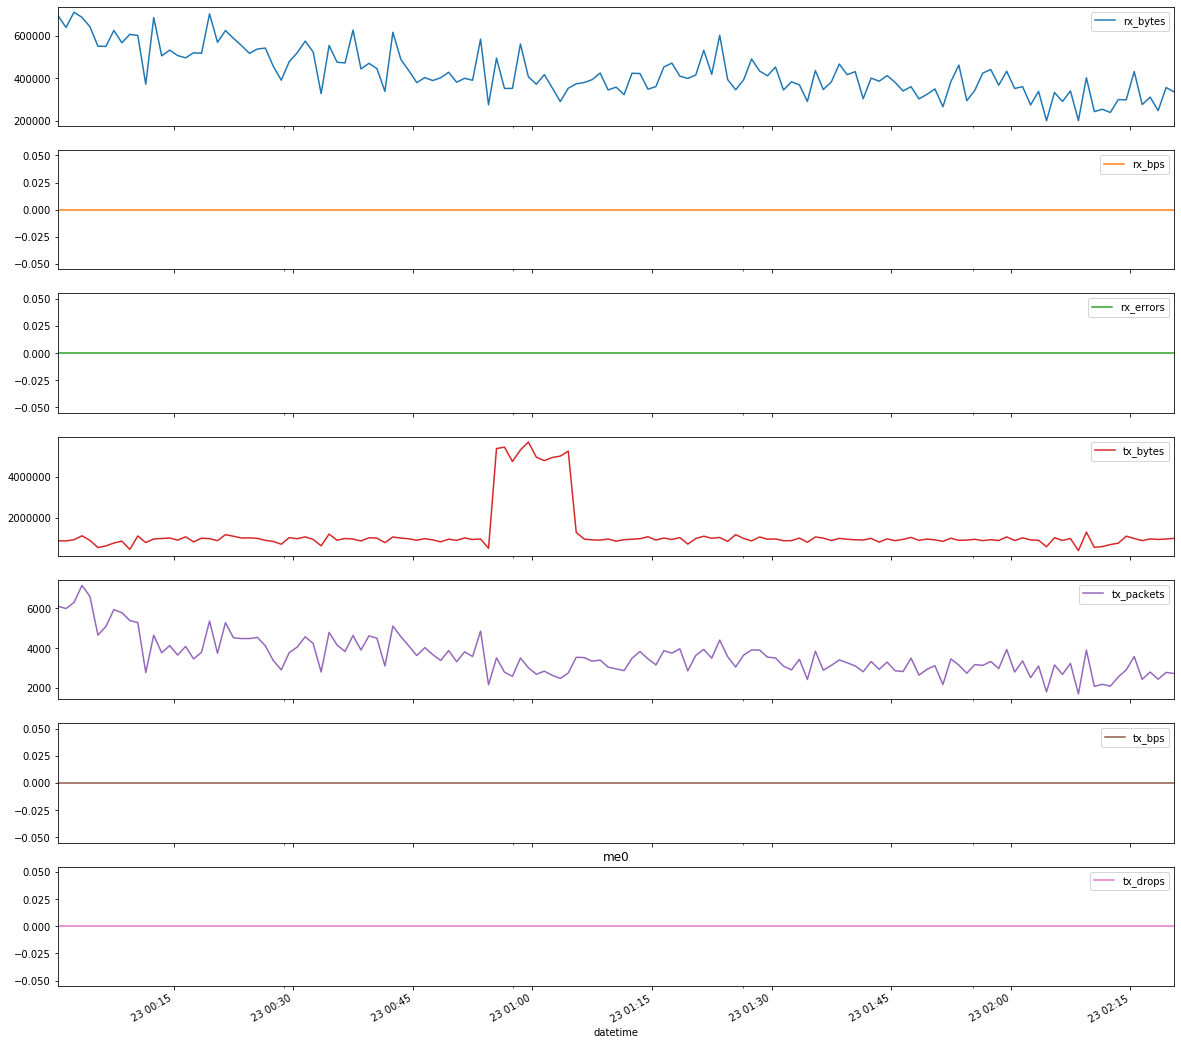

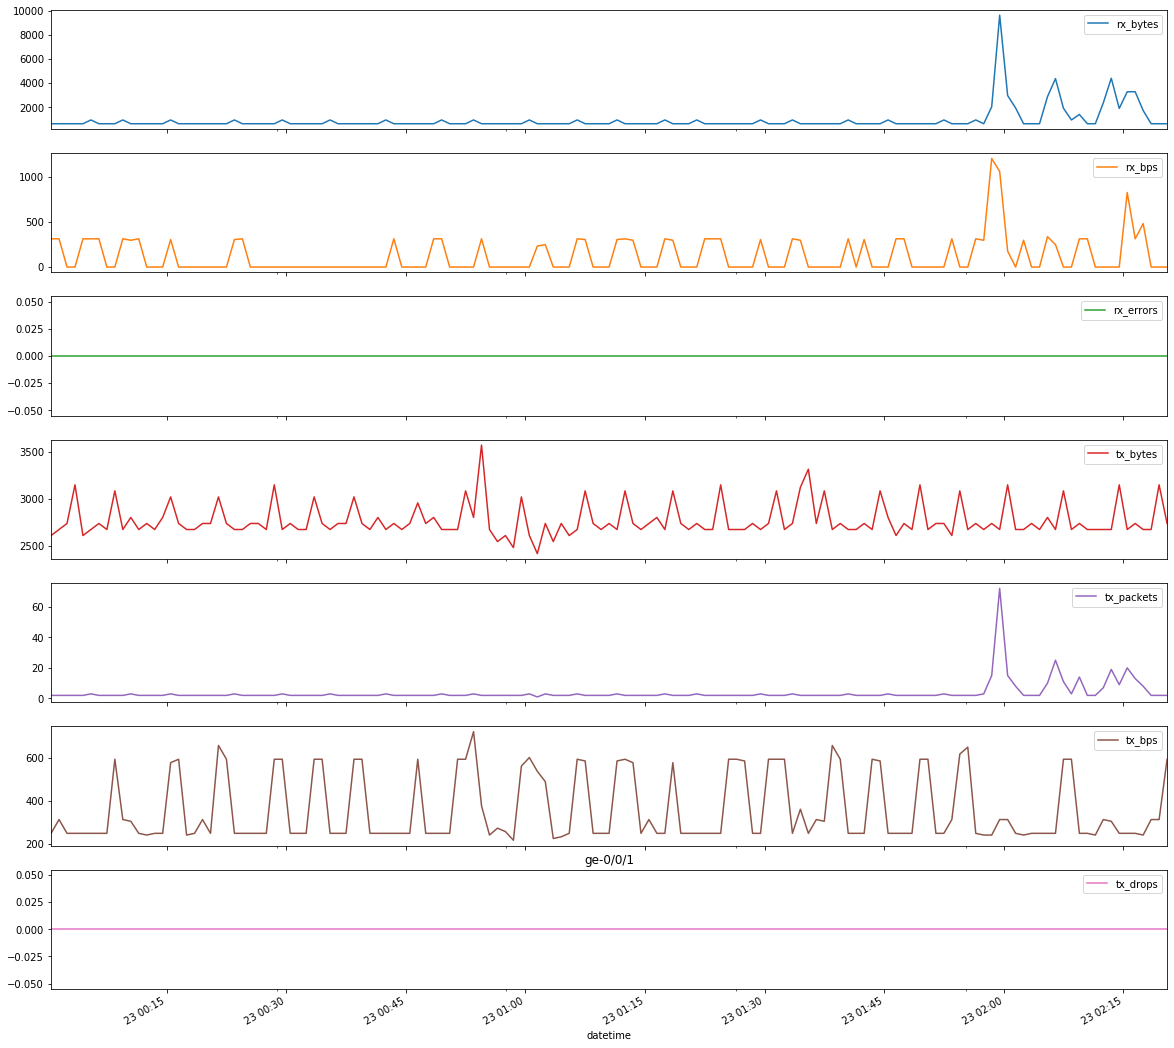

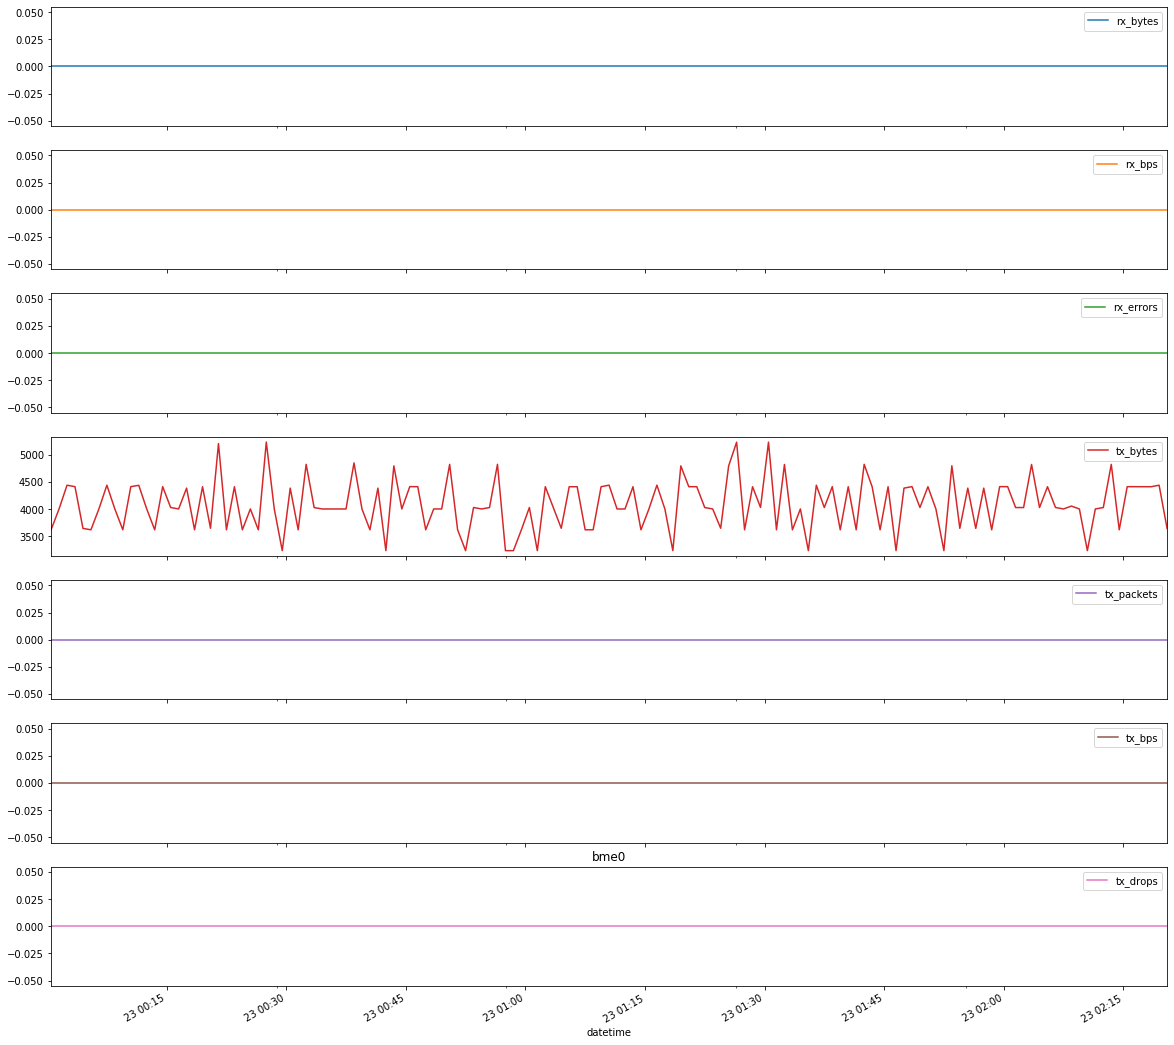

In [45]:
# plt.hist(df_link['tx_bps'], bins=100)


set(df_pd['id'])

switch2 = '3c8c9394a39e'
df_1 = df_pd[df_pd['id']==switch2]
df_1 = df_1[df_1['link']==True]
names = set(df_1['name'])

for name in names:
    df_link = df_1[df_1['name']==name]
    if df_link['tx_bytes'].max()> 0:
        df_1[df_1['name']==name].plot(x="datetime", y = ylabs, subplots=True, figsize=(20, 20))
        plt.title(name)
    

(array([[7.2481e+04, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.2000e+01, 0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0100e+02,
         5.7000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00],
        [1.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

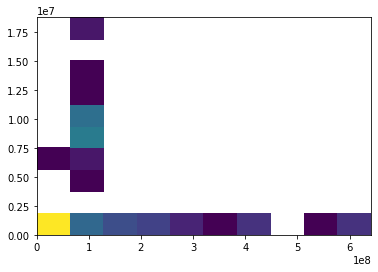

In [88]:

# matrix, *opt = np.histogram2d(x, y)
# img = plt.imshow(matrix, norm = mpl.colors.LogNorm(), cmap = mpl.cm.gray, 
#                  interpolation="None")


# plt.hist2d(df_t['tx_bytes'], df_t['tx_drops'], norm=mpl.colors.LogNorm())

df
plt.hist2d(df_pd['tx_bps'], df_pd['tx_drops'], norm=mpl.colors.LogNorm())


In [30]:
88914304/1.e6

88.914304

In [31]:
649659628/1.E6

649.659628

In [ ]:

for ylabel in ylabels:
    df_pd.plot(kind="scatter", x='tx_bytes', y=ylabel)
    plt.title(ylab)


Text(0.5, 1.0, 'tx_drops')

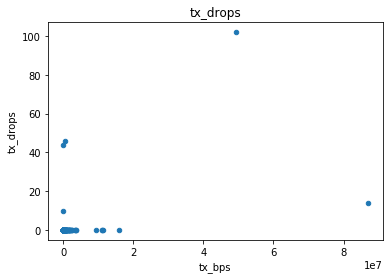

In [120]:

    df_pd.plot(kind="scatter", x='tx_bps', y="tx_drops")
    plt.title(ylab)


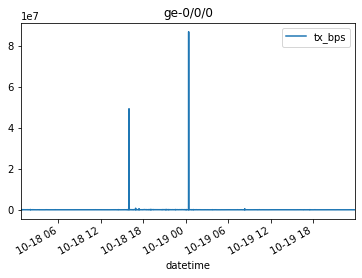

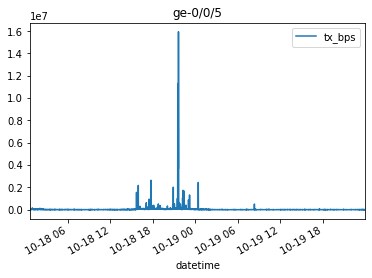

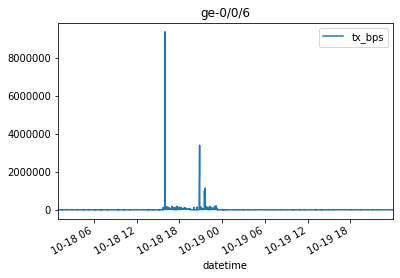

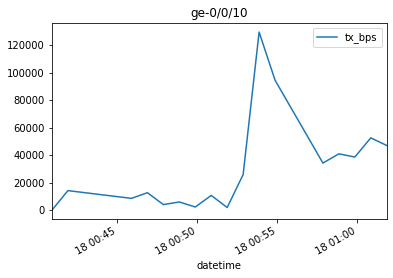

In [121]:
import matplotlib.pyplot as plt
y_labels = ["tx_bps", "rx_errors", "tx_bytes", "tx_drops"]
for name in names:
    df_pd[df_pd['name']==name].plot(x='datetime', y = "tx_bps", subplots=False)
    plt.title(name)

/opt/mistsys/ds_incubator/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


name
.local.      [AxesSubplot(0.125,0.2;0.775x0.68)]
bme0         [AxesSubplot(0.125,0.2;0.775x0.68)]
cbp0         [AxesSubplot(0.125,0.2;0.775x0.68)]
dsc          [AxesSubplot(0.125,0.2;0.775x0.68)]
esi          [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/0     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/10    [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/5     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/6     [AxesSubplot(0.125,0.2;0.775x0.68)]
gre          [AxesSubplot(0.125,0.2;0.775x0.68)]
ipip         [AxesSubplot(0.125,0.2;0.775x0.68)]
irb          [AxesSubplot(0.125,0.2;0.775x0.68)]
jsrv         [AxesSubplot(0.125,0.2;0.775x0.68)]
lo0          [AxesSubplot(0.125,0.2;0.775x0.68)]
lsi          [AxesSubplot(0.125,0.2;0.775x0.68)]
me0          [AxesSubplot(0.125,0.2;0.775x0.68)]
mtun         [AxesSubplot(0.125,0.2;0.775x0.68)]
pfe-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pfh-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pimd         [AxesSubplot(0.125,0.2;0.775x0.68)]
pime         [A

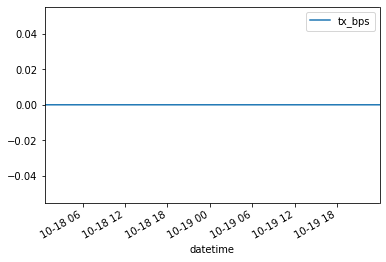

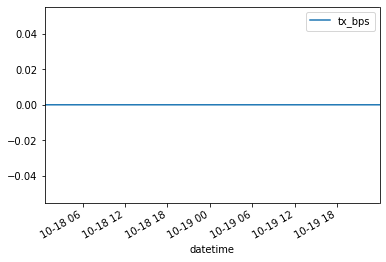

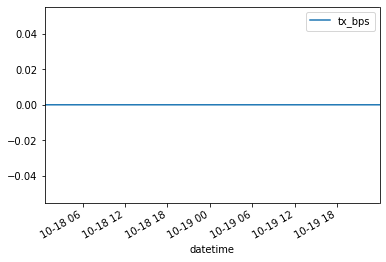

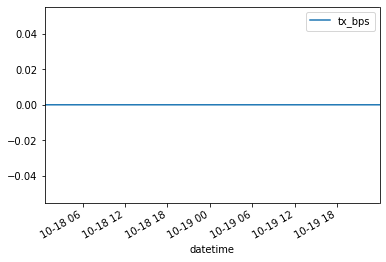

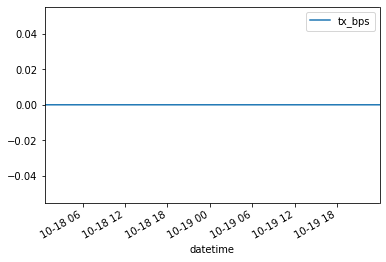

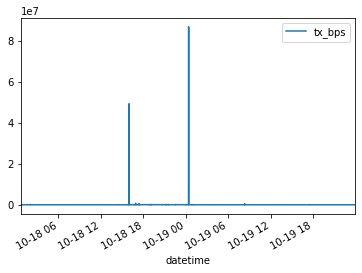

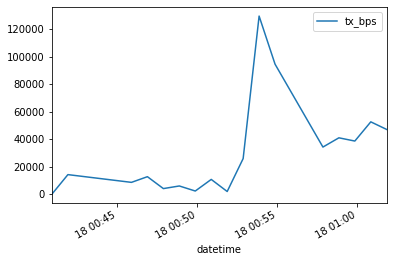

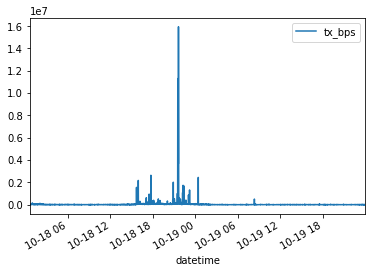

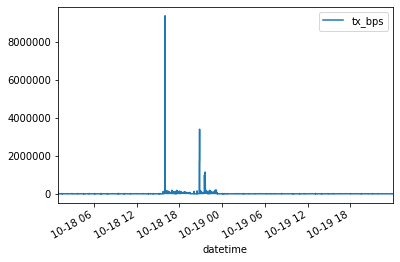

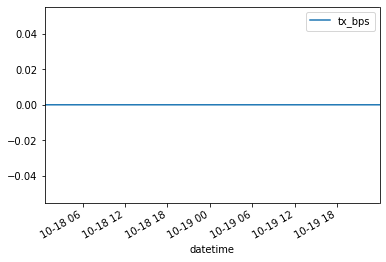

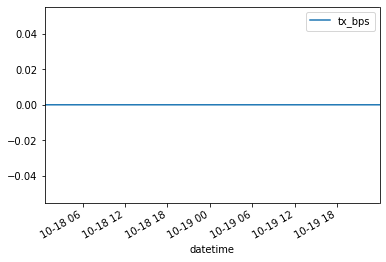

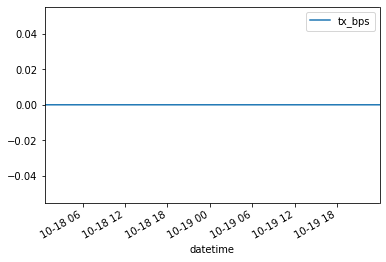

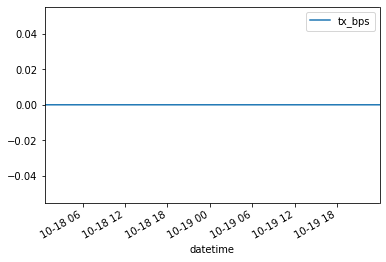

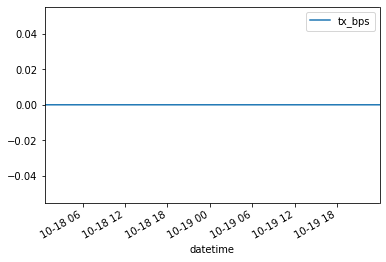

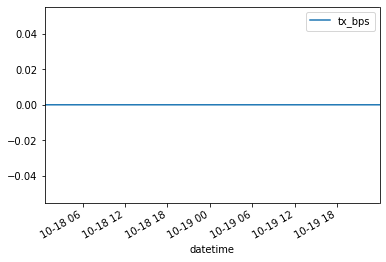

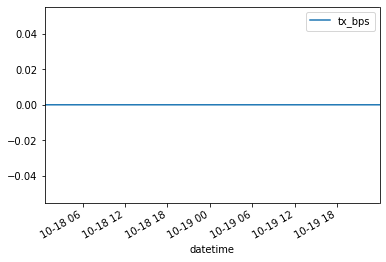

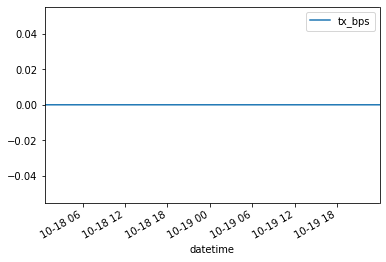

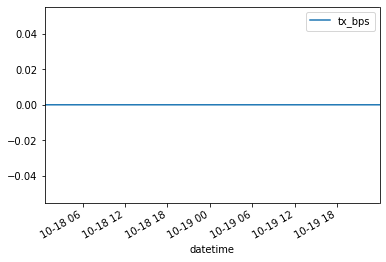

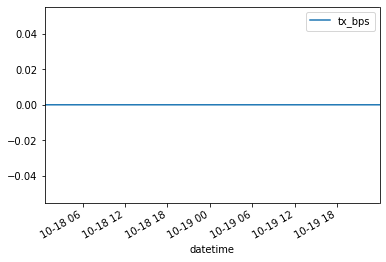

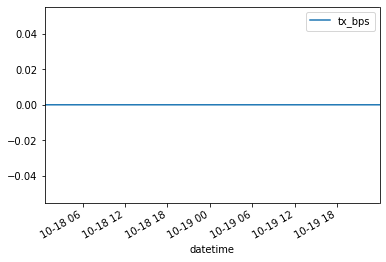

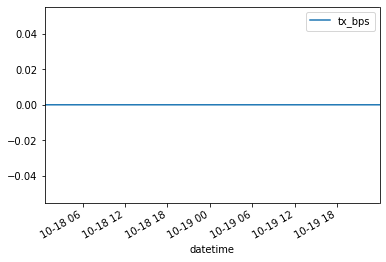

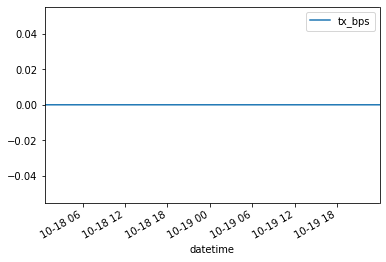

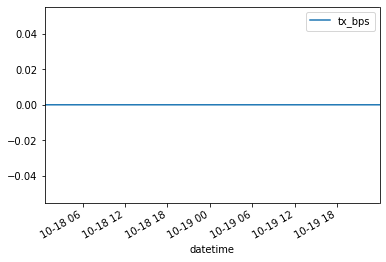

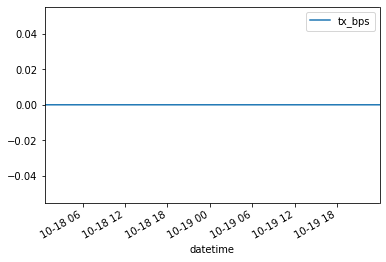

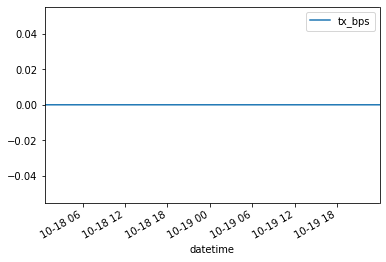

In [37]:
import pandas as pd
df_pd['datetime'] = [ pd.Timestamp(x*1000) for x in df_pd['when']]
df_pd['datetime'] 

df_pd.groupby('name').plot(x='datetime', y = "tx_bps", subplots=True)
# df_pd.columns

name
.local.      [AxesSubplot(0.125,0.2;0.775x0.68)]
bme0         [AxesSubplot(0.125,0.2;0.775x0.68)]
cbp0         [AxesSubplot(0.125,0.2;0.775x0.68)]
dsc          [AxesSubplot(0.125,0.2;0.775x0.68)]
esi          [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/0     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/10    [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/5     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/6     [AxesSubplot(0.125,0.2;0.775x0.68)]
gre          [AxesSubplot(0.125,0.2;0.775x0.68)]
ipip         [AxesSubplot(0.125,0.2;0.775x0.68)]
irb          [AxesSubplot(0.125,0.2;0.775x0.68)]
jsrv         [AxesSubplot(0.125,0.2;0.775x0.68)]
lo0          [AxesSubplot(0.125,0.2;0.775x0.68)]
lsi          [AxesSubplot(0.125,0.2;0.775x0.68)]
me0          [AxesSubplot(0.125,0.2;0.775x0.68)]
mtun         [AxesSubplot(0.125,0.2;0.775x0.68)]
pfe-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pfh-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pimd         [AxesSubplot(0.125,0.2;0.775x0.68)]
pime         [A

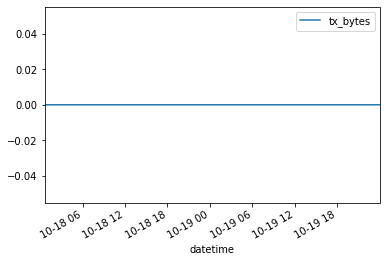

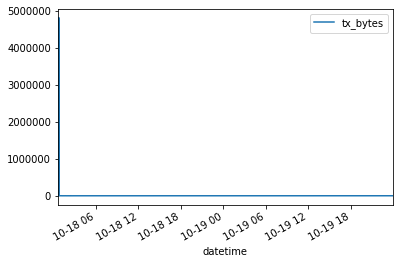

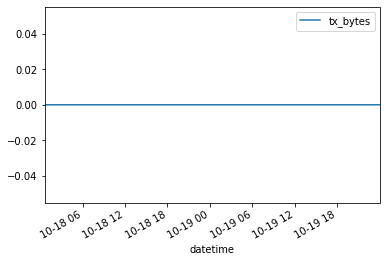

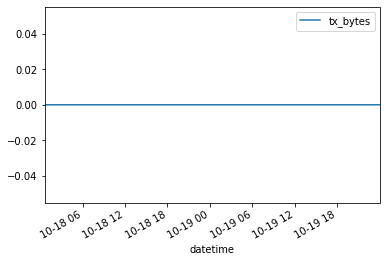

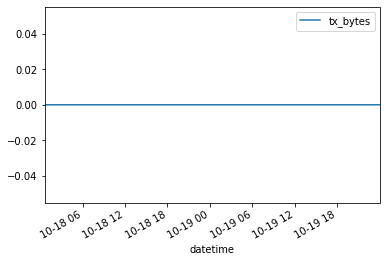

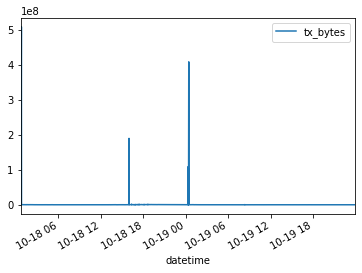

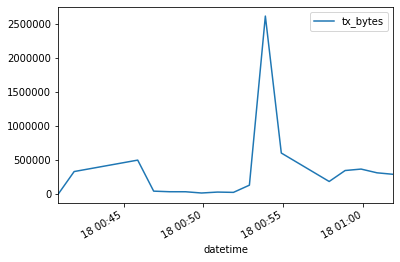

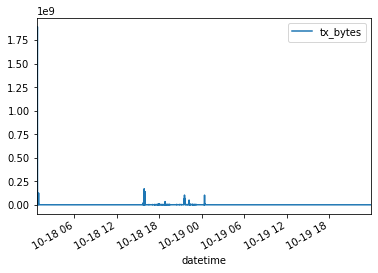

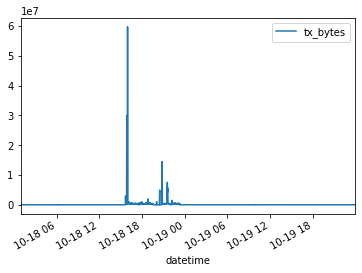

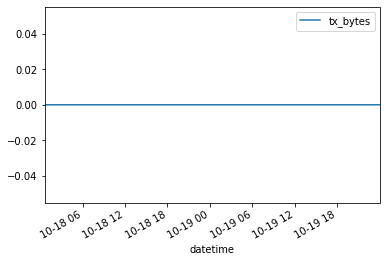

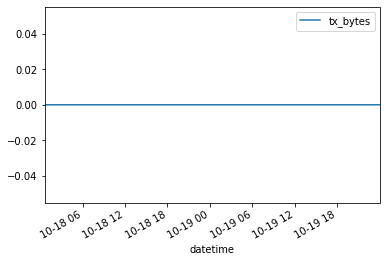

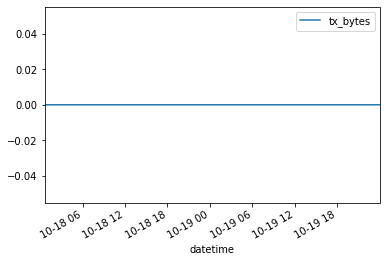

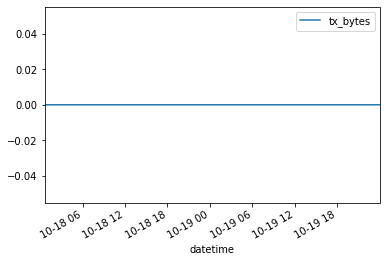

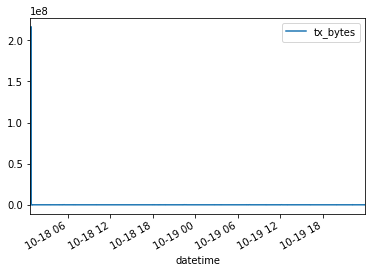

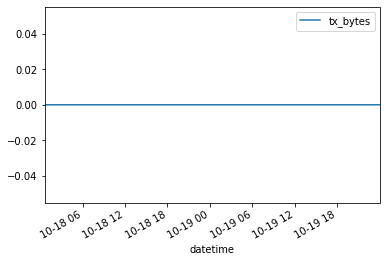

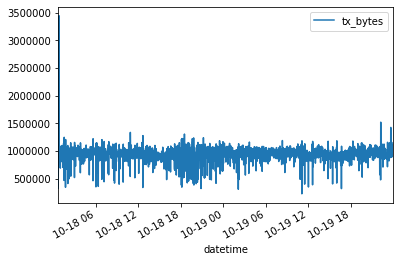

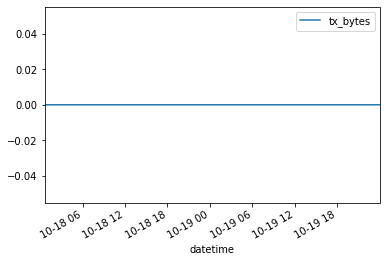

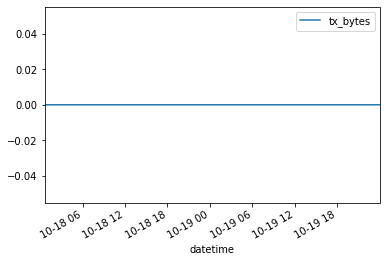

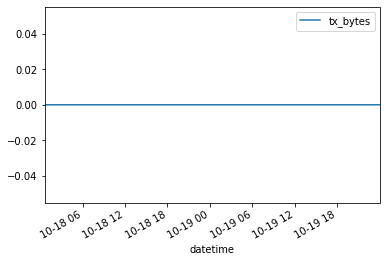

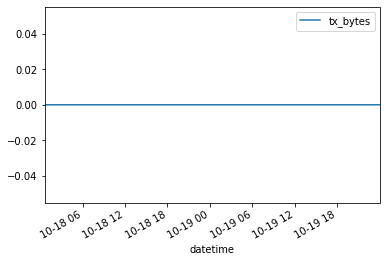

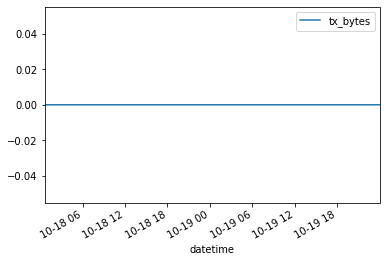

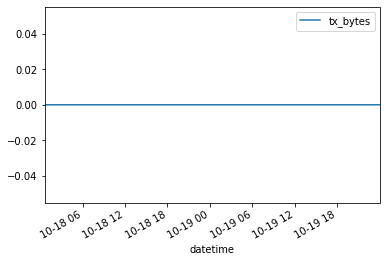

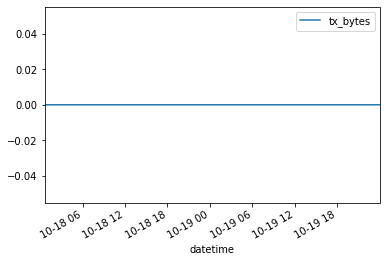

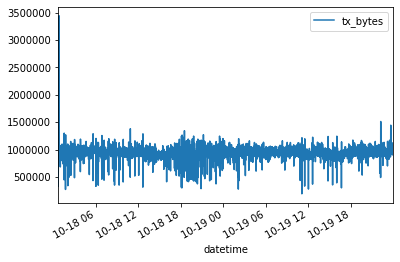

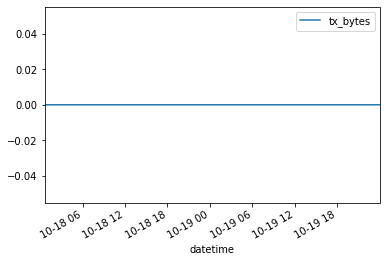

In [38]:
df_pd.groupby('name').plot(x='datetime', y = "tx_bytes", subplots=True)


In [39]:
df_pd.columns

Index(['id', 'when', 'org_id', 'site_id', 'name', 'link', 'full_duplex',
       'mbps', 'mtu', 'address', 'admin_status', 'last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta', 'datetime'],
      dtype='object')

In [41]:
df_pd['rx_errors'].max(), df_pd['tx_errors'].max()

(1, 0)

In [47]:
df_g = df_pd[df_pd['name'].isin(names)].groupby('name').


In [57]:
# df_g.index

In [87]:
# df_pd.groupby('name').get_group("ge-0/0/0").datetime.tolist()

In [85]:
#df_pd.groupby('name').plot(x='datetime', y = "tx_bps", subplots=True)
# df_pd.set_index('datetime')
# df_pd[df_pd['name'].isin(names)].groupby('name').plot(x='datetime', y = "tx_bytes", subplots=True )


# df_temp = df_pd.groupby('name').count()
data = list()
for name in names:
    df_temp = df_pd.groupby('name').get_group(name)
    df_temp = df_temp.sort_values('datetime')
    data.append(go.Scatter(
        x = df_temp.datetime,
        y = df_temp.tx_bytes,
        name = name,
        opacity=0.7))
    

layout = go.Layout(
    yaxis=dict(
        title='Number of unique sites with anomalies'
    ),
    bargap=0.2,
    bargroupgap=0.1
)
fig = go.Figure(data=data, layout=layout)


plotly.offline.iplot({
    "data": data,
    "layout": layout
})


In [86]:
# data

[Scatter({
     'name': 'ge-0/0/0',
     'opacity': 0.7,
     'x': array([datetime.datetime(2019, 10, 18, 0, 38, 53, 659139),
                 datetime.datetime(2019, 10, 18, 0, 39, 53, 659362),
                 datetime.datetime(2019, 10, 18, 0, 40, 53, 659584), ...,
                 datetime.datetime(2019, 10, 19, 23, 57, 19, 258298),
                 datetime.datetime(2019, 10, 19, 23, 58, 19, 258526),
                 datetime.datetime(2019, 10, 19, 23, 59, 19, 258807)], dtype=object),
     'y': array([507124738,      7400,      4912, ...,     97488,    120432,     99216])
 }), Scatter({
     'name': 'ge-0/0/5',
     'opacity': 0.7,
     'x': array([datetime.datetime(2019, 10, 18, 0, 38, 53, 659139),
                 datetime.datetime(2019, 10, 18, 0, 39, 53, 659362),
                 datetime.datetime(2019, 10, 18, 0, 40, 53, 659584), ...,
                 datetime.datetime(2019, 10, 19, 23, 57, 19, 258298),
                 datetime.datetime(2019, 10, 19, 23, 58, 19, 258526),
   

name
ge-0/0/0     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/10    [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/5     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/6     [AxesSubplot(0.125,0.2;0.775x0.68)]
dtype: object

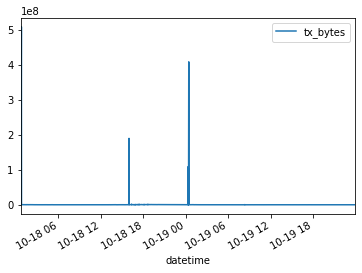

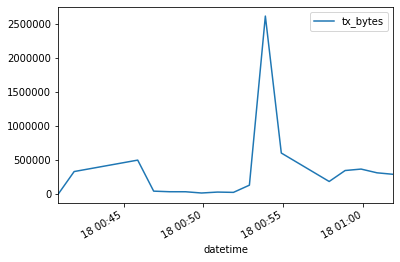

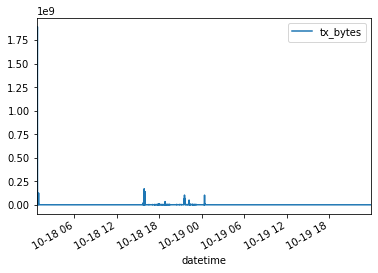

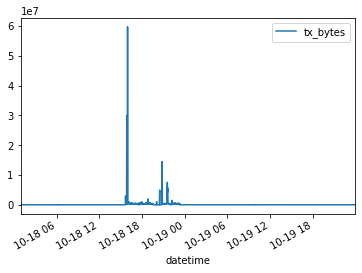

In [65]:
names = ["ge-0/0/0", "ge-0/0/5", "ge-0/0/6", "ge-0/0/10"]

#df_pd.groupby('name').plot(x='datetime', y = "tx_bps", subplots=True)
df_pd.set_index('datetime')
df_pd[df_pd['name'].isin(names)].groupby('name').plot(x='datetime', y = "tx_bytes", subplots=True )

# df_pd[df_pd['name'].isin(names)].plot(x='datetime', y = "tx_bytes", subplots=True )

name
.local.      [AxesSubplot(0.125,0.2;0.775x0.68)]
bme0         [AxesSubplot(0.125,0.2;0.775x0.68)]
cbp0         [AxesSubplot(0.125,0.2;0.775x0.68)]
dsc          [AxesSubplot(0.125,0.2;0.775x0.68)]
esi          [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/0     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/10    [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/5     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/6     [AxesSubplot(0.125,0.2;0.775x0.68)]
gre          [AxesSubplot(0.125,0.2;0.775x0.68)]
ipip         [AxesSubplot(0.125,0.2;0.775x0.68)]
irb          [AxesSubplot(0.125,0.2;0.775x0.68)]
jsrv         [AxesSubplot(0.125,0.2;0.775x0.68)]
lo0          [AxesSubplot(0.125,0.2;0.775x0.68)]
lsi          [AxesSubplot(0.125,0.2;0.775x0.68)]
me0          [AxesSubplot(0.125,0.2;0.775x0.68)]
mtun         [AxesSubplot(0.125,0.2;0.775x0.68)]
pfe-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pfh-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pimd         [AxesSubplot(0.125,0.2;0.775x0.68)]
pime         [A

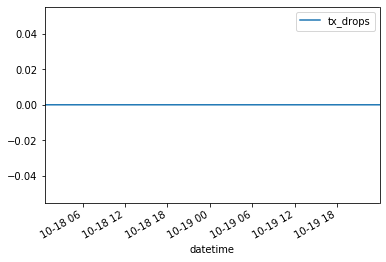

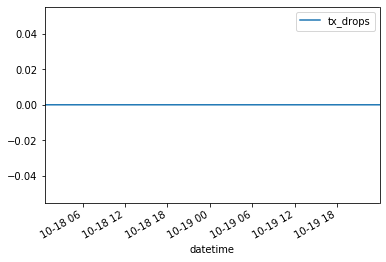

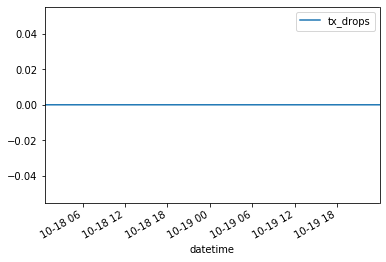

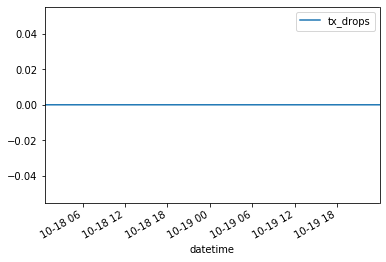

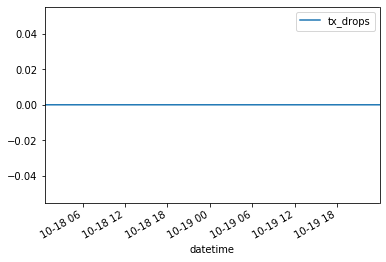

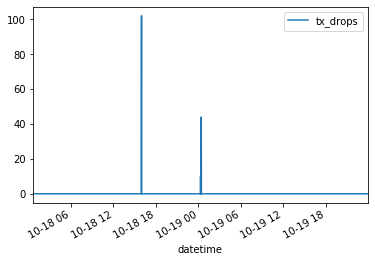

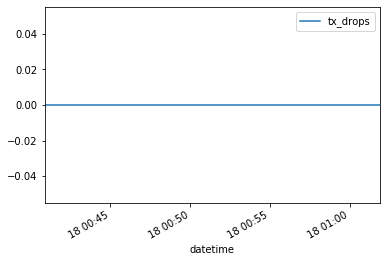

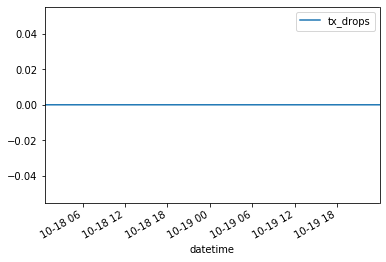

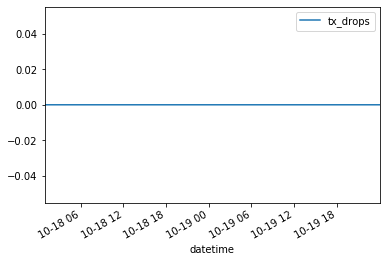

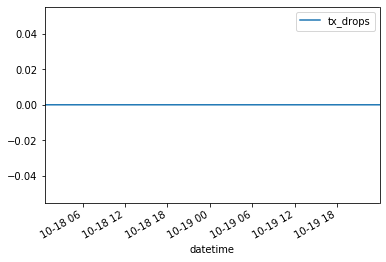

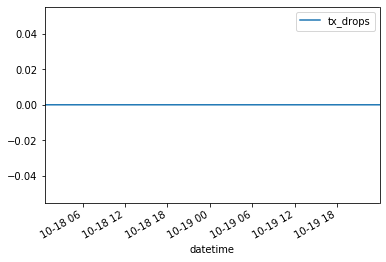

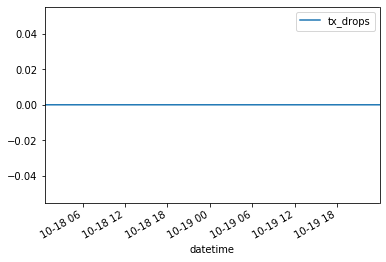

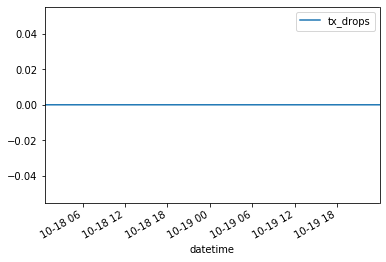

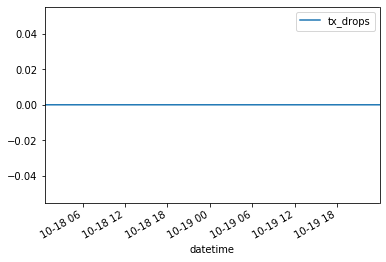

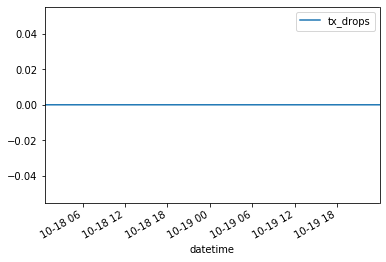

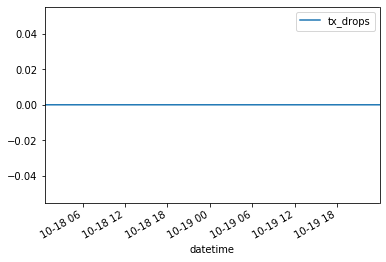

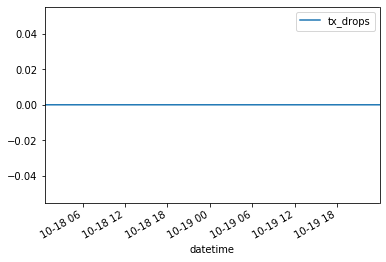

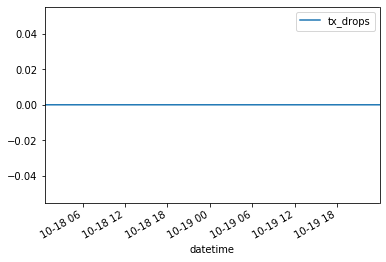

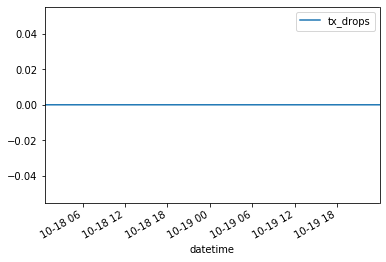

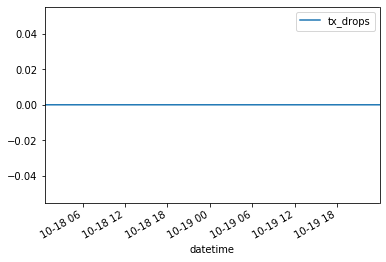

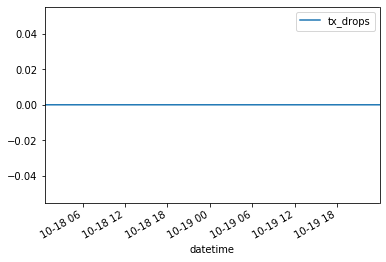

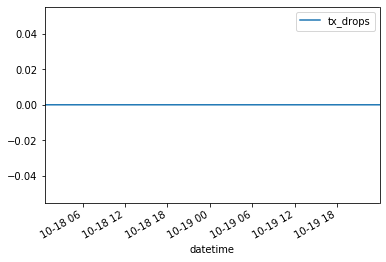

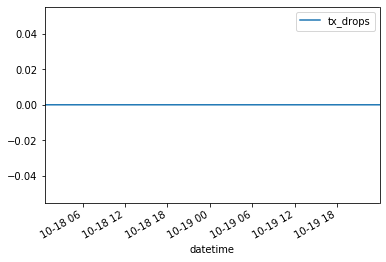

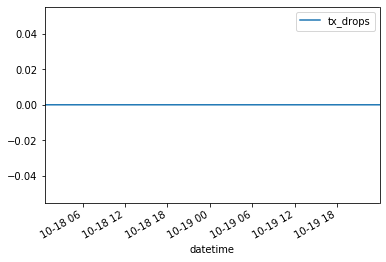

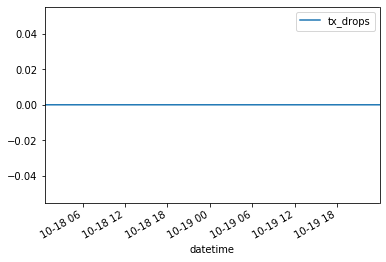

In [26]:
df_pd.groupby('name').plot(x='datetime', y = "tx_drops", subplots=True)
# df_pd[df_pd['name'].isin(names)].groupby('name').plot(x='datetime', y = "tx_drops", subplots=True)

name
.local.      [AxesSubplot(0.125,0.2;0.775x0.68)]
bme0         [AxesSubplot(0.125,0.2;0.775x0.68)]
cbp0         [AxesSubplot(0.125,0.2;0.775x0.68)]
dsc          [AxesSubplot(0.125,0.2;0.775x0.68)]
esi          [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/0     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/10    [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/5     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/6     [AxesSubplot(0.125,0.2;0.775x0.68)]
gre          [AxesSubplot(0.125,0.2;0.775x0.68)]
ipip         [AxesSubplot(0.125,0.2;0.775x0.68)]
irb          [AxesSubplot(0.125,0.2;0.775x0.68)]
jsrv         [AxesSubplot(0.125,0.2;0.775x0.68)]
lo0          [AxesSubplot(0.125,0.2;0.775x0.68)]
lsi          [AxesSubplot(0.125,0.2;0.775x0.68)]
me0          [AxesSubplot(0.125,0.2;0.775x0.68)]
mtun         [AxesSubplot(0.125,0.2;0.775x0.68)]
pfe-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pfh-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pimd         [AxesSubplot(0.125,0.2;0.775x0.68)]
pime         [A

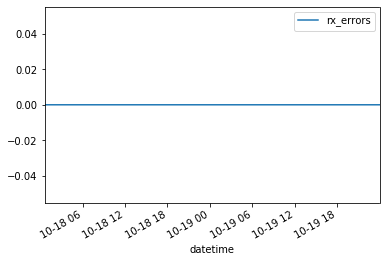

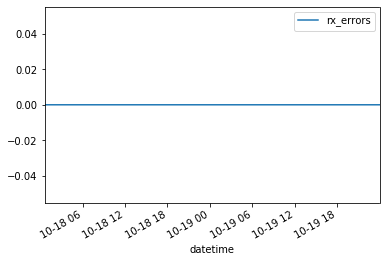

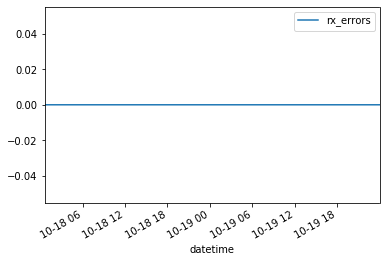

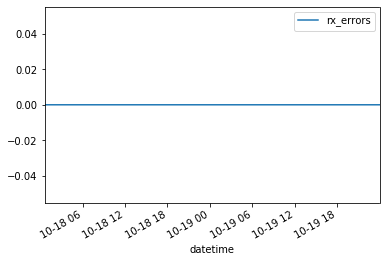

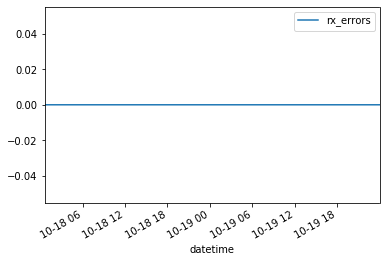

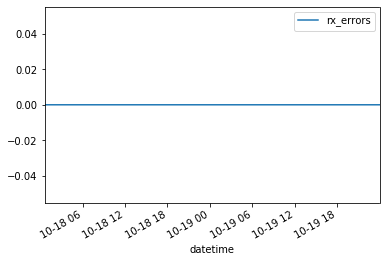

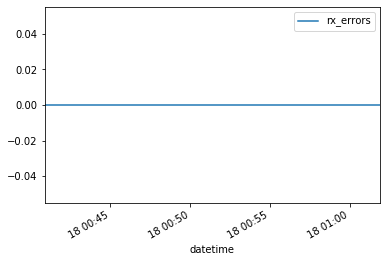

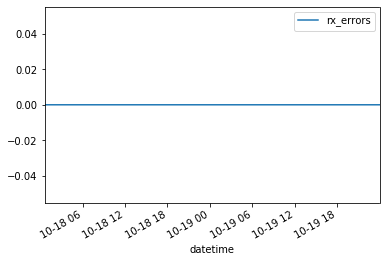

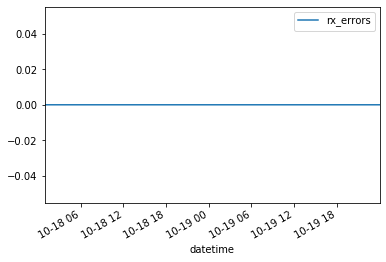

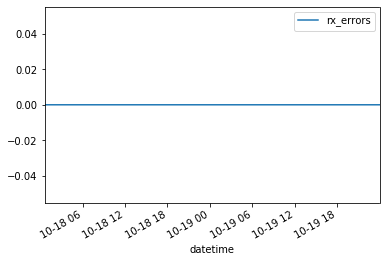

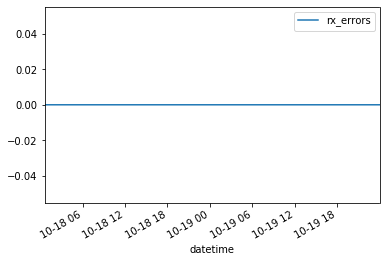

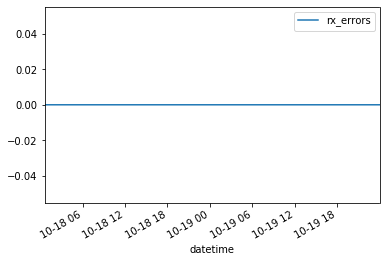

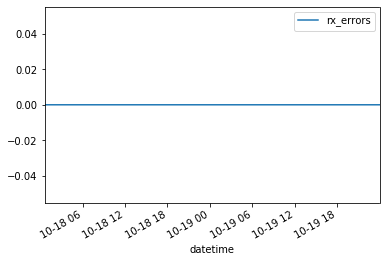

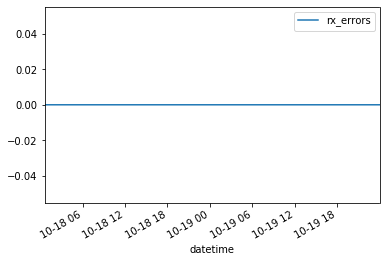

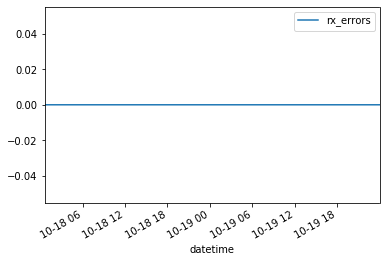

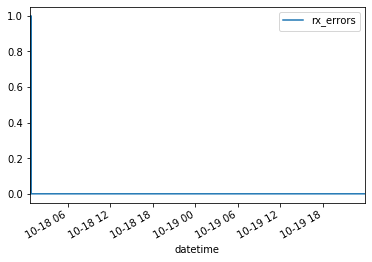

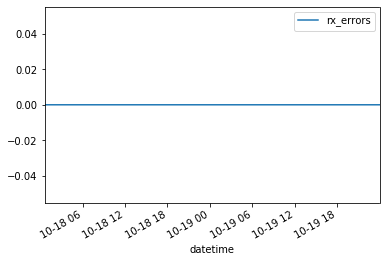

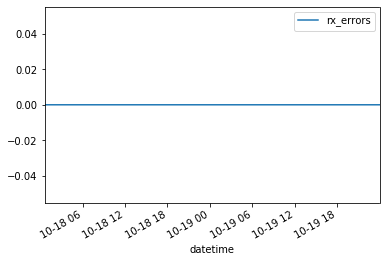

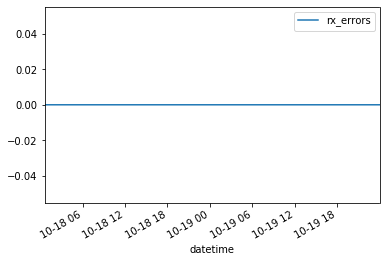

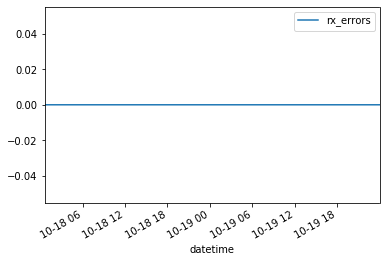

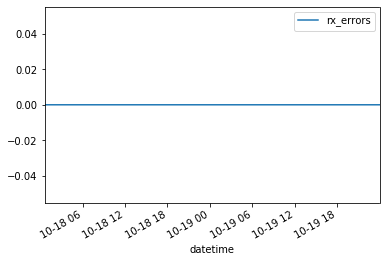

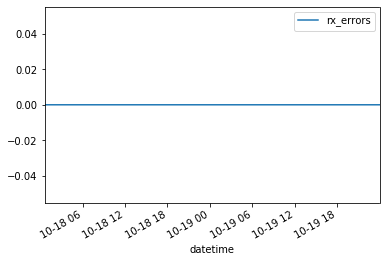

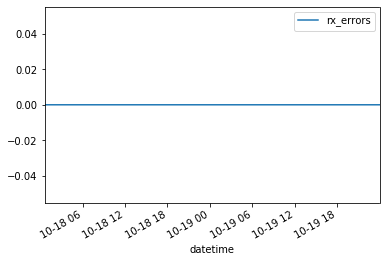

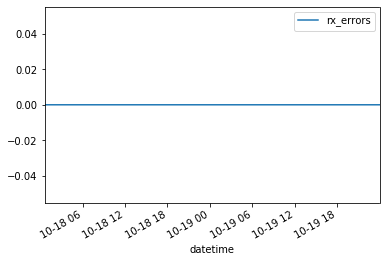

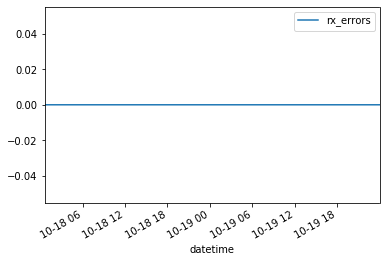

In [20]:
col1 = "rx_errors"
df_pd.groupby('name').plot(x='datetime', y = col1, subplots=True)
# df_pd[df_pd['name'].isin(names)].groupby('name').plot(x='datetime', y = "tx_drops", subplots=True)

In [21]:
df_pd.columns

Index(['id', 'when', 'org_id', 'site_id', 'name', 'link', 'full_duplex',
       'mbps', 'mtu', 'address', 'admin_status', 'last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta', 'datetime'],
      dtype='object')

name
.local.      [AxesSubplot(0.125,0.2;0.775x0.68)]
bme0         [AxesSubplot(0.125,0.2;0.775x0.68)]
cbp0         [AxesSubplot(0.125,0.2;0.775x0.68)]
dsc          [AxesSubplot(0.125,0.2;0.775x0.68)]
esi          [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/0     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/10    [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/5     [AxesSubplot(0.125,0.2;0.775x0.68)]
ge-0/0/6     [AxesSubplot(0.125,0.2;0.775x0.68)]
gre          [AxesSubplot(0.125,0.2;0.775x0.68)]
ipip         [AxesSubplot(0.125,0.2;0.775x0.68)]
irb          [AxesSubplot(0.125,0.2;0.775x0.68)]
jsrv         [AxesSubplot(0.125,0.2;0.775x0.68)]
lo0          [AxesSubplot(0.125,0.2;0.775x0.68)]
lsi          [AxesSubplot(0.125,0.2;0.775x0.68)]
me0          [AxesSubplot(0.125,0.2;0.775x0.68)]
mtun         [AxesSubplot(0.125,0.2;0.775x0.68)]
pfe-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pfh-0/0/0    [AxesSubplot(0.125,0.2;0.775x0.68)]
pimd         [AxesSubplot(0.125,0.2;0.775x0.68)]
pime         [A

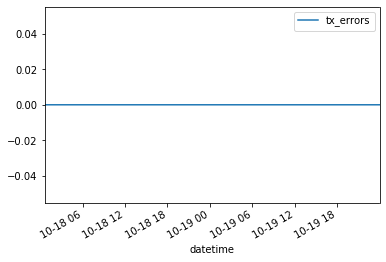

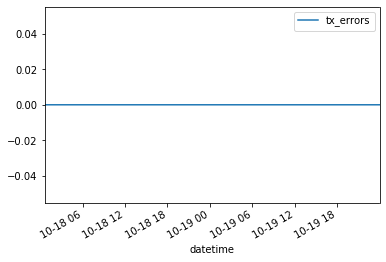

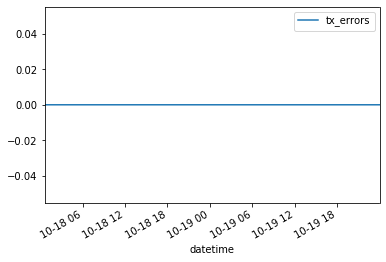

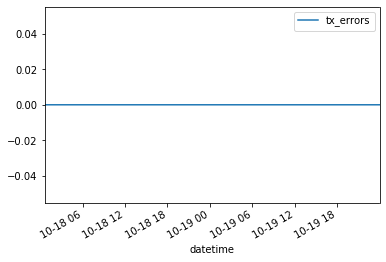

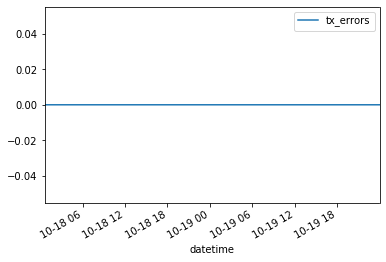

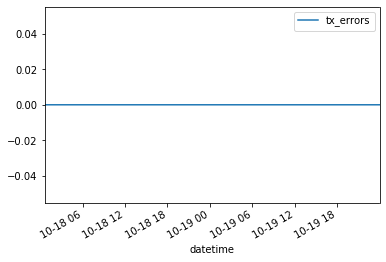

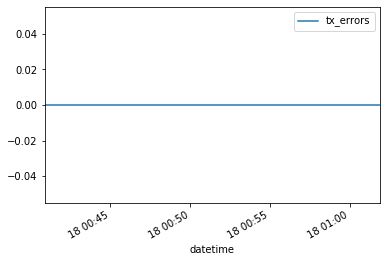

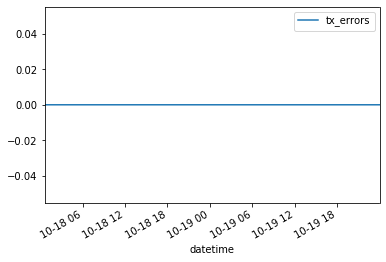

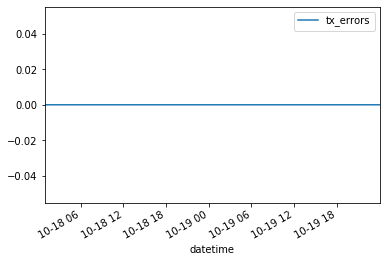

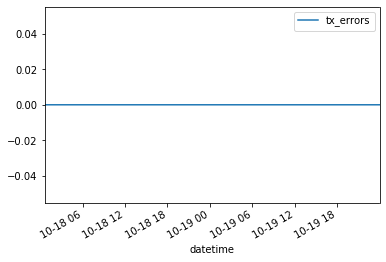

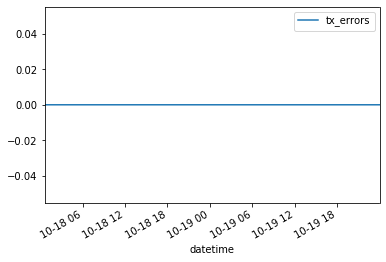

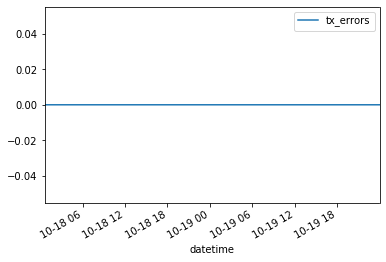

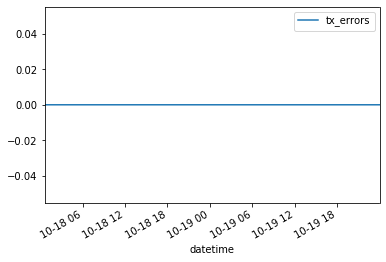

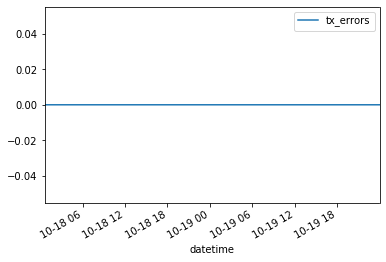

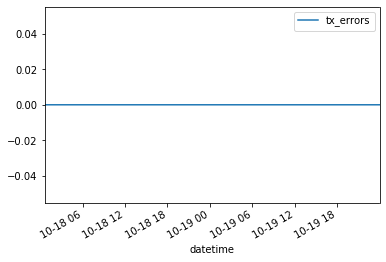

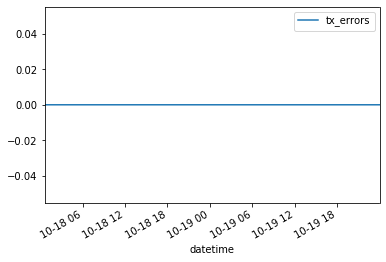

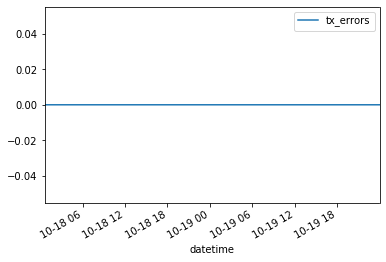

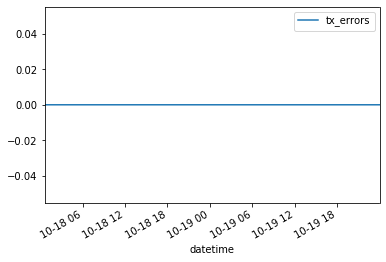

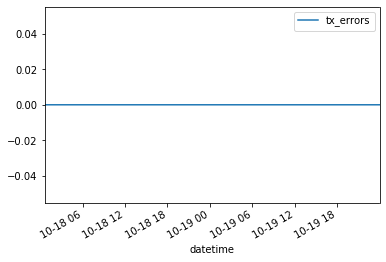

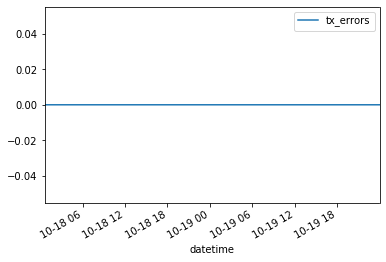

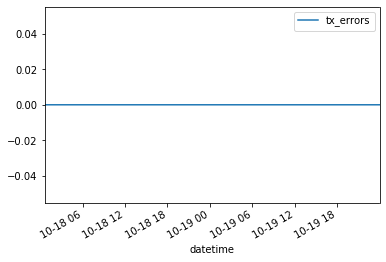

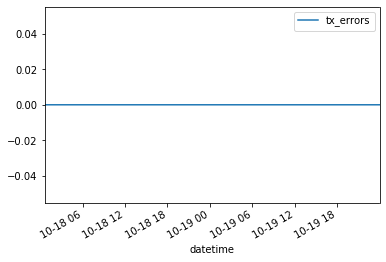

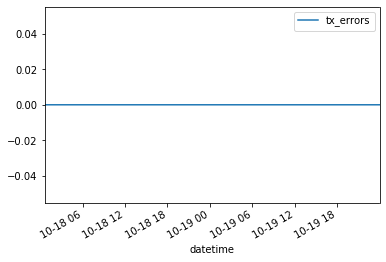

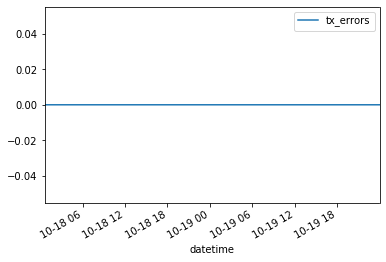

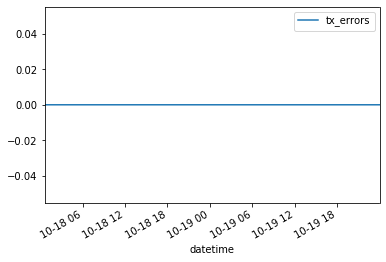

In [22]:
col1 = "tx_errors"
df_pd.groupby('name').plot(x='datetime', y = col1, subplots=True)
# df_pd[df_pd['name'].isin(names)].groupby('name').plot(x='datetime', y = "tx_drops", subplots=True)

In [24]:
df_pd.columns
# df_pd.head()


Index(['id', 'when', 'org_id', 'site_id', 'name', 'link', 'full_duplex',
       'mbps', 'mtu', 'address', 'admin_status', 'last_flapped', 'errors',
       'poe_enabled', 'poe_status', 'poe_power_limit', 'poe_power',
       'poe_priority', 'poe_class', 'poe_mode', 'rx_bytes', 'rx_bps',
       'rx_packets', 'tx_bytes', 'tx_bps', 'tx_packets', 'rx_errors',
       'rx_undersize_errors', 'rx_oversize_errors', 'rx_fcserrors',
       'rx_overrun_errors', 'rx_discards', 'tx_errors', 'tx_drops',
       'tx_mtuerrors', 'txcarrier_transition', 'tx_mcast_packets',
       'tx_bcast_packets', 'rx_mcast_packets', 'rx_bcast_packets',
       'interface_counter_delta', 'datetime'],
      dtype='object')

In [36]:
"""
Similar as wireless sle
{
 "ap_mac": "5c-5b-35-0e-bd-03",
 "band": "24",
 "channel": 11,
 "channel_width": 20,
 "classifier": "",
 "classifier_rank": 0,
 "client_os": "",
 "client_type": "Mac",
 "client_wcid": "b41f89f6-b6d9-db34-f7a0-7d730eca4f4e",
 "duration": 98.0,
 "en_client_sle_agg": 1,
 "ex_wl": 0,
 "metric": "coverage",
 "metric_rank": 0,
 "org_id": "f4d3653e-4aa3-11e5-8510-1258369c38a9",
 "site_id": "29d2648e-e66b-11e5-a6cd-0242ac110003",
 "threshold": -66,
 "time": 1571177692699,
 "value": -61.0,
 "wlan_id": "762c3b9e-ffa1-11e5-b5e1-0242ac110003"
}


# Switch sle
{
"org_id":  "f4d3653e-4aa3-11e5-8510-1258369c38a9"
"site_id":  "f4d40c28-4aa3-11e5-8510-1258369c38a9",
"switch_mac": '3c8c9394a39e'
"time":  1571177692699,

"metric": "switch_tput",
"classifier": "",          # client_count, client usage, 

"interface_name": 'ge-0/0/0',
"value": 
"threshold":
"duration":

}

aggregate


"""


def get_wire_sle():
    pass


In [31]:
# df11 = df1.first()
# df11

In [32]:
# df_d = df11.asDict()
# df_i_0 = df_d['interfaces'][0].asDict()
# df_i_0

In [33]:

# for row in df_d['interfaces']:
#     print(row["name"], row.link)



In [34]:
# df1_1 = df1.select('id',
#            col('interfaces.name').alias('name'),
#            col('interfaces.link').alias('link')
#           ).take(2)

from pyspark.sql.functions import flatten
# df1.select('id', flatten(df1.in))
# df1.columns
# df1.interfaces.

df1.select("id", "interfaces").rdd.take(1)


[Row(id='3c8c9394a39e', interfaces=[Row(name='ge-0/0/0', link=True, full_duplex=False, mbps=100, mtu=1514, address='', admin_status=True, last_flapped=1571265910000000, errors=[], poe_enabled=True, poe_status=True, poe_power_limit=19.5, poe_power=11.399999618530273, poe_priority=False, poe_class='4', poe_mode='', rx_bytes=9481, rx_bps=1352, rx_packets=46, tx_bytes=348000, tx_bps=22944, tx_packets=46, rx_errors=0, rx_undersize_errors=0, rx_oversize_errors=0, rx_fcserrors=0, rx_overrun_errors=0, rx_discards=0, tx_errors=0, tx_drops=0, tx_mtuerrors=0, txcarrier_transition=0, tx_mcast_packets=1864771, tx_bcast_packets=1167711, rx_mcast_packets=3663, rx_bcast_packets=1167711, interface_counter_delta=True), Row(name='pfe-0/0/0', link=True, full_duplex=False, mbps=800, mtu=0, address='', admin_status=True, last_flapped=-62135596800000000, errors=[], poe_enabled=False, poe_status=False, poe_power_limit=0.0, poe_power=0.0, poe_priority=False, poe_class='', poe_mode='', rx_bytes=0, rx_bps=0, rx_

In [ ]:
df1.select("id", "interfaces").rdd.map(lambda x: asDict()
df_i_0 = df_d['interfaces'][0].asDict()
df_i_0

In [16]:
df1_i = df1.select(col("id"), explode(col("interfaces")).alias("interface")) #.as("interface"))
df1_i.select('id', 'interface.*').take(10)

# val df = peopleDF.select(
#   col("name"),
#   explode(col("favorite_colors")).as("color")
# )

[Row(id='d8b12288af4f', name='ge-0/0/0', link=True, full_duplex=True, mbps=1000, mtu=1514, address='', admin_status=True, last_flapped=353000000, errors=[], poe_enabled=True, poe_status=False, poe_power_limit=15.399999618530273, poe_power=0.0, poe_priority=False, poe_class='not-applicable', poe_mode='', rx_bytes=18876, rx_bps=1240, rx_packets=103, tx_bytes=714, tx_bps=0, tx_packets=103, rx_errors=0, rx_undersize_errors=0, rx_oversize_errors=0, rx_fcserrors=0, rx_overrun_errors=0, rx_discards=0, tx_errors=0, tx_drops=0, tx_mtuerrors=0, txcarrier_transition=0, tx_mcast_packets=966772, tx_bcast_packets=1660476, rx_mcast_packets=9527160, rx_bcast_packets=1660476, interface_counter_delta=True),
 Row(id='d8b12288af4f', name='pfe-0/0/0', link=True, full_duplex=False, mbps=800, mtu=0, address='', admin_status=True, last_flapped=-62135596800000000, errors=[], poe_enabled=False, poe_status=False, poe_power_limit=0.0, poe_power=0.0, poe_priority=False, poe_class='', poe_mode='', rx_bytes=0, rx_bp

In [29]:
def extract(row, key):
    """Takes dictionary and key, returns tuple of (dict w/o key, dict[key])."""
    _dict = row.asDict()
    _list = _dict[key]
    del _dict[key]
    return (_dict.get("id"), _list)


def add_to_dict(_dict, key, value):
    _dict[key] = value
    return _dict


rdd = df1.rdd
# preserve rest of values in key, put list to flatten in value
rdd = rdd.map(lambda x: extract(x, 'interfaces'))
# # make a row for each item in value
# rdd = rdd.flatMapValues(lambda x: x)
# # add flattened value back into dictionary
# rdd = rdd.map(lambda x: add_to_dict(x.id, 'interfaces'))
# # convert back to dataframe
# df = sqlContext.createDataFrame(rdd)


df_t = rdd.take(1)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 13.0 failed 1 times, most recent failure: Lost task 0.0 in stage 13.0 (TID 24, localhost, executor driver): org.apache.hadoop.fs.s3a.AWSS3IOException: getFileStatus on s3://mist-secorapp-staging/oc-stats-analytics/oc-stats-analytics-staging/dt=2019-10-16/hr=02/1_0_00000000000000118792.parquet: com.amazonaws.services.s3.model.AmazonS3Exception: Bad Request (Service: Amazon S3; Status Code: 400; Error Code: 400 Bad Request; Request ID: 406436C1CC9E9EC0), S3 Extended Request ID: nzsXf0V0j/w8UENqeeqLwHRj5yGb4Kwy4+SEXeYx6GT50l5aVJLoNftDp3TY9Rmu9j+ZUSzJ5EI=: Bad Request (Service: Amazon S3; Status Code: 400; Error Code: 400 Bad Request; Request ID: 406436C1CC9E9EC0)
	at org.apache.hadoop.fs.s3a.S3AUtils.translateException(S3AUtils.java:178)
	at org.apache.hadoop.fs.s3a.S3AUtils.translateException(S3AUtils.java:101)
	at org.apache.hadoop.fs.s3a.S3AFileSystem.getFileStatus(S3AFileSystem.java:1568)
	at org.apache.hadoop.fs.s3a.S3AFileSystem.getFileStatus(S3AFileSystem.java:117)
	at org.apache.parquet.hadoop.util.HadoopInputFile.fromPath(HadoopInputFile.java:39)
	at org.apache.parquet.hadoop.ParquetFileReader.readFooter(ParquetFileReader.java:448)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anonfun$buildReaderWithPartitionValues$1.footerFileMetaData$lzycompute$1(ParquetFileFormat.scala:371)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anonfun$buildReaderWithPartitionValues$1.footerFileMetaData$1(ParquetFileFormat.scala:370)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anonfun$buildReaderWithPartitionValues$1.apply(ParquetFileFormat.scala:374)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anonfun$buildReaderWithPartitionValues$1.apply(ParquetFileFormat.scala:352)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:124)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:177)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:101)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:462)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:153)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:148)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:224)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:561)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:346)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1945)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:195)
Caused by: com.amazonaws.services.s3.model.AmazonS3Exception: Bad Request (Service: Amazon S3; Status Code: 400; Error Code: 400 Bad Request; Request ID: 406436C1CC9E9EC0), S3 Extended Request ID: nzsXf0V0j/w8UENqeeqLwHRj5yGb4Kwy4+SEXeYx6GT50l5aVJLoNftDp3TY9Rmu9j+ZUSzJ5EI=
	at com.amazonaws.http.AmazonHttpClient.handleErrorResponse(AmazonHttpClient.java:1182)
	at com.amazonaws.http.AmazonHttpClient.executeOneRequest(AmazonHttpClient.java:770)
	at com.amazonaws.http.AmazonHttpClient.executeHelper(AmazonHttpClient.java:489)
	at com.amazonaws.http.AmazonHttpClient.execute(AmazonHttpClient.java:310)
	at com.amazonaws.services.s3.AmazonS3Client.invoke(AmazonS3Client.java:3785)
	at com.amazonaws.services.s3.AmazonS3Client.getObjectMetadata(AmazonS3Client.java:1050)
	at com.amazonaws.services.s3.AmazonS3Client.getObjectMetadata(AmazonS3Client.java:1027)
	at org.apache.hadoop.fs.s3a.S3AFileSystem.getObjectMetadata(S3AFileSystem.java:904)
	at org.apache.hadoop.fs.s3a.S3AFileSystem.getFileStatus(S3AFileSystem.java:1553)
	... 22 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.hadoop.fs.s3a.AWSS3IOException: getFileStatus on s3://mist-secorapp-staging/oc-stats-analytics/oc-stats-analytics-staging/dt=2019-10-16/hr=02/1_0_00000000000000118792.parquet: com.amazonaws.services.s3.model.AmazonS3Exception: Bad Request (Service: Amazon S3; Status Code: 400; Error Code: 400 Bad Request; Request ID: 406436C1CC9E9EC0), S3 Extended Request ID: nzsXf0V0j/w8UENqeeqLwHRj5yGb4Kwy4+SEXeYx6GT50l5aVJLoNftDp3TY9Rmu9j+ZUSzJ5EI=: Bad Request (Service: Amazon S3; Status Code: 400; Error Code: 400 Bad Request; Request ID: 406436C1CC9E9EC0)
	at org.apache.hadoop.fs.s3a.S3AUtils.translateException(S3AUtils.java:178)
	at org.apache.hadoop.fs.s3a.S3AUtils.translateException(S3AUtils.java:101)
	at org.apache.hadoop.fs.s3a.S3AFileSystem.getFileStatus(S3AFileSystem.java:1568)
	at org.apache.hadoop.fs.s3a.S3AFileSystem.getFileStatus(S3AFileSystem.java:117)
	at org.apache.parquet.hadoop.util.HadoopInputFile.fromPath(HadoopInputFile.java:39)
	at org.apache.parquet.hadoop.ParquetFileReader.readFooter(ParquetFileReader.java:448)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anonfun$buildReaderWithPartitionValues$1.footerFileMetaData$lzycompute$1(ParquetFileFormat.scala:371)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anonfun$buildReaderWithPartitionValues$1.footerFileMetaData$1(ParquetFileFormat.scala:370)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anonfun$buildReaderWithPartitionValues$1.apply(ParquetFileFormat.scala:374)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anonfun$buildReaderWithPartitionValues$1.apply(ParquetFileFormat.scala:352)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:124)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:177)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:101)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:462)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:153)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:148)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:224)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:561)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:346)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1945)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:195)
Caused by: com.amazonaws.services.s3.model.AmazonS3Exception: Bad Request (Service: Amazon S3; Status Code: 400; Error Code: 400 Bad Request; Request ID: 406436C1CC9E9EC0), S3 Extended Request ID: nzsXf0V0j/w8UENqeeqLwHRj5yGb4Kwy4+SEXeYx6GT50l5aVJLoNftDp3TY9Rmu9j+ZUSzJ5EI=
	at com.amazonaws.http.AmazonHttpClient.handleErrorResponse(AmazonHttpClient.java:1182)
	at com.amazonaws.http.AmazonHttpClient.executeOneRequest(AmazonHttpClient.java:770)
	at com.amazonaws.http.AmazonHttpClient.executeHelper(AmazonHttpClient.java:489)
	at com.amazonaws.http.AmazonHttpClient.execute(AmazonHttpClient.java:310)
	at com.amazonaws.services.s3.AmazonS3Client.invoke(AmazonS3Client.java:3785)
	at com.amazonaws.services.s3.AmazonS3Client.getObjectMetadata(AmazonS3Client.java:1050)
	at com.amazonaws.services.s3.AmazonS3Client.getObjectMetadata(AmazonS3Client.java:1027)
	at org.apache.hadoop.fs.s3a.S3AFileSystem.getObjectMetadata(S3AFileSystem.java:904)
	at org.apache.hadoop.fs.s3a.S3AFileSystem.getFileStatus(S3AFileSystem.java:1553)
	... 22 more


In [30]:
df_t[0][0]

{'id': 'd8b12288af4f',
 'mac': 'd8b12288af4f',
 'org_id': '6748cfa6-4e12-11e6-9188-0242ac110007',
 'site_id': '67970e46-4e12-11e6-9188-0242ac110007',
 'when': 1571192833701375,
 'remote_addr': '100.96.86.0:2709',
 'clients': [Row(vlan_name='', mac='c471fe4ca480', flags='', age=0, iface_name='ge-0/0/0', vlan_id=0)],
 'aps': [],
 'hostname': 'mist-lab-ex2300c',
 'model': 'EX2300-C-12P',
 'firmware_version': '18.2R2.6',
 'config_history': [],
 'alarms': [],
 'ipv4_route': [Row(dst='0.0.0.0/0', gw='192.168.8.1')],
 'lldpneighbors': [Row(local_port_id='ge-0/0/0', local_parent_iface_name='-', remote_chassis_id='c4:71:fe:4c:a4:80', remote_chassis_idsubtype='Mac address', remote_port_desc='GigabitEthernet0/5', remote_system_name='', remote_mgmt_addr='192.168.8.253', remote_system_desc='Cisco IOS Software, C3560E Software (C3560E-UNIVERSALK9-M), Version 15.0(2)SE, RELEASE SOFTWARE (fc1)\nTechnical Support: http://www.cisco.com/techsupport\nCopyright (c) 1986-2012 by Cisco Systems, Inc.\nCompile

In [16]:
rdd = rdd.map(lambda x: add_to_dict(x.id, 'interfaces'))


In [18]:
rdd.take(1)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 9.0 failed 1 times, most recent failure: Lost task 0.0 in stage 9.0 (TID 20, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-16-a58fd23c4ccb>", line 1, in <lambda>
AttributeError: 'tuple' object has no attribute 'id'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/opt/mistsys/ds_incubator/venv/spark-2.4.4-bin-without-hadoop/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-16-a58fd23c4ccb>", line 1, in <lambda>
AttributeError: 'tuple' object has no attribute 'id'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [50]:
#df1.select(col('interfaces')).show()
rdd= df1.rdd
dat = rdd.map(lambda x: x.interfaces[0].tx_bytes).collect()

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline  
# !pip install matplotlib


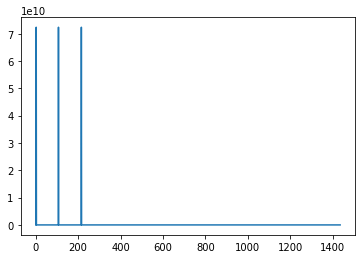

In [39]:
plt.plot(dat)

In [17]:
df1.select(col('interfaces.*')).show()

AnalysisException: 'Can only star expand struct data types. Attribute: `ArrayBuffer(interfaces)`;'

In [19]:
dir(df1)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_collectAsArrow',
 '_jcols',
 '_jdf',
 '_jmap',
 '_jseq',
 '_lazy_rdd',
 '_repr_html_',
 '_sc',
 '_schema',
 '_sort_cols',
 '_support_repr_html',
 'agg',
 'alias',
 'approxQuantile',
 'cache',
 'checkpoint',
 'coalesce',
 'colRegex',
 'collect',
 'columns',
 'corr',
 'count',
 'cov',
 'createGlobalTempView',
 'createOrReplaceGlobalTempView',
 'createOrReplaceTempView',
 'createTempView',
 'crossJoin',
 'crosstab',
 'cube',
 'describe',
 'distinct',
 'drop',
 'dropDuplicates',
 'drop_duplicates',
 'dropna',
 'dtypes',
 'exceptAll',
 'explain',
 'fillna',
 'filter',
 'first',
 'foreach',
 'f

In [26]:
dfin = df1.select('id',
                 'mac',
                 'org_id',
                 'site_id',
                 'ts',
                 'remote_addr',
                  'hostname',
                  'model',
                  'version',
                  'serial',
                  'uptime',
                   'pctrl_ix',
                   'pctrl_maxpwr',
                   'pctrl_consump',
                   'pctrl_gband',
                  col('interfaces.name').alias('name'),
                   col('interfaces.link').alias('link'),
                   col('interfaces.full_duplex').alias('full_duplex'),
                   col('interfaces.mbps').alias('mbps'),
                   col('interfaces.mtu').alias('mtu'),
                   col('interfaces.address').alias('address'),
                   col('interfaces.admin_status').alias('admin_status'),
                   col('interfaces.last_flapped.seconds').alias('last_flapped'),
                   col('interfaces.errors').alias('errors'),
                   col('interfaces.poe.enabled').alias('poe_enabled'),
                   col('interfaces.poe.status').alias('poe_status'),
                   col('interfaces.poe.power_limit').alias('poe_pwrlimit'),
                   col('interfaces.poe.power').alias('poe_power'),
                   col('interfaces.poe.priority').alias('poe_priority'),
                   col('interfaces.poe.class').alias('poe_class'),
                   col('interfaces.poe.mode').alias('poe_mode'),
                   col('interfaces.rx_bytes').alias('rx_bytes'),
                   col('interfaces.tx_bytes').alias('tx_bytes'),
                   col('interfaces.rx_packets').alias('rx_pkts'),
                   col('interfaces.tx_packets').alias('tx_pkts'),
                   col('interfaces.rx_bps').alias('rx_bps'),
                   col('interfaces.tx_bps').alias('tx_bps'))


AnalysisException: 'No such struct field poe in name, link, full_duplex, mbps, mtu, address, admin_status, last_flapped, errors, poe_enabled, poe_status, poe_power_limit, poe_power, poe_priority, poe_class, poe_mode, rx_bytes, rx_bps, rx_packets, tx_bytes, tx_bps, tx_packets, rx_errors, rx_undersize_errors, rx_oversize_errors, rx_fcserrors, rx_overrun_errors, rx_discards, tx_errors, tx_drops, tx_mtuerrors, txcarrier_transition, tx_mcast_packets, tx_bcast_packets, rx_mcast_packets, rx_bcast_packets, interface_counter_delta;'